# Yolov3 Object Detection

## 设置数据集 | prepare our dataset

请将数据集压缩包上传到Image文件夹下，上传完成后执行下面的代码解压文件。
确保解压后的Image目录下的结构如下：

|Image

|—VOCdevkit

|——-VOC2007(具体数据集文件夹名称)

|————Annotations

        └─  *.xml # 存放图片的类别与边框

|————JPEGImages

        └─ *.jpg # 存放图片

|————ImageSets

|——————Main

            └─ *.txt # 存放训练集、验证集所用图片名称，请确保包括了train.txt 和 val.txt，其中包含了图片的文件名，图片分别用于训练和验证，没有交集

### 解压数据集

### ❗ 下面的单元格需要修改 ❗

In [1]:
#unzip *.zip
import os
os.chdir('/home/msft/msfthack/Image')#工作目录转到Image文件夹下
#下载测试用数据集
#!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#解压数据集
# 请将文件名修改为实际压缩文件名 zip文件使用unzip解压,tar文件用tar解压
#!unzip helmet.zip
#!tar xf helmet.tar
!ls

helmet.zip  VOCdevkit  VOCdevkit.zip  VOCtrainval_06-Nov-2007.tar


如果有图片扩展名为大写，取消下面单元格注释并执行

In [6]:
#import os
#os.chdir('/home/msft/msfthack/Image/VOCdevkit/helmet/JPEGImages/')
#!rename 'y/A-Z/a-z/' *
#os.chdir('/home/msft/msfthack/Image')#工作目录转到Image文件夹下

### 设置数据集参数

### ❗ 下面2个单元格需要修改 ❗

In [2]:
#请修改文件夹名称
imagefolder = 'lenovo2'

In [3]:
#请修改类别名称
classnames = ['New','Old','Wrong']

## 标签格式转换

执行如下代码，将会在图片目录下产生`训练集`和`验证集`文本文件，其中内容为图片的绝对路径。

In [4]:
import xml.etree.ElementTree as ET
import pickle
import os
from os import listdir, getcwd
from os.path import join

sets=[(imagefolder, 'train'), (imagefolder, 'val')]

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(foldername, image_id):
    in_file = open('VOCdevkit/%s/Annotations/%s.xml'%(foldername, image_id))
    out_file = open('VOCdevkit/%s/labels/%s.txt'%(foldername, image_id), 'w')
    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        #if your xml has difficult property, comment next line and comment the next line
        difficult = '0'
        #difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classnames or int(difficult) == 1:
            continue
        cls_id = classnames.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

wd = getcwd()

for foldername, image_set in sets:
    if not os.path.exists('VOCdevkit/%s/labels/'%(foldername)):
        os.makedirs('VOCdevkit/%s/labels/'%(foldername))
    image_ids = open('VOCdevkit/%s/ImageSets/Main/%s.txt'%(foldername, image_set)).read().strip().split()
    list_file = open('VOCdevkit/%s/%s_%s.txt'%(foldername,foldername, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/%s/JPEGImages/%s.jpg\n'%(wd, foldername, image_id))
        convert_annotation(foldername, image_id)
    list_file.close()

#### 查看生成的文件

In [5]:
os.chdir('VOCdevkit/' + foldername)
!ls

Annotations	       classes.csv  labels	       logs
annotations_train.csv  ImageSets    lenovo2_train.txt  snapshots
annotations_val.csv    JPEGImages   lenovo2_val.txt


## 基础参数设置

数据集信息配置

In [7]:
#cfg/voc.data
classes= len(classnames)
train  = '/home/msft/msfthack/Image/VOCdevkit/' + foldername + '/' + foldername + '_train.txt'
valid  = '/home/msft/msfthack/Image/VOCdevkit/' + foldername + '/' + foldername + '_val.txt'
names = 'data/voc.names'
backup = 'backup'
vocdata=['classes = '+ str(classes), 'train = '+ train, 'valid = '+ valid, 'names = '+ names, 'backup = '+backup]

In [8]:
vocdata

['classes = 3',
 'train = /home/msft/msfthack/Image/VOCdevkit/lenovo2/lenovo2_train.txt',
 'valid = /home/msft/msfthack/Image/VOCdevkit/lenovo2/lenovo2_val.txt',
 'names = data/voc.names',
 'backup = backup']

In [9]:
vocdatafilepath = '/home/msft/msfthack/darknet/cfg/voc.data'
for i in range(len(vocdata)):
    vocdata[i] = vocdata[i] +'\n'
with open(vocdatafilepath,'w') as f:
    f.writelines(vocdata)

In [10]:
vocnamesfilepath = '/home/msft/msfthack/darknet/data/voc.names'
with open(vocnamesfilepath,'w') as f:
    for item in classnames:
        f.write(item+'\n')

## 训练参数设置

请在训练时将batch和subdivisions设置成不为1的值，测试时使两个值均为1

### ❗ 下面的单元格需要修改 ❗

In [11]:
#请修改下面两行, 下面为默认值
batch = 16
subdivisions = 8
#filers请勿修改
filters = (classes + 5) * 3

In [12]:
voccfgfilepath = '/home/msft/msfthack/darknet/cfg/yolov3-voc.cfg'
lines = []
with open(voccfgfilepath,'r') as f:
    lines = f.readlines()
    
if batch != 1 and subdivisions != 1:
    lines[2] = '# batch=1\n'
    lines[3] = '# subdivisions=1\n'
    lines[5] = 'batch=' + str(batch) +'\n'
    lines[6] = 'subdivisions=' + str(subdivisions) +'\n'
else:
    lines[2] = 'batch=1\n'
    lines[3] = 'subdivisions=1\n'
    lines[5] = '# '+ lines[5]
    lines[6] = '# '+ lines[6]
for i in range(len(lines)):
    if lines[i] == '[yolo]\n':
        lines[i-3] = 'filters='+ str(filters) + '\n'
        lines[i+3] = 'classes='+ str(classes) + '\n'
        
with open(voccfgfilepath,'w') as f:
    f.writelines(lines)

## 开始训练

下载预训练模型

In [13]:
#切换工作目录至darknet
os.chdir('/home/msft/msfthack/darknet')

In [29]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2018-08-07 17:09:15--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com... 128.208.3.39
Connecting to pjreddie.com|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.2’

darknet53.conv.74.2 100%[===================>] 154.96M  37.7MB/s    in 4.5s    

2018-08-07 17:09:20 (34.1 MB/s) - ‘darknet53.conv.74.2’ saved [162482580/162482580]



下面开始训练命令，这一过程时间较长，请观察输出的损失值,例如

> 8: 1681.814209, 1683.156128 avg loss, 0.000000 rate, 19.733069 seconds, 512 images

这里的loss在1681，在loss降低到0.0XXX时可手动终止。开始时损失值较大，后面会收敛到比较小的值。

如果有多个GPU,请修改gpus参数，例如 -gpus 0,1,2,3

In [20]:
!./darknet detector train cfg/voc.data cfg/yolov3-voc.cfg darknet53.conv.74 -gpus 0

0
yolov3-voc
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564690, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470740, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.498940, Class: 0.283495, Obj: 0.427242, No Obj: 0.492665, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565906, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.401548, Class: 0.263358, Obj: 0.392365, No Obj: 0.471891, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.335654, Class: 0.538403, Obj: 0.531256, No Obj: 0.492484, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566961, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470660, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565189, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470979, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.459498, Class: 0.492517, Obj: 0.342331, No Obj: 0.491997, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564613, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.299763, Class: 0.392761, Obj: 0.330100, No Obj: 0.473520, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493118, .5R: -nan, .75R: -nan,  count: 0

 4: 655.402100, 655.966980 avg loss, 0.000000 rate, 2.251944 seconds, 64 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564594, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.419281, Class: 0.357759, Obj: 0.401993, No Obj: 0.471157, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class:


 7: 655.500305, 655.762573 avg loss, 0.000000 rate, 2.264244 seconds, 112 images
Loaded: 0.000041 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566081, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.472801, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492415, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.424289, Class: 0.675633, Obj: 0.390036, No Obj: 0.564665, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.472259, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.376192, Class: 0.492265, Obj: 0.560920, No Obj: 0.493407, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564705, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.357315, Class: 0.361686, Obj: 0.359590, No Obj: 0.472319, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564912, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.174406, Class: 0.514050, Obj: 0.277578, No Obj: 0.471260, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.493059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565625, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471193, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.099681, Class: 0.543736, Obj: 0.445756, No Obj: 0.492055, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566208, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.412963, Class: 0.425255, Obj: 0.717398, No Obj: 0.471187, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492116, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565156, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.079250, Class: 0.373238, Obj: 0.297037, No Obj: 0.471141, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.247021, Class: 0.429618, Obj: 0.631269, No Obj: 0.492497, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565756, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.472179, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.312824, Class: 0.494608, Obj: 0.315291, No Obj: 0.492648, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565543, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471671, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.627364, Class: 0.323849, Obj: 0.387416, No Obj: 0.492146, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: 0.245711, Class: 0.537879, Obj: 0.827896, No Obj: 0.565792, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.472397, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492561, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471174, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.491900, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564823, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.275312, Class: 0.406146, Obj: 0.679151, No Obj: 0.471469, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.245896, Class: 0.499587, Obj: 0.456741, No Obj: 0.493003, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566579, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.325537, Class: 0.520468, Obj: 0.526008, No Obj: 0.471485, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.491914, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.038856, Class: 0.809897, Obj: 0.770687, No Obj: 0.566589, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471173, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492110, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565457, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.181757, Class: 0.139396, Obj: 0.561985, No Obj: 0.471379, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.170674, Class: 0.873349, Obj: 0.507266, No Obj: 0.492374, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565138, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471985, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.388967, Class: 0.564916, Obj: 0.686204, No Obj: 0.491652, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565360, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.671206, Class: 0.699334, Obj: 0.678027, No Obj: 0.471139, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492783, .5R: -nan, .75R: -nan,  count: 0

 23: 541.176819, 971.539673 avg loss, 0.000000 rate, 1.928738 seconds, 368 images
Loaded: 0.000068 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566464, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471542, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471210, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.147426, Class: 0.329997, Obj: 0.725525, No Obj: 0.492237, .5R: 0.000000, .75R: 0.000000,  count: 1

 26: 541.812622, 855.049194 avg loss, 0.000000 rate, 1.933313 seconds, 416 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565352, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.746408, Class: 0.315491, Obj: 0.523439, No Obj: 0.472135, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.095645, Class: 0.804104, Obj: 0.518511, No Obj: 0.492770, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566144, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471238, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.491767, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.586021, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565171, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470890, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.397712, Class: 0.441124, Obj: 0.396672, No Obj: 0.491281, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.387685, Class: 0.642043, Obj: 0.615159, No Obj: 0.492167, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566472, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471951, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492056, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492030, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565534, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.121447, Class: 0.484943, Obj: 0.386153, No Obj: 0.470670, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.491409, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564454, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471302, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.113361, Class: 0.561445, Obj: 0.378929, No Obj: 0.492625, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564501, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471558, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.566262, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471349, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.491338, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.246883, Class: 0.341810, Obj: 0.639340, No Obj: 0.564083, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471963, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492202, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.264529, Class: 0.272782, Obj: 0.637062, No Obj: 0.565232, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471288, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.429339, Class: 0.393243, Obj: 0.391437, No Obj: 0.491376, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563847, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.101693, Class: 0.324456, Obj: 0.643523, No Obj: 0.470739, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.490395, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565259, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.331094, Class: 0.398225, Obj: 0.413675, No Obj: 0.470363, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.490554, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563842, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.538094, Class: 0.729646, Obj: 0.474873, No Obj: 0.471208, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.284569, Class: 0.427256, Obj: 0.488904, No Obj: 0.490940, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.489072, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563775, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471650, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.490572, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.565033, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.374879, Class: 0.317893, Obj: 0.662057, No Obj: 0.469606, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.489564, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564031, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470221, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.420950, Class: 0.370651, Obj: 0.220533, No Obj: 0.48934

Region 82 Avg IOU: 0.567543, Class: 0.438102, Obj: 0.582508, No Obj: 0.564502, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.469878, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.116865, Class: 0.569469, Obj: 0.523043, No Obj: 0.488286, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564184, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.468855, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.488340, .5R: -nan, .75R: -nan,  count: 0

 45: 1201.042480, 1246.423096 avg loss, 0.000000 rate, 4.126983 seconds, 720 images
Loaded: 0.000068 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.564440, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.469095, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563176, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.468394, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.332249, Class: 0.623568, Obj: 0.423499, No Obj: 0.486112, .5R: 0.000000, .75R: 0.000000,  count: 1

 48: 1193.374756, 1232.876099 avg loss, 0.000000 rate, 4.085787 seconds, 768 images
Loaded: 0.000064 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563718, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.468240, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.485283, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.563777, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.467614, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.484898, 

Region 82 Avg IOU: 0.108069, Class: 0.487403, Obj: 0.407867, No Obj: 0.562790, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.467337, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.483968, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562708, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.466818, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.482746, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.566967, Class: 0.493641, Obj: 0.392727, No Obj: 0.563541, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.325723, Class: 0.349403, Obj: 0.350409, No Obj: 0.466425, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.482644, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.560653, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.466095, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.480531, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561300, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.464729, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.195560, Class: 0.786417, Obj: 0.310478, No Obj: 0.479135, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561855, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.465620, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.479976, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.562221, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561032, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.463649, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.400108, Class: 0.767684, Obj: 0.321178, No Obj: 0.475101, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.561413, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.463472, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.475284, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559333, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.463901, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.476052, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559344, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.471823, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558858, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.461135, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.431307, Class: 0.655026, Obj: 0.252525, No Obj: 0.470914, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.559299, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.461499, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470700, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.558886, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.461078, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.470239, .5R: -nan

Region 106 Avg IOU: 0.416667, Class: 0.569126, Obj: 0.293871, No Obj: 0.464201, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.284111, Class: 0.277459, Obj: 0.723027, No Obj: 0.557532, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.457317, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.026452, Class: 0.412525, Obj: 0.650895, No Obj: 0.463519, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.404335, Class: 0.274089, Obj: 0.833891, No Obj: 0.556823, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.458028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.463645, .5R: -nan, .75R: -nan,  count: 0

 64: 1590.450928, 1396.894897 avg loss, 0.000000 rate, 5.631632 seconds, 1024 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.556164, .5R: -nan, .75R: -nan,  count: 0
Region

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554474, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.453863, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.454415, .5R: -nan, .75R: -nan,  count: 0

 67: 1543.537354, 1440.774414 avg loss, 0.000000 rate, 5.651237 seconds, 1072 images
Loaded: 0.000058 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.553185, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.452662, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.324462, Class: 0.587323, Obj: 0.650540, No Obj: 0.452065, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554480, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.452094, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.452278,

 try to allocate workspace = 5971969 * sizeof(float),  CUDA allocate done! 
Loaded: 0.271882 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.552338, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.446776, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.175934, Class: 0.545612, Obj: 0.224532, No Obj: 0.440330, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.549796, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.446415, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.238132, Class: 0.481321, Obj: 0.365077, No Obj: 0.440321, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.550151, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.446091, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.547537, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.124815, Class: 0.347527, Obj: 0.371075, No Obj: 0.441601, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.430200, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.547930, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.440847, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.427610, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.546858, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.616760, Class: 0.656709, Obj: 0.553928, No Obj: 0.440807, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.240663, Class: 0.432174, Obj: 0.399951, No Obj: 0.429680, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.543754, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.434925, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.336166, Class: 0.540883, Obj: 0.449953, No Obj: 0.416825, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.543721, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.436141, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.114032, Class: 0.608838, Obj: 0.420285, No Obj: 0.418816, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.543774, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.435965, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.418176, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.540160, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.430000, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.545055, Class: 0.415957, Obj: 0.319041, No Obj: 0.405748, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.540661, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.591398, Class: 0.255687, Obj: 0.270598, No Obj: 0.429515, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.407731, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.541637, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.429365, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.305073, Class: 0.632406, Obj: 0.466036, No Obj: 0.407119, .5R: 0.000000, .75R: 0.000000,  count: 1

 80: 323.819305, 730.908203 avg loss

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.399223, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.537910, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.424999, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.329964, Class: 0.631145, Obj: 0.256827, No Obj: 0.396325, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.537607, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.424177, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.496369, Class: 0.775201, Obj: 0.470103, No Obj: 0.396938, .5R: 0.000000, .75R: 0.000000,  count: 1

 83: 553.504150, 684.953308 avg loss, 0.000000 rate, 2.797612 seconds, 1328 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.537834, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.388392, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.533127, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.419683, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.555569, Class: 0.746929, Obj: 0.243524, No Obj: 0.386508, .5R: 1.000000, .75R: 0.000000,  count: 1

 86: 531.624329, 645.310486 avg loss, 0.000000 rate, 2.799357 seconds, 1376 images
Loaded: 0.000246 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.531783, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.418201, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.411914, Class: 0.834028, Obj: 0.205864, No Obj: 0.384658, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.531672, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan,


 89: 502.566528, 609.357117 avg loss, 0.000000 rate, 2.800234 seconds, 1424 images
Loaded: 0.000259 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.527838, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409783, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.368354, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.528069, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409870, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.264843, Class: 0.331603, Obj: 0.075190, No Obj: 0.369719, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.527751, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409320, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.368676, .

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402589, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.131849, Class: 0.499018, Obj: 0.110785, No Obj: 0.358438, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.521794, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402525, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.416643, Class: 0.415455, Obj: 0.265248, No Obj: 0.362862, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.522905, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.403066, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.101471, Class: 0.507450, Obj: 0.404576, No Obj: 0.356909, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.521438, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.326168, Class: 0

Region 94 Avg IOU: 0.144630, Class: 0.685055, Obj: 0.191635, No Obj: 0.391344, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.126789, Class: 0.480429, Obj: 0.261813, No Obj: 0.335202, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.515273, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.391073, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.336277, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.514662, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.391989, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.342987, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.515396, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 94 Avg IOU: 0.334402, Class: 0.449497, Obj: 0.401960, No Obj: 0.381766, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.327180, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505663, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.378399, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.190446, Class: 0.496112, Obj: 0.160094, No Obj: 0.315275, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505921, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.379025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.452105, Class: 0.236928, Obj: 0.367463, No Obj: 0.316788, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.506395, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: 0.541182, Class: 0.706571, Obj: 0.346561, No Obj: 0.305342, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495887, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.219198, Class: 0.483522, Obj: 0.311484, No Obj: 0.363193, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.292014, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496620, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.365750, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.297307, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496325, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.364307, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.483119, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.346648, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.267797, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.482450, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.344967, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.266669, Class: 0.527890, Obj: 0.083844, No Obj: 0.261771, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.482221, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.346136, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.102747, Class: 0.550787, Obj: 0.248512, No Obj: 0.268496, .5R: 0.000000, .75R: 0.000000,  count: 1

 105: 668.533997, 713.571411 avg loss, 0.000000 rate, 5.

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.468262, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.435127, Class: 0.260409, Obj: 0.282992, No Obj: 0.324364, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.236546, Class: 0.490169, Obj: 0.091909, No Obj: 0.237579, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.466970, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.323879, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.062095, Class: 0.821166, Obj: 0.125880, No Obj: 0.234929, .5R: 0.000000, .75R: 0.000000,  count: 1

 108: 564.037476, 683.915039 avg loss, 0.000000 rate, 5.648240 seconds, 1728 images
Loaded: 0.000259 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.461883, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.318510, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Cl

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.449725, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.181700, Class: 0.577779, Obj: 0.443255, No Obj: 0.303219, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.209081, .5R: -nan, .75R: -nan,  count: 0

 111: 204.859863, 606.786316 avg loss, 0.000000 rate, 2.592017 seconds, 1776 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.443718, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.486585, Class: 0.340207, Obj: 0.321717, No Obj: 0.295113, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.197606, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.442798, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.296982, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.424544, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.272994, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.171973, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.425713, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.274695, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.176854, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.425366, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.275064, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.178792, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.424823, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.409933, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.602703, Class: 0.654541, Obj: 0.197358, No Obj: 0.263110, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.274264, Class: 0.560079, Obj: 0.069487, No Obj: 0.166422, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408509, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.254003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.160971, Class: 0.207592, Obj: 0.087266, No Obj: 0.152469, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.408609, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.252617, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.152219, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.391743, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.236538, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.204731, Class: 0.506961, Obj: 0.037066, No Obj: 0.135259, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.392580, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.238283, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.137152, Class: 0.468974, Obj: 0.051477, No Obj: 0.139614, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.391260, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.236562, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.137352, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.377290, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.340201, Class: 0.247905, Obj: 0.127760, No Obj: 0.223787, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.127117, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.379322, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.221218, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.121939, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.378404, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.309128, Class: 0.537499, Obj: 0.328149, No Obj: 0.222320, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.710018, Class: 0.715474, Obj: 0.156897, No Obj: 0.122660, .5R: 1.000000, .75R: 0.000000,  count: 1

 124: 68.207642, 239.648605 avg loss

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.111127, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.363193, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.207269, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.320461, Class: 0.427807, Obj: 0.039881, No Obj: 0.108814, .5R: 0.000000, .75R: 0.000000,  count: 1

 127: 60.423141, 191.535049 avg loss, 0.000000 rate, 1.965845 seconds, 2032 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.359345, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.252845, Class: 0.815513, Obj: 0.124527, No Obj: 0.207661, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.283739, Class: 0.506427, Obj: 0.042120, No Obj: 0.112940, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.357838, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.343943,

 try to allocate workspace = 2073601 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000052 seconds
Region 82 Avg IOU: 0.375255, Class: 0.352278, Obj: 0.300097, No Obj: 0.345606, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.437919, Class: 0.452966, Obj: 0.097052, No Obj: 0.192124, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.643361, Class: 0.656640, Obj: 0.054428, No Obj: 0.101537, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.345971, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.195175, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.102713, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.346137, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.192074, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.485585, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.329730, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.178272, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.311376, Class: 0.811871, Obj: 0.025653, No Obj: 0.089459, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.493902, Class: 0.424971, Obj: 0.242346, No Obj: 0.330739, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.179905, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.436767, Class: 0.237025, Obj: 0.048830, No Obj: 0.091636, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.332252, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.180463, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.089063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.314055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.166110, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.080610, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.314614, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.166623, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.081927, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.313599, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.165362, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.795489, Class: 0.546865, Obj: 0.031121, No Obj: 0.080230, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.313487, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.296603, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.154203, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.351213, Class: 0.596301, Obj: 0.012876, No Obj: 0.074257, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.294878, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.153915, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.075149, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.296431, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.155362, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.076166, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.295838, .5R: -nan,

Region 82 Avg IOU: 0.506650, Class: 0.641563, Obj: 0.271940, No Obj: 0.277864, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.145118, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.072693, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.276630, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.139227, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.064053, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.277439, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.138766, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.156394, Class: 0.545640, Obj: 0.016171, No Obj: 0.065742, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.185116, Class: 0.489005, Obj: 0.010860, No Obj: 0.059145, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.253750, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.124664, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.141514, Class: 0.412324, Obj: 0.019620, No Obj: 0.056982, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.258500, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.127200, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.056977, .5R: -nan, .75R: -nan,  count: 0

 146: 63.780136, 94.145912 avg loss, 0.000000 rate, 5.117409 seconds, 2336 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.246382, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.114980, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.099522, Class: 0.188050, Obj: 0.004732, No Obj: 0.053795, .5R: 0.000000, .75R: 0.000000,  count: 1

 149: 51.841511, 83.685898 avg loss, 0.000000 rate, 5.134867 seconds, 2384 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.225566, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.183924, Class: 0.293008, Obj: 0.079849, No Obj: 0.107855, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.192729, Class: 0.340824, Obj: 0.023701, No Obj: 0.048232, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.223746, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.107033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.048315, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Clas

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.203919, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.095996, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043029, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.201335, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.383765, Class: 0.599894, Obj: 0.104844, No Obj: 0.094520, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.042448, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.201672, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.493124, Class: 0.425054, Obj: 0.091878, No Obj: 0.094038, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.384868, Class: 0.739767, Obj: 0.034773, No Obj: 0.042737, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.559376, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.182938, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.084351, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.037489, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.183197, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.502114, Class: 0.555040, Obj: 0.085525, No Obj: 0.084122, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.037704, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.184453, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.085386, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.037517, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.397412, Class: 0.436303, Obj: 0.101775, No Obj: 0.184777

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.166292, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.075521, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.291597, Class: 0.671996, Obj: 0.015971, No Obj: 0.033499, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.167139, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.075415, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033230, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.164228, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.074113, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033273, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.166872, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.149100, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.066991, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.440514, Class: 0.265306, Obj: 0.023312, No Obj: 0.029308, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.148642, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.580380, Class: 0.164128, Obj: 0.052504, No Obj: 0.067172, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029877, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.149241, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.066343, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029193, .5R: -nan, .75R: -nan,  count: 0

 162: 13.323163, 36.443729 avg loss, 0.000001 rate, 3.19

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.137887, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.060745, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.179557, Class: 0.492148, Obj: 0.032292, No Obj: 0.026671, .5R: 0.000000, .75R: 0.000000,  count: 2

 165: 10.220696, 29.573189 avg loss, 0.000001 rate, 3.197257 seconds, 2640 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.133490, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.040225, Class: 0.767631, Obj: 0.034309, No Obj: 0.059439, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.248341, Class: 0.496233, Obj: 0.030806, No Obj: 0.025778, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.130959, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.058896, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Clas

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.121765, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.053218, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.196650, Class: 0.453854, Obj: 0.023202, No Obj: 0.023637, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.119968, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.053152, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.492762, Class: 0.415346, Obj: 0.009384, No Obj: 0.023862, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.121157, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.053547, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.472690, Class: 0.715948, Obj: 0.010192, No Obj: 0.023697, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.112030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.049795, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022423, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.110495, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.049045, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.259465, Class: 0.391209, Obj: 0.020134, No Obj: 0.021572, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.112250, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.304875, Class: 0.416620, Obj: 0.033148, No Obj: 0.049161, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022097, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.104614, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045343, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019926, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.103929, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.047031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020812, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.101958, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.433856, Class: 0.372898, Obj: 0.027323, No Obj: 0.045709, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.103776, .5R: -nan,

Region 106 Avg IOU: 0.299478, Class: 0.462727, Obj: 0.018116, No Obj: 0.018827, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.095908, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.042649, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019300, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.095343, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041895, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018697, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.094452, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.042389, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.492285, Class: 0.655020, Obj: 0.016266, No Obj: 0.01857

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.089166, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.384457, Class: 0.536815, Obj: 0.030941, No Obj: 0.040147, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.348025, Class: 0.571995, Obj: 0.013998, No Obj: 0.017700, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.089046, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.038922, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.017662, .5R: -nan, .75R: -nan,  count: 0

 181: 4.498671, 9.756588 avg loss, 0.000001 rate, 1.864048 seconds, 2896 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.086353, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.037961, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No

Loaded: 0.000048 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.083193, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036707, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016456, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.272503, Class: 0.463886, Obj: 0.089450, No Obj: 0.083723, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036781, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016410, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.082021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036457, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.248895, Class: 0.724093, Obj: 0.022572, No Obj: 0.016237, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.072291, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032650, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014680, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.073298, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032648, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014585, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.073228, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032841, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.227411, Class: 0.220892, Obj: 0.004083, No Obj: 0.014681, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.073236, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.070961, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030736, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.310411, Class: 0.304608, Obj: 0.009362, No Obj: 0.013833, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.070277, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031151, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.214702, Class: 0.701933, Obj: 0.007549, No Obj: 0.013833, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.069740, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.210437, Class: 0.533835, Obj: 0.008742, No Obj: 0.031570, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014456, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.066164, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029270, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.351537, Class: 0.471564, Obj: 0.006363, No Obj: 0.013208, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.066905, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.568776, Class: 0.603245, Obj: 0.054125, No Obj: 0.030303, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.401148, Class: 0.523980, Obj: 0.011003, No Obj: 0.013452, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.067040, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.536878, Class: 0.628754, Obj: 0.016972, No Obj: 0.029633, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.362816, Class: 0.513783, Obj: 0.008615, No Obj: 0.013612, .5R: 0.333333, .75R: 0.000000,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.062790, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028279, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012829, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.604397, Class: 0.369083, Obj: 0.064080, No Obj: 0.062927, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.514677, Class: 0.546299, Obj: 0.021724, No Obj: 0.028209, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.266478, Class: 0.488742, Obj: 0.007946, No Obj: 0.012792, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.062346, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028240, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012818, .5R: -nan, .75R: -nan,  count: 0

 200: 2.331254, 3.692388 avg loss, 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.061338, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.167586, Class: 0.636708, Obj: 0.036587, No Obj: 0.027116, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012135, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.061595, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.492407, Class: 0.697160, Obj: 0.011256, No Obj: 0.027231, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.735435, Class: 0.301400, Obj: 0.004047, No Obj: 0.012485, .5R: 1.000000, .75R: 0.000000,  count: 1

 203: 3.829817, 3.784017 avg loss, 0.000002 rate, 4.100766 seconds, 3248 images
Loaded: 0.000060 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.058787, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026255, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.057329, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025259, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011466, .5R: -nan, .75R: -nan,  count: 0

 206: 3.211170, 3.934283 avg loss, 0.000002 rate, 4.120293 seconds, 3296 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: 0.292445, Class: 0.432582, Obj: 0.062637, No Obj: 0.056483, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025149, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011315, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.055446, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024873, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.282856, Class: 0.388818, Obj: 0.005555, No Obj: 0.

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.050839, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022775, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010378, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.051198, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023194, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010642, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.051864, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022798, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010456, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.052506, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.048333, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021703, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.453624, Class: 0.559432, Obj: 0.006590, No Obj: 0.010028, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046874, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.260716, Class: 0.534729, Obj: 0.016092, No Obj: 0.021148, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009709, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.047594, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021490, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009824, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043676, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019950, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.557433, Class: 0.488368, Obj: 0.003873, No Obj: 0.009024, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043630, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.669211, Class: 0.309736, Obj: 0.019117, No Obj: 0.020112, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.408209, Class: 0.445004, Obj: 0.007010, No Obj: 0.009175, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043699, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019772, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.422915, Class: 0.291258, Obj: 0.004099, No Obj: 0.009020, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040175, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018288, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.233213, Class: 0.669951, Obj: 0.004999, No Obj: 0.008429, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040123, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018451, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008407, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040255, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018461, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008384, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040848, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036926, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.597427, Class: 0.390094, Obj: 0.039380, No Obj: 0.017274, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007960, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.037420, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.017327, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.208779, Class: 0.353627, Obj: 0.004416, No Obj: 0.007823, .5R: 0.000000, .75R: 0.000000,  count: 2

 222: 0.883974, 2.362359 avg loss, 0.000002 rate, 1.725778 seconds, 3552 images
Loaded: 0.000039 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036729, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016638, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.034205, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.015963, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007248, .5R: -nan, .75R: -nan,  count: 0

 225: 1.056278, 2.055253 avg loss, 0.000003 rate, 1.717533 seconds, 3600 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033553, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.015692, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007147, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033960, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.267988, Class: 0.476993, Obj: 0.020410, No Obj: 0.015947, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007315, .5R:

Region 106 Avg IOU: 0.480929, Class: 0.531242, Obj: 0.004890, No Obj: 0.006805, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031766, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014886, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.119098, Class: 0.390818, Obj: 0.009349, No Obj: 0.006873, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031823, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014669, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.652450, Class: 0.529825, Obj: 0.003033, No Obj: 0.006803, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031745, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014724, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.366726, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030152, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014051, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006476, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029646, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013849, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006507, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030390, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014104, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.409089, Class: 0.749549, Obj: 0.003462, No Obj: 0.006512, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031412, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028475, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013296, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006123, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029110, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.208533, Class: 0.286269, Obj: 0.002919, No Obj: 0.013435, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006188, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028870, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.299871, Class: 0.648554, Obj: 0.013538, No Obj: 0.013758, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006504, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.371922, Class: 0.844148, Obj: 0.008446, No Obj: 0.026839, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012707, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005823, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026723, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012670, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.204987, Class: 0.248587, Obj: 0.001993, No Obj: 0.005823, .5R: 0.000000, .75R: 0.000000,  count: 1

 238: 1.392311, 1.469322 avg loss, 0.000003 rate, 3.205149 seconds, 3808 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026321, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012441, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.329443, Class: 0.710547, Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026406, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.286456, Class: 0.567066, Obj: 0.004791, No Obj: 0.012086, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005507, .5R: -nan, .75R: -nan,  count: 0

 241: 1.258165, 1.397001 avg loss, 0.000003 rate, 4.158280 seconds, 3856 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024833, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011736, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.257120, Class: 0.552432, Obj: 0.002985, No Obj: 0.005457, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.025442, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011749, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.485548, Class: 0.542483, Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024126, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011229, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005110, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024714, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011938, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.213392, Class: 0.700577, Obj: 0.006091, No Obj: 0.005541, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.352818, Class: 0.565781, Obj: 0.012027, No Obj: 0.024035, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011444, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005452, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022090, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010239, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.197173, Class: 0.679003, Obj: 0.001122, No Obj: 0.004829, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021735, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010174, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004709, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.648092, Class: 0.426181, Obj: 0.008504, No Obj: 0.022747, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.333243, Class: 0.441894, Obj: 0.004024, No Obj: 0.010394, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.044043, Class: 0.650642, Obj: 0.003116, No Obj: 0.004770, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009559, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.289009, Class: 0.351029, Obj: 0.004000, No Obj: 0.004414, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020193, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.112537, Class: 0.540963, Obj: 0.012774, No Obj: 0.009570, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004416, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020207, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009548, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.244964, Class: 0.439990, Obj: 0.005260, No Obj: 0.004378, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020428, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004031, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018789, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008913, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.311778, Class: 0.499577, Obj: 0.002055, No Obj: 0.004066, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018952, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008857, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004035, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.018224, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008730, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.247369, Class: 0.381582, Obj: 0.002244, No Obj: 0.00408

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.017049, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008052, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003745, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.017283, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008077, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003782, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016941, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008118, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.233049, Class: 0.470316, Obj: 0.002261, No Obj: 0.003763, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.017081, .5R: -nan,

Region 82 Avg IOU: 0.368436, Class: 0.678272, Obj: 0.006255, No Obj: 0.015798, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007569, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003560, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.015616, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007477, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003478, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.015833, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007470, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003435, .5R: -nan, .75R: -nan,  count: 0

 260: 0.913325, 1.300411 avg loss, 0.000005 rate, 4.473574 seconds, 4160 ima

Region 106 Avg IOU: 0.292499, Class: 0.527307, Obj: 0.000703, No Obj: 0.003187, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014894, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.311164, Class: 0.488329, Obj: 0.007116, No Obj: 0.006911, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003290, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014514, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006854, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003183, .5R: -nan, .75R: -nan,  count: 0

 263: 1.232160, 1.241895 avg loss, 0.000005 rate, 5.122036 seconds, 4208 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: 0.335357, Class: 0.677329, Obj: 0.002260, No Obj: 0.014232, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013350, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006359, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.423879, Class: 0.366786, Obj: 0.001239, No Obj: 0.002900, .5R: 0.000000, .75R: 0.000000,  count: 1

 266: 1.517003, 1.294615 avg loss, 0.000005 rate, 5.114033 seconds, 4256 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006182, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.506212, Class: 0.383670, Obj: 0.007127, No Obj: 0.002860, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006095, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012264, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.599864, Class: 0.554658, Obj: 0.009618, No Obj: 0.005690, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002624, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.172722, Class: 0.645660, Obj: 0.001975, No Obj: 0.011743, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005623, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.343982, Class: 0.514473, Obj: 0.001402, No Obj: 0.002649, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011842, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.636252, Class: 0.286171, Obj: 0.001811, No Obj: 0.005671, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002640, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002389, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011064, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.163129, Class: 0.539620, Obj: 0.005583, No Obj: 0.005277, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002420, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011117, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005373, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.353270, Class: 0.566495, Obj: 0.001364, No Obj: 0.002447, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010964, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005237, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010282, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.373434, Class: 0.447720, Obj: 0.004256, No Obj: 0.004831, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002241, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.060847, Class: 0.601083, Obj: 0.003421, No Obj: 0.010160, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004884, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.353445, Class: 0.483774, Obj: 0.001862, No Obj: 0.002251, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010047, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004952, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002265, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009529, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.150120, Class: 0.489035, Obj: 0.002400, No Obj: 0.004515, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002053, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.304514, Class: 0.679468, Obj: 0.004869, No Obj: 0.009447, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004545, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.656947, Class: 0.603737, Obj: 0.005227, No Obj: 0.009408, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004491, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.377887, Class: 0.478426, Obj: 0.000248, No Obj: 0.002051, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008506, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.392333, Class: 0.406141, Obj: 0.003052, No Obj: 0.004086, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001920, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008489, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004132, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.384064, Class: 0.529476, Obj: 0.003879, No Obj: 0.001889, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008513, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.472100, Class: 0.531925, Obj: 0.002163, No Obj: 0.004157, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.275882, Class: 0.491883, Obj: 0.001954, No Obj: 0.001913, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU

Region 106 Avg IOU: 0.717931, Class: 0.363167, Obj: 0.002891, No Obj: 0.001766, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007849, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.492372, Class: 0.520089, Obj: 0.004091, No Obj: 0.003849, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001774, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007909, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003839, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.275439, Class: 0.498681, Obj: 0.000206, No Obj: 0.001768, .5R: 0.000000, .75R: 0.000000,  count: 2

 285: 0.573148, 0.794074 avg loss, 0.000007 rate, 3.509170 seconds, 4560 images
Loaded: 0.000185 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007857, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007407, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003610, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.336545, Class: 0.707800, Obj: 0.000910, No Obj: 0.001659, .5R: 0.000000, .75R: 0.000000,  count: 2

 288: 1.092084, 0.807031 avg loss, 0.000007 rate, 3.520861 seconds, 4608 images
Loaded: 0.000060 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007225, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003595, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.320592, Class: 0.569386, Obj: 0.000992, No Obj: 0.001627, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007285, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.670116, Class: 0.354792, Obj: 0.003695, No Obj: 0.003590, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006990, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.558015, Class: 0.382277, Obj: 0.008730, No Obj: 0.003385, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001542, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006827, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003318, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.263579, Class: 0.611781, Obj: 0.003781, No Obj: 0.001528, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003403, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001515, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006490, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.264199, Class: 0.563711, Obj: 0.002293, No Obj: 0.003204, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.781680, Class: 0.709188, Obj: 0.000188, No Obj: 0.001478, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006522, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.299496, Class: 0.471558, Obj: 0.000363, No Obj: 0.003174, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.207873, Class: 0.450107, Obj: 0.001717, No Obj: 0.001438, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006417, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003147, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001445, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006189, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.478073, Class: 0.336819, Obj: 0.001660, No Obj: 0.003012, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001371, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006304, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.099848, Class: 0.479936, Obj: 0.007782, No Obj: 0.003032, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001377, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.878162, Class: 0.494551, Obj: 0.004585, No Obj: 0.006076, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.510728, Class: 0.560738, Obj: 0.000734, No Obj: 0.001386, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005828, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002859, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001309, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.297201, Class: 0.487840, Obj: 0.001867, No Obj: 0.002833, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001316, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005828, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.518001, Class: 0.483683, Obj: 0.001361, No Obj: 0.002889, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001303, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005671, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002758, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.688332, Class: 0.653581, Obj: 0.000733, No Obj: 0.001239, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005594, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002752, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001259, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.681307, Class: 0.323318, Obj: 0.003356, No Obj: 0.005466, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002728, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001239, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005377, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002603, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001210, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005301, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002571, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.444170, Class: 0.497956, Obj: 0.001171, No Obj: 0.001168, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005568, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002652, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001183, .5R: -nan, .75R: -nan,  count: 0

 307: 0.375819, 0.963995 avg loss, 0.000009 rate, 3.515228 seconds, 4912 ima

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002501, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001128, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002492, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001126, .5R: -nan, .75R: -nan,  count: 0

 310: 0.586544, 0.953027 avg loss, 0.000009 rate, 3.519052 seconds, 4960 images
Resizing
384 x 384 
 try to allocate workspace = 5308417 * sizeof(float),  CUDA allocate done! 
Loaded: 0.085520 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004961, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002439, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001114, .5R: -nan, .75R: -nan,  coun

Region 106 Avg IOU: 0.362286, Class: 0.592485, Obj: 0.001200, No Obj: 0.001081, .5R: 0.000000, .75R: 0.000000,  count: 2

 313: 0.815931, 0.884883 avg loss, 0.000010 rate, 2.793254 seconds, 5008 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004798, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002380, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001115, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004761, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.298421, Class: 0.397529, Obj: 0.001452, No Obj: 0.002334, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.702206, Class: 0.540524, Obj: 0.001998, No Obj: 0.001065, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004694, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004613, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002344, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.119773, Class: 0.318736, Obj: 0.000172, No Obj: 0.001084, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004596, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.503930, Class: 0.303858, Obj: 0.004041, No Obj: 0.002274, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.404585, Class: 0.409043, Obj: 0.000667, No Obj: 0.001031, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004556, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002254, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001028, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004446, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002193, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.358856, Class: 0.609722, Obj: 0.000702, No Obj: 0.000991, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004410, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002149, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.296329, Class: 0.373223, Obj: 0.001242, No Obj: 0.000988, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004354, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002184, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.264975, Class: 0.451329, Obj: 0.000880, No Obj: 0.000982, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004344, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002093, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000959, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.388484, Class: 0.475592, Obj: 0.005200, No Obj: 0.004362, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002095, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000949, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004288, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002094, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.452443, Class: 0.544771, Obj: 0.000235, No Obj: 0.000951, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004137, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000913, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004335, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002053, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000930, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004145, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002022, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.338991, Class: 0.321819, Obj: 0.001071, No Obj: 0.000916, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004124, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003943, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001921, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000869, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.440366, Class: 0.625223, Obj: 0.001020, No Obj: 0.004051, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001924, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000872, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003962, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.242263, Class: 0.703184, Obj: 0.001182, No Obj: 0.001945, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000871, .5R: -nan, .75R: -nan,  count: 0

 329: 1.467951, 0.944542 avg loss, 0.000012 rate, 4.4776

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003784, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.167619, Class: 0.800810, Obj: 0.001224, No Obj: 0.001887, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000822, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003752, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.678129, Class: 0.513135, Obj: 0.000841, No Obj: 0.001862, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000829, .5R: -nan, .75R: -nan,  count: 0

 332: 0.711234, 0.921275 avg loss, 0.000012 rate, 3.196183 seconds, 5312 images
Loaded: 0.000068 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003825, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001833, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003772, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001778, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000801, .5R: -nan, .75R: -nan,  count: 0

 335: 0.592160, 0.919544 avg loss, 0.000013 rate, 3.202091 seconds, 5360 images
Loaded: 0.000283 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003588, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.207478, Class: 0.369706, Obj: 0.003581, No Obj: 0.001749, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000792, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003553, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.232287, Class: 0.592505, Obj: 0.001917, No Obj: 0.001764, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.510149, Class: 0.610833, Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003507, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001699, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000750, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003376, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001682, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.233094, Class: 0.255546, Obj: 0.000813, No Obj: 0.000763, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003401, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001677, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000751, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003354, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003379, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001632, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000741, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003291, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001656, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.534042, Class: 0.455125, Obj: 0.000581, No Obj: 0.000723, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003293, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001606, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.439540, Class: 0.451273, Obj: 0.001533, No Obj: 0.000740, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003246, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001581, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000699, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003162, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.150693, Class: 0.546560, Obj: 0.004983, No Obj: 0.001557, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.257999, Class: 0.616370, Obj: 0.000648, No Obj: 0.000717, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003206, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001573, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000699, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000686, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003043, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001515, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.340183, Class: 0.518345, Obj: 0.001155, No Obj: 0.000694, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.326171, Class: 0.418464, Obj: 0.002856, No Obj: 0.003097, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001549, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000686, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003126, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001510, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001501, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000680, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001476, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.163667, Class: 0.324887, Obj: 0.000538, No Obj: 0.000675, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.441291, Class: 0.571206, Obj: 0.001298, No Obj: 0.001493, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000680, .5R: -nan, .75R: -nan,  count: 0

 351: 1.016157, 0.861591 avg loss, 0.000015 rate, 2.9695

Region 94 Avg IOU: 0.448616, Class: 0.341287, Obj: 0.000902, No Obj: 0.001456, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000665, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002908, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001443, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000645, .5R: -nan, .75R: -nan,  count: 0

 354: 0.344261, 0.749406 avg loss, 0.000016 rate, 3.194614 seconds, 5664 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002872, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001419, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.495262, Class: 0.478077, Obj: 0.000809, No Obj: 0.000649, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No


 357: 0.898079, 0.725884 avg loss, 0.000016 rate, 3.203866 seconds, 5712 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002882, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001412, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000635, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002776, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.421238, Class: 0.544519, Obj: 0.000179, No Obj: 0.001405, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.495200, Class: 0.537355, Obj: 0.000671, No Obj: 0.000629, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002823, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001405, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002717, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001356, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000613, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.383288, Class: 0.659747, Obj: 0.002208, No Obj: 0.002803, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001370, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.376414, Class: 0.512723, Obj: 0.000419, No Obj: 0.000612, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002771, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001367, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.447764, Class: 0.498422, Obj: 0.001108, No Obj: 0.000615, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002636, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.544502, Class: 0.684206, Obj: 0.001154, No Obj: 0.001339, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.325798, Class: 0.578303, Obj: 0.000313, No Obj: 0.000591, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002695, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001304, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.459534, Class: 0.470598, Obj: 0.000548, No Obj: 0.000598, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002587, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001308, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.272588, Class: 0.520285, Obj: 0.000416, No Obj: 0.000596, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002642, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001273, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000575, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002565, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001282, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000573, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002551, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.477291, Class: 0.504956, Obj: 0.001670, No Obj: 0.001279, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000588, .5R: -nan, .75R: -nan,  count: 0

 367: 0.452295, 0.724683 avg loss, 0.000018 rate, 2.351210 seconds, 5872 ima

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002431, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001246, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.276430, Class: 0.286661, Obj: 0.000599, No Obj: 0.000559, .5R: 0.000000, .75R: 0.000000,  count: 1

 370: 0.606274, 0.830184 avg loss, 0.000019 rate, 2.340855 seconds, 5920 images
Resizing
320 x 320 
 try to allocate workspace = 1843201 * sizeof(float),  CUDA allocate done! 
Loaded: 0.190789 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002482, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001239, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.301097, Class: 0.314235, Obj: 0.001334, No Obj: 0.000556, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002532, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:


 373: 0.970087, 0.848606 avg loss, 0.000019 rate, 1.962083 seconds, 5968 images
Loaded: 0.000261 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002422, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001205, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.256142, Class: 0.535451, Obj: 0.000481, No Obj: 0.000533, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002452, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.350487, Class: 0.609012, Obj: 0.000996, No Obj: 0.001209, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000548, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002389, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001222, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.297624, Class: 0.573071, Obj: 

Region 106 Avg IOU: 0.558935, Class: 0.494065, Obj: 0.000535, No Obj: 0.000532, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002411, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001174, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.229534, Class: 0.507914, Obj: 0.000245, No Obj: 0.000525, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002389, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.276791, Class: 0.504477, Obj: 0.001660, No Obj: 0.001185, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000526, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002377, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001200, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.468585, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002400, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001174, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000525, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002359, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.443840, Class: 0.374956, Obj: 0.001723, No Obj: 0.001196, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.450873, Class: 0.546843, Obj: 0.000716, No Obj: 0.000522, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002312, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001176, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.546355, Class: 0.379056, Obj: 0.000501, No Obj: 0.000521, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: 0.254565, Class: 0.648528, Obj: 0.000774, No Obj: 0.000504, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002291, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001138, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.495614, Class: 0.484349, Obj: 0.000927, No Obj: 0.000512, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002287, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001113, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.340345, Class: 0.531229, Obj: 0.000849, No Obj: 0.000504, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002257, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001132, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.384631, Class: 

Region 82 Avg IOU: 0.497806, Class: 0.598639, Obj: 0.009376, No Obj: 0.002193, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001090, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000503, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002196, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001088, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.365992, Class: 0.566158, Obj: 0.001493, No Obj: 0.000493, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002240, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001096, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000496, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000477, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002131, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001063, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.534961, Class: 0.461968, Obj: 0.000223, No Obj: 0.000509, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002113, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001060, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000480, .5R: -nan, .75R: -nan,  count: 0

 389: 0.636054, 0.879701 avg loss, 0.000023 rate, 4.468343 seconds, 6224 images
Loaded: 0.000058 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002191, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001051, .5R:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.319429, Class: 0.531270, Obj: 0.000294, No Obj: 0.000453, .5R: 0.000000, .75R: 0.000000,  count: 2

 392: 1.004468, 0.838755 avg loss, 0.000024 rate, 2.793774 seconds, 6272 images
Loaded: 0.000283 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002172, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.245434, Class: 0.580555, Obj: 0.002996, No Obj: 0.001016, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000455, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001992, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000982, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.102564, Class: 0.312690, Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001930, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000951, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.314392, Class: 0.525846, Obj: 0.000701, No Obj: 0.000433, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001933, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000954, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000436, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001951, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.369361, Class: 0.614493, Obj: 0.004678, No Obj: 0.000956, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000429, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.304308, Class: 0.774217, Obj: 0.0013

Region 82 Avg IOU: 0.598583, Class: 0.763185, Obj: 0.002710, No Obj: 0.001834, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.338865, Class: 0.673316, Obj: 0.001919, No Obj: 0.000929, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000415, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001837, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000932, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000414, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001866, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000919, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.242600, Class: 0.510806, Obj: 0.000173, No Obj: 0.000428, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001791, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000897, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000403, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.412360, Class: 0.705808, Obj: 0.009772, No Obj: 0.001818, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.406617, Class: 0.372332, Obj: 0.001075, No Obj: 0.000901, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000403, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001866, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000928, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.285116, Class: 0.659572, Obj: 0.000432, No Obj: 0.000427, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001767, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000864, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000391, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001758, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000863, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000390, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001795, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000875, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.538113, Class: 0.329534, Obj: 0.000778, No Obj: 0.000399, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001782, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000378, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001676, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000841, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.445162, Class: 0.611570, Obj: 0.000332, No Obj: 0.000371, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001664, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000847, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.402556, Class: 0.285293, Obj: 0.000624, No Obj: 0.000379, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001722, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.408850, Class: 0.641663, Obj: 0.000913, No Obj: 0.000841, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.251903, Class: 0.671707, Obj: 0.001191, No Obj: 0.001626, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000809, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000363, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.320241, Class: 0.553058, Obj: 0.016052, No Obj: 0.001636, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000807, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.321435, Class: 0.567675, Obj: 0.000579, No Obj: 0.000364, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001677, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000820, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.350469, Class: 0.625369, Obj: 0.000972, No Obj: 0.000364, .5R: 0.000000, .75R: 0.000000,  count: 2

 411: 1.682792, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001601, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000773, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.691472, Class: 0.488103, Obj: 0.000376, No Obj: 0.000353, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001547, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000773, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000345, .5R: -nan, .75R: -nan,  count: 0

 414: 0.288635, 0.727259 avg loss, 0.000029 rate, 4.090239 seconds, 6624 images
Loaded: 0.000046 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001559, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000765, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000345, .5R:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000749, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.166804, Class: 0.508172, Obj: 0.000121, No Obj: 0.000335, .5R: 0.000000, .75R: 0.000000,  count: 1

 417: 1.038684, 0.734991 avg loss, 0.000030 rate, 4.126012 seconds, 6672 images
Loaded: 0.000058 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001496, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000724, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000328, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001479, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000719, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000326, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001506, .5R:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001412, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000684, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.333612, Class: 0.503394, Obj: 0.000283, No Obj: 0.000313, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001439, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000695, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000313, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001410, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000710, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000316, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001428, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001366, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000662, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000297, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001389, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000669, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.396321, Class: 0.567765, Obj: 0.000147, No Obj: 0.000308, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001378, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000675, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000300, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001376, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001326, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000648, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000295, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001338, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000649, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000302, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001349, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.229159, Class: 0.377700, Obj: 0.001577, No Obj: 0.000672, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000299, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001299, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001300, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000632, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000290, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001396, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000639, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000289, .5R: -nan, .75R: -nan,  count: 0

 430: 0.500676, 0.673214 avg loss, 0.000034 rate, 1.980841 seconds, 6880 images
Resizing
288 x 288 
 try to allocate workspace = 5971969 * sizeof(float),  CUDA allocate done! 
Loaded: 0.277634 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001245, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000626, .5R: -nan, .75R: -nan,  count

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001273, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000623, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000284, .5R: -nan, .75R: -nan,  count: 0

 433: 0.597007, 0.743612 avg loss, 0.000035 rate, 1.711481 seconds, 6928 images
Loaded: 0.000363 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001281, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000610, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.446805, Class: 0.563703, Obj: 0.000240, No Obj: 0.000275, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001343, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000629, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000284, .5R:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001268, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000610, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000278, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001211, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000612, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000282, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001279, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000600, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.147635, Class: 0.549162, Obj: 0.000194, No Obj: 0.000273, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001215, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001194, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000595, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.183676, Class: 0.632779, Obj: 0.000294, No Obj: 0.000267, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001174, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000593, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.354839, Class: 0.360769, Obj: 0.000739, No Obj: 0.000266, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001204, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000584, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000270, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001143, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000586, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.295612, Class: 0.489163, Obj: 0.000381, No Obj: 0.000261, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001187, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000596, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000263, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001171, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000575, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.401635, Class: 0.674022, Obj: 0.000122, No Obj: 0.000273, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001157, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000561, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000262, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001144, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000565, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000264, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001140, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000572, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.173252, Class: 0.620462, Obj: 0.000104, No Obj: 0.000263, .5R: 0.000000, .75R: 0.000000,  count: 1

 446: 0.287246, 0.751681 avg loss, 0.000040 rate, 1.971234 seconds, 7136 ima

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001172, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000567, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.418018, Class: 0.440333, Obj: 0.000368, No Obj: 0.000262, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001162, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000576, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000257, .5R: -nan, .75R: -nan,  count: 0

 449: 1.379861, 0.785827 avg loss, 0.000041 rate, 1.967716 seconds, 7184 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001088, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000549, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.102840, Class: 0.596630, Obj: 0.000167, No Obj: 0.


 452: 0.956932, 0.735244 avg loss, 0.000042 rate, 2.350027 seconds, 7232 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001088, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000539, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000254, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001083, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000539, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.395320, Class: 0.540270, Obj: 0.000907, No Obj: 0.000254, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.415494, Class: 0.886245, Obj: 0.002189, No Obj: 0.001111, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.188378, Class: 0.487208, Obj: 0.001160, No Obj: 0.000543, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001069, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.661010, Class: 0.590925, Obj: 0.002324, No Obj: 0.000543, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.094218, Class: 0.581280, Obj: 0.000496, No Obj: 0.000253, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001057, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000540, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.394598, Class: 0.666701, Obj: 0.002259, No Obj: 0.000253, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001101, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.571569, Class: 0.516552, Obj: 0.003832, No Obj: 0.000534, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.268341, Class: 0.534509, Obj: 0.003736, No Obj: 0.000254, .5R: 0.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.396817, Class: 0.576402, Obj: 0.002981, No Obj: 0.001054, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000528, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.239650, Class: 0.531138, Obj: 0.000188, No Obj: 0.000249, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000518, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000248, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000520, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000246, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001084, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000515, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.146693, Class: 0.675360, Obj: 0.000572, No Obj: 0.000245, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001064, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.759327, Class: 0.293611, Obj: 0.000131, No Obj: 0.000524, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.319932, Class: 0.609242, Obj: 0.000392, No Obj: 0.000242, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.288751, Class: 0.577060, Obj: 0.003640, No Obj: 0.001045, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000517, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000242, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001042, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000503, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.205047, Class: 0.614624, Obj: 0.002793, No Obj: 0.000233, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000495, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.195645, Class: 0.324032, Obj: 0.000259, No Obj: 0.000236, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001028, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.282764, Class: 0.575031, Obj: 0.005949, No Obj: 0.000504, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.484729, Class: 0.652318, Obj: 0.000428, No Obj: 0.000235, .5R: 0.500000, .75R: 0.000000,  count: 2

 465: 1.147508, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000481, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000228, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000978, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.562935, Class: 0.555699, Obj: 0.001918, No Obj: 0.000481, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000225, .5R: -nan, .75R: -nan,  count: 0

 468: 0.668576, 0.699751 avg loss, 0.000048 rate, 5.137989 seconds, 7488 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000992, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000475, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.427241, Class: 0.565627, Obj: 0.001068, No Obj: 0.

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000941, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000472, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.342216, Class: 0.451917, Obj: 0.001370, No Obj: 0.000216, .5R: 0.000000, .75R: 0.000000,  count: 1

 471: 1.054237, 0.716333 avg loss, 0.000049 rate, 1.822741 seconds, 7536 images
Loaded: 0.000342 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000917, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000460, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.544338, Class: 0.844545, Obj: 0.001335, No Obj: 0.000218, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.355247, Class: 0.756727, Obj: 0.000785, No Obj: 0.000941, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000453, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.392574, Cl


 474: 0.480839, 0.718535 avg loss, 0.000050 rate, 1.968511 seconds, 7584 images
Loaded: 0.000067 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000894, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.268636, Class: 0.338104, Obj: 0.000416, No Obj: 0.000443, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000204, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000893, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000440, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000211, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.415041, Class: 0.525503, Obj: 0.003397, No Obj: 0.000907, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000448, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000874, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000418, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.554865, Class: 0.560129, Obj: 0.000178, No Obj: 0.000204, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000862, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000423, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.380790, Class: 0.493422, Obj: 0.001827, No Obj: 0.000201, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000853, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000428, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.142973, Class: 0.460018, Obj: 0.000521, No Obj: 0.000200, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000839, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000415, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000198, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000874, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000423, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.346335, Class: 0.585817, Obj: 0.000208, No Obj: 0.000197, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000843, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000418, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.151567, Class: 0.660444, Obj: 0.000284, No Obj: 0.000195, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000810, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000410, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.547831, Class: 0.642942, Obj: 0.000271, No Obj: 0.000190, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000816, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000405, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000193, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000822, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000405, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.411056, Class: 0.367972, Obj: 0.000169, No Obj: 0.000197, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000797, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.250790, Class: 0.468121, Obj: 0.026728, No Obj: 0.000414, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000189, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000812, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000396, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.474786, Class: 0.413616, Obj: 0.001953, No Obj: 0.000196, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000798, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000405, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000189, .5R: -nan, .75R: -nan,  count: 0

 487: 0.744965, 0.725633 avg loss, 0.000056 rate, 1.9560

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000791, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.345406, Class: 0.615104, Obj: 0.001946, No Obj: 0.000397, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000191, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000804, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000398, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000189, .5R: -nan, .75R: -nan,  count: 0

 490: 0.982939, 0.770865 avg loss, 0.000058 rate, 1.964857 seconds, 7840 images
Resizing
320 x 320 
 try to allocate workspace = 1843201 * sizeof(float),  CUDA allocate done! 
Loaded: 0.171561 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000822, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.429234, Class: 0.653386, Obj: 0.004165, No Obj: 0.00038


 493: 1.015902, 0.779403 avg loss, 0.000059 rate, 1.957798 seconds, 7888 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000772, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000385, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000184, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000781, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.348356, Class: 0.720119, Obj: 0.004779, No Obj: 0.000381, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.409290, Class: 0.571506, Obj: 0.002174, No Obj: 0.000193, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000776, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000379, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.545169, Class: 0.631406, Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000776, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000374, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000187, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000758, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000369, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000185, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000735, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000371, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000190, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000739, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000742, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000366, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000176, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000750, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.742957, Class: 0.502407, Obj: 0.000733, No Obj: 0.000364, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.331999, Class: 0.360108, Obj: 0.000570, No Obj: 0.000188, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000747, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000373, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.179548, Class: 0.684559, Obj: 0.000340, No Obj: 0.000179, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000193, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000709, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000357, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.637966, Class: 0.374235, Obj: 0.002995, No Obj: 0.000179, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000721, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000362, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000182, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000711, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000359, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.427958, Class: 0.578710, Obj: 0.013154, No Obj: 0.00018

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000680, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.412818, Class: 0.422809, Obj: 0.000647, No Obj: 0.000354, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.552207, Class: 0.695096, Obj: 0.002476, No Obj: 0.000183, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000705, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000354, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000189, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000707, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.160047, Class: 0.742800, Obj: 0.000631, No Obj: 0.000358, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.302171, Class: 0.526559, Obj: 0.001821, No Obj: 0.000179, .5R: 0.000000, .75R: 0.000000,  count: 2

 506: 1.060857, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000689, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000346, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.395967, Class: 0.627102, Obj: 0.001018, No Obj: 0.000179, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000710, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.421071, Class: 0.603949, Obj: 0.001336, No Obj: 0.000347, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.298153, Class: 0.489008, Obj: 0.000833, No Obj: 0.000179, .5R: 0.333333, .75R: 0.000000,  count: 3

 509: 1.418405, 0.950793 avg loss, 0.000067 rate, 3.200497 seconds, 8144 images
Loaded: 0.000044 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000704, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000344, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000692, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000352, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000184, .5R: -nan, .75R: -nan,  count: 0

 512: 0.289171, 0.836316 avg loss, 0.000069 rate, 2.792837 seconds, 8192 images
Loaded: 0.000058 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000669, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000332, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.544092, Class: 0.555981, Obj: 0.001077, No Obj: 0.000189, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000687, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000341, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000182, .5R:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000321, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000172, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000652, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000332, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000170, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000638, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000330, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000179, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000649, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000326, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000174, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000643, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000321, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.286105, Class: 0.603548, Obj: 0.001176, No Obj: 0.000182, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.531215, Class: 0.624467, Obj: 0.000413, No Obj: 0.000630, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000333, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000167, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000634, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000321, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000638, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000314, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.421387, Class: 0.685032, Obj: 0.001342, No Obj: 0.000161, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000603, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000318, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000158, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000605, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.824197, Class: 0.740656, Obj: 0.002028, No Obj: 0.000316, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000172, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000615, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.494495, Class: 0.571993, Obj: 0.030015, No Obj: 0.000346, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000177, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000599, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000318, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000171, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000599, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000315, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000166, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000598, .5R: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000308, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.380017, Class: 0.561415, Obj: 0.002506, No Obj: 0.000150, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000571, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000316, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.350235, Class: 0.557116, Obj: 0.005630, No Obj: 0.000155, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000603, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.526855, Class: 0.746686, Obj: 0.007962, No Obj: 0.000315, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.404716, Class: 0.464407, Obj: 0.009467, No Obj: 0.000169, .5R: 0.333333, .75R: 0.000000,  count: 3

 528: 1.021862, 0.666911 avg loss, 0.000078 rate, 2.792110 seconds, 8448 images
Loaded: 0.000060 seconds
Region 82 A

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000150, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000597, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000304, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.375029, Class: 0.613239, Obj: 0.002445, No Obj: 0.000150, .5R: 0.000000, .75R: 0.000000,  count: 1

 531: 0.541380, 0.702477 avg loss, 0.000080 rate, 4.750419 seconds, 8496 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000625, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000307, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000142, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.747611, Class: 0.521023, Obj: 0.001418, No Obj: 0.000608, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No


 534: 0.670127, 0.664506 avg loss, 0.000081 rate, 5.139184 seconds, 8544 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: 0.345627, Class: 0.664169, Obj: 0.002753, No Obj: 0.000598, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.380881, Class: 0.437833, Obj: 0.043386, No Obj: 0.000310, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.295666, Class: 0.529911, Obj: 0.001180, No Obj: 0.000147, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000578, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000297, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000140, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000575, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.730466, Class: 0.322652, Obj: 0.000901, No Obj: 0.000298, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 A

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000541, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000288, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000563, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000292, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000143, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.553803, Class: 0.535875, Obj: 0.000535, No Obj: 0.000563, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000284, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000524, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000280, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000504, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000276, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000136, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000523, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000275, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000129, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000520, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000485, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000258, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.306572, Class: 0.422549, Obj: 0.001046, No Obj: 0.000125, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000486, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000266, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.490546, Class: 0.559817, Obj: 0.000404, No Obj: 0.000133, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000515, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000297, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.559839, Class: 0.728974, Obj: 0.005636, No Obj: 0.000125, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000479, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000259, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000125, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000460, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000247, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000123, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000482, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000255, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.294833, Class: 0.420988, Obj: 0.000751, No Obj: 0.000122, .5R: 0.000000, .75R: 0.000000,  count: 1

 547: 1.189038, 0.704934 avg loss, 0.000090 rate, 2.800099 seconds, 8752 ima

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000457, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000248, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000127, .5R: -nan, .75R: -nan,  count: 0

 550: 0.576951, 0.631036 avg loss, 0.000092 rate, 2.793470 seconds, 8800 images
Resizing
320 x 320 
 try to allocate workspace = 1843201 * sizeof(float),  CUDA allocate done! 
Loaded: 0.206410 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000461, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000244, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000120, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000463, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000245, .5R: -nan, .75R: -nan,  count


 553: 0.571242, 0.615275 avg loss, 0.000094 rate, 1.958319 seconds, 8848 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000456, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000238, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.387140, Class: 0.488154, Obj: 0.001052, No Obj: 0.000131, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000470, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.360767, Class: 0.525925, Obj: 0.000614, No Obj: 0.000243, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.000000, Class: 0.546619, Obj: 0.000146, No Obj: 0.000119, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000456, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.414599, Class: 0.742355, Obj: 0.005411, No Obj: 0.000274, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 A

Region 82 Avg IOU: 0.444296, Class: 0.671464, Obj: 0.006676, No Obj: 0.000466, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000251, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.839695, Class: 0.501171, Obj: 0.004330, No Obj: 0.000138, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000440, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000241, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000135, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000442, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000252, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.574165, Class: 0.736540, Obj: 0.012216, No Obj: 0.000154, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000430, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000235, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.662385, Class: 0.475708, Obj: 0.046742, No Obj: 0.000158, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000437, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000351, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000185, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000441, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000262, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000172, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000435, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000431, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000240, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.413769, Class: 0.725302, Obj: 0.161298, No Obj: 0.000164, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000429, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000269, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000235, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000430, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000238, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.283674, Class: 0.678156, Obj: 0.000266, No Obj: 0.000128, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.495272, Class: 0.509411, Obj: 0.009587, No Obj: 0.000113, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000433, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000262, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.196136, Class: 0.548734, Obj: 0.003964, No Obj: 0.000153, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000418, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000232, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000180, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000436, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000264, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.425232, Class: 0.672727, Obj: 0.048

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000407, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000240, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000151, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000410, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000237, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.185441, Class: 0.730085, Obj: 0.008619, No Obj: 0.000186, .5R: 0.000000, .75R: 0.000000,  count: 1

 569: 0.721752, 0.643716 avg loss, 0.000105 rate, 2.346736 seconds, 9104 images
Loaded: 0.000046 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000432, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.585898, Class: 0.724946, Obj: 0.152814, No Obj: 0.000475, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.550117, Class: 0.746279, Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000405, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000240, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.255657, Class: 0.715919, Obj: 0.020681, No Obj: 0.000126, .5R: 0.000000, .75R: 0.000000,  count: 1

 572: 0.319103, 0.634965 avg loss, 0.000107 rate, 4.472387 seconds, 9152 images
Loaded: 0.000247 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000426, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000224, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000115, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000410, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000211, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000110, .5R:

Region 106 Avg IOU: 0.272421, Class: 0.658140, Obj: 0.004965, No Obj: 0.000116, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000407, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.298925, Class: 0.746408, Obj: 0.005481, No Obj: 0.000233, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000125, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.328801, Class: 0.541176, Obj: 0.000463, No Obj: 0.000407, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.818375, Class: 0.543252, Obj: 0.000076, No Obj: 0.000207, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000106, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000407, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000218, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000400, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000205, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000093, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000394, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.136164, Class: 0.900893, Obj: 0.110817, No Obj: 0.000290, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000105, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000392, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000205, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.485961, Class: 0.639065, Obj: 0.004804, No Obj: 0.000098, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000323, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000164, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000312, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000187, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.500347, Class: 0.629435, Obj: 0.004598, No Obj: 0.000084, .5R: 1.000000, .75R: 0.000000,  count: 1

 596: 0.363437, 0.535566 avg loss, 0.000126 rate, 2.343241 seconds, 9536 images
Loaded: 0.000066 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000304, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000172, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000085, .5R:

Region 82 Avg IOU: 0.215036, Class: 0.727849, Obj: 0.008935, No Obj: 0.000345, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.470706, Class: 0.830927, Obj: 0.007791, No Obj: 0.000258, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000081, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000298, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.323907, Class: 0.746949, Obj: 0.166932, No Obj: 0.000236, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.349924, Class: 0.620269, Obj: 0.005848, No Obj: 0.000100, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000317, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000182, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.332896, Class: 0.490452, Obj: 0.000071, No Obj: 0.000137, .5R: 0.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000298, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000200, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.378789, Class: 0.733582, Obj: 0.007597, No Obj: 0.000085, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000296, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000182, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.528864, Class: 0.683532, Obj: 0.004931, No Obj: 0.000330, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000209, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.416441, Class: 0.859089, Obj: 0.009536, No Obj: 0.000085, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000296, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000289, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.178548, Class: 0.908389, Obj: 0.079224, No Obj: 0.000086, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.482891, Class: 0.698341, Obj: 0.047800, No Obj: 0.000385, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000168, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.562183, Class: 0.818500, Obj: 0.022658, No Obj: 0.000330, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000234, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000335, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.482521, Class: 0.786679, Obj: 0.084121, No Obj: 0.000247, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.582251, Class: 0.902998, Obj: 0.114343, No Obj: 0.000106, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000302, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000156, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000140, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000291, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000167, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0

 609: 0.492873, 0.556841 avg loss, 0.000138 rate, 3.5121

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000299, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.376844, Class: 0.855333, Obj: 0.080873, No Obj: 0.000263, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000291, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000188, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.413336, Class: 0.790453, Obj: 0.034073, No Obj: 0.000119, .5R: 0.250000, .75R: 0.000000,  count: 4

 612: 0.711189, 0.535195 avg loss, 0.000140 rate, 2.340612 seconds, 9792 images
Loaded: 0.000059 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000296, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.420940, Class: 0.790548, Obj: 0.003155, No Obj: 0.000139, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.506128, Cl

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000276, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000138, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0

 615: 0.207646, 0.535071 avg loss, 0.000143 rate, 2.350729 seconds, 9840 images
Loaded: 0.000252 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000274, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000146, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.550213, Class: 0.773235, Obj: 0.052757, No Obj: 0.000082, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000289, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000143, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000269, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000147, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.525917, Class: 0.758315, Obj: 0.056099, No Obj: 0.000091, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000288, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.330578, Class: 0.606012, Obj: 0.001260, No Obj: 0.000302, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.266552, Class: 0.803087, Obj: 0.051298, No Obj: 0.000188, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000081, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000286, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000138, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000284, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000286, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000146, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.409639, Class: 0.936229, Obj: 0.108984, No Obj: 0.000094, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000269, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000266, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000131, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.553341, Class: 0.809723, Obj: 0.187019, No Obj: 0.000439, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000140, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000277, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.641317, Class: 0.692452, Obj: 0.022422, No Obj: 0.000146, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000267, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000171, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.619013, Class: 0.882028, Obj: 0.036389, No Obj: 0.000062, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000266, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000126, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000257, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000146, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.486600, Class: 0.679378, Obj: 0.003358, No Obj: 0.000065, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000251, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000124, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000252, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000123, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.454039, Class: 0.746138, Obj: 0.030956, No Obj: 0.000066, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000245, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000118, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan

Region 106 Avg IOU: 0.289165, Class: 0.882851, Obj: 0.050107, No Obj: 0.000062, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000241, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000113, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000253, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000124, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.332659, Class: 0.935176, Obj: 0.061379, No Obj: 0.000069, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000247, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000132, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000249, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000128, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000089, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.602745, Class: 0.885555, Obj: 0.083131, No Obj: 0.000339, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000129, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0

 637: 0.602605, 0.587323 avg loss, 0.000165 rate, 5.107577 seconds, 10192 images
Loaded: 0.000265 seconds
Region 82 Avg IOU: 0.576061, Class: 0.880879, Obj: 0.196529, No Obj: 0.000380, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000224, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, N

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0

 640: 0.678903, 0.542561 avg loss, 0.000168 rate, 5.132441 seconds, 10240 images
Resizing
480 x 480 
 try to allocate workspace = 2073601 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000063 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000218, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000104, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000229, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000103, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000387, .5R: -nan, .75R: -nan,  cou

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000222, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.334660, Class: 0.821048, Obj: 0.115626, No Obj: 0.000147, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.450025, Class: 0.700985, Obj: 0.011785, No Obj: 0.000048, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000282, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.773766, Class: 0.918067, Obj: 0.471255, No Obj: 0.000298, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000224, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000130, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.413137, Class: 0.906830, Obj: 0.220244, No Obj: 0.000062, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000220, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000165, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.499414, Class: 0.874516, Obj: 0.095793, No Obj: 0.000070, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000317, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000124, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000250, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000102, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000224, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000211, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000115, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.449194, Class: 0.791285, Obj: 0.022797, No Obj: 0.000049, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000218, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000115, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.828643, Class: 0.897586, Obj: 0.020197, No Obj: 0.000064, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000215, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000110, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000211, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000290, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.524245, Class: 0.850363, Obj: 0.018184, No Obj: 0.000112, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000185, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000096, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000201, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000100, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.409243, Class: 0.660793, Obj: 0.003782, No Obj: 0.000050, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000203, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000125, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000186, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000101, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000052, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000213, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000378, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0

 656: 0.141940, 0.419185 avg loss, 0.000185 rate, 1.709614 seconds, 10496 images
Loaded: 0.00006

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000190, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000183, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000168, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.675891, Class: 0.771885, Obj: 0.165047, No Obj: 0.000126, .5R: 1.000000, .75R: 0.000000,  count: 1

 659: 0.844166, 0.470115 avg loss, 0.000189 rate, 1.716792 seconds, 10544 images
Loaded: 0.000068 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000190, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000118, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.197775, Class: 0.842322, Obj: 0.000554, No Obj: 0.000056, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000223, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, N


 662: 0.235366, 0.411922 avg loss, 0.000192 rate, 4.111558 seconds, 10592 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000198, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000103, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000210, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000115, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000193, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000196, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000085, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000197, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.783657, Class: 0.896625, Obj: 0.020563, No Obj: 0.000100, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000176, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000088, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000175, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000184, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000132, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.599318, Class: 0.975310, Obj: 0.123817, No Obj: 0.000059, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000171, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.263273, Class: 0.769640, Obj: 0.005869, No Obj: 0.000040, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000179, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000169, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000090, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000176, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000097, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000240, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.282499, Class: 0.579328, Obj: 0.001257, No Obj: 0.000093, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000176, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000206, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.448083, Class: 0.856026, Obj: 0.252369, No Obj: 0.000291, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000173, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000297, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000096, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000182, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.347271, Class: 0.681774, Obj: 0.028505, No Obj: 0.000596, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.467480, Class: 0.885522, Obj: 0.096179, No Obj: 0.000134, .5R: 0.333333, .75R: 0.000000,  count: 3

 675: 0.619465, 0.592934 avg loss, 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000160, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000105, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000176, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.130335, Class: 0.742864, Obj: 0.137608, No Obj: 0.000462, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000099, .5R: -nan, .75R: -nan,  count: 0

 678: 0.499976, 0.552328 avg loss, 0.000211 rate, 3.210470 seconds, 10848 images
Loaded: 0.000067 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000166, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000129, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.326874, Class: 0.787909, Obj: 0.148789, No Obj: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000161, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count: 0

 681: 0.698190, 0.588026 avg loss, 0.000215 rate, 5.241226 seconds, 10896 images
Loaded: 0.000040 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000162, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000104, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.342524, Class: 0.628989, Obj: 0.047277, No Obj: 0.000044, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000165, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000099, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.461630, Class: 0.898400, Obj: 0.377127, No Obj: 0


 684: 0.957817, 0.645787 avg loss, 0.000219 rate, 5.632639 seconds, 10944 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000156, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000157, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.712252, Class: 0.976051, Obj: 0.597304, No Obj: 0.000075, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000170, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000170, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.313516, Class: 0.972680, Obj: 0.002096, No Obj: 0.000034, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000165, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000069, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000161, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000154, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000167, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000066, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000159, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.356624, Class: 0.810365, Obj: 0.000171, No Obj: 0.000034, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000148, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.330683, Class: 0.787491, Obj: 0.061677, No Obj: 0.000046, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000137, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000294, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.381746, Class: 0.931728, Obj: 0.011103, No Obj: 0.000032, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.321520, Class: 0.605100, Obj: 0.000141, No Obj: 0.000166, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.283424, Class: 0.788029, Obj: 0.003630, No Obj: 0.000082, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000213, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000164, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.434234, Class: 0.973600, Obj: 0.020806, No Obj: 0.000074, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000145, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.796743, Class: 0.972053, Obj: 0.691532, No Obj: 0.000081, .5R: 1.000000, .75R: 1.000000,  count: 1

 697: 0.693559, 0.593539 avg loss, 0.000236 rate, 4.4784

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000168, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0

 700: 0.343875, 0.518604 avg loss, 0.000240 rate, 4.458285 seconds, 11200 images
Saving weights to backup/yolov3-voc_700.weights
Resizing
544 x 544 
 try to allocate workspace = 2663425 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000057 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000175, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.525457, Class: 0.734145, Obj: 0.002005, No Obj: 0.000072, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.613649, Class: 0.721180, Obj: 0.007904, No Obj: 0.000035, .5R: 1.000000, .75R: 0.000000,  count: 1
Region

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000181, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.552387, Class: 0.869980, Obj: 0.017884, No Obj: 0.000097, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000041, .5R: -nan, .75R: -nan,  count: 0

 703: 0.181118, 0.567349 avg loss, 0.000244 rate, 5.139537 seconds, 11248 images
Loaded: 0.000043 seconds
Region 82 Avg IOU: 0.420613, Class: 0.874005, Obj: 0.144242, No Obj: 0.000700, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000119, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000265, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.462546, Class: 0.959244, Obj: 0.914752, No Obj: 0.000542, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.412592, C


 706: 0.787115, 0.557667 avg loss, 0.000248 rate, 5.114573 seconds, 11296 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000192, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.578323, Class: 0.717290, Obj: 0.088169, No Obj: 0.000319, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.392313, Class: 0.929939, Obj: 0.127422, No Obj: 0.000117, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000122, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.473154, Class: 0.813070, Obj:

Region 106 Avg IOU: 0.460058, Class: 0.900140, Obj: 0.385907, No Obj: 0.000047, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000124, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000085, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000124, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.609810, Class: 0.541751, Obj: 0.006957, No Obj: 0.000145, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000118, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000095, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.457723, Class: 0.835524, Obj: 0.016483, No Obj: 0.000063, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000115, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.434119, Class: 0.887463, Obj: 0.045760, No Obj: 0.000042, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000117, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000105, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000127, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.447868, Class: 0.938219, Obj: 0.574351, No Obj: 0.000220, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000134, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000052, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000153, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000129, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.466737, Class: 0.884510, Obj: 0.025782, No Obj: 0.000104, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000107, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.513511, Class: 0.906936, Obj: 0.275352, No Obj: 0.000079, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000131, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000150, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000086, .5R: -nan, .75R: -nan,  count: 0

 719: 0.702458, 0.617856 avg loss, 0.000267 rate, 2.3608

Region 106 Avg IOU: 0.655472, Class: 0.890207, Obj: 0.070021, No Obj: 0.000046, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000121, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.277575, Class: 0.734038, Obj: 0.002833, No Obj: 0.000063, .5R: 0.000000, .75R: 0.000000,  count: 1

 722: 0.462153, 0.532990 avg loss, 0.000272 rate, 2.796095 seconds, 11552 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: 0.285075, Class: 0.927317, Obj: 0.036402, No Obj: 0.000189, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.526313, Class: 0.922174, Obj: 0.066936, No Obj: 0.000062, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000105, .5R: -nan, .75R: -nan,  count: 0
Region 94 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000137, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.464400, Class: 0.839005, Obj: 0.004115, No Obj: 0.000114, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.569553, Class: 0.918080, Obj: 0.035842, No Obj: 0.000051, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000118, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000108, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000110, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.386961, Class: 0.874080, Obj: 0.045002, No Obj: 0.000043, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000108, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000105, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.480529, Class: 0.930218, Obj: 0.160582, No Obj: 0.000156, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000104, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000122, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000104, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000086, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000098, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000111, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000069, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000107, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000128, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000151, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000102, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.665643, Class: 0.905533, Obj: 0.002873, No Obj: 0.000024, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000109, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000088, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000102, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000107, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000092, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000100, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0

 738: 0.179419, 0.469822 avg loss, 0.000297 rate, 2.801326 seconds, 11808 images
Loaded: 0.00005

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000104, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.408026, Class: 0.901643, Obj: 0.084462, No Obj: 0.000144, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.505679, Class: 0.915372, Obj: 0.052500, No Obj: 0.000113, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000100, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.372002, Class: 0.872352, Obj: 0.035474, No Obj: 0.000056, .5R: 0.000000, .75R: 0.000000,  count: 1

 741: 0.950616, 0.533811 avg loss, 0.000301 rate, 2.603796 seconds, 11856 images
Loaded: 0.000042 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000122, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.703145, Class: 0.928315, Obj: 0.010774, No Obj: 0.000097, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000130, .5R: -nan, .75R: -nan,  count: 0

 744: 0.670084, 0.545821 avg loss, 0.000306 rate, 2.788864 seconds, 11904 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000102, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000091, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R


 747: 0.444008, 0.550319 avg loss, 0.000311 rate, 2.796380 seconds, 11952 images
Loaded: 0.000345 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000090, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.257416, Class: 0.931853, Obj: 0.022856, No Obj: 0.000037, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000092, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.535624, Class: 0.843783, Obj: 0.023092, No Obj: 0.000035, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000095, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000091, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.260443, Class: 0.907814, Obj: 0.092689, No Obj: 0.00006

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000101, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000101, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000066, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000093, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000225, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000090, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.221091, Class: 0.595209, Obj: 0.029557, No Obj: 0.000125, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000088, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.491417, Class: 0.856155, Obj: 0.018575, No Obj: 0.000057, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000101, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000073, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.400910, Class: 0.906670, Obj: 0.685443, No Obj: 0.001845, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000137, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000091, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000079, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000089, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0

 760: 0.602646, 0.551748 avg loss, 0.000334 rate, 2.791953 seconds, 12160 im

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000098, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.536387, Class: 0.905982, Obj: 0.162048, No Obj: 0.000073, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.226430, Class: 0.973304, Obj: 0.750946, No Obj: 0.001318, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000148, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0

 763: 1.222537, 0.619378 avg loss, 0.000339 rate, 4.096508 seconds, 12208 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000096, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, N

Region 94 Avg IOU: 0.696425, Class: 0.836876, Obj: 0.319766, No Obj: 0.000137, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0

 766: 0.623751, 0.568757 avg loss, 0.000344 rate, 4.112104 seconds, 12256 images
Loaded: 0.000084 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000092, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000095, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.449440, Class: 0.953174, Obj: 0.231359, No Obj: 0.000040, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, N

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000090, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.338475, Class: 0.816858, Obj: 0.003918, No Obj: 0.000021, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000093, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.440206, Class: 0.976485, Obj: 0.130123, No Obj: 0.000075, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.558266, Class: 0.792566, Obj: 0.066903, No Obj: 0.000035, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000090, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.333361, Class: 0.887266, Obj: 0.080383, No Obj: 0.000099, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000089, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.368243, Class: 0.836645, Obj: 0.030924, No Obj: 0.000036, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000085, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.582815, Class: 0.956050, Obj: 0.5042

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.365220, Class: 0.905854, Obj: 0.146699, No Obj: 0.000100, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000088, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000729, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.441349, Class: 0.947829, Obj: 0.549802, No Obj: 0.000275, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.333599, Class: 0.890315, Obj: 0.000613, No Obj: 0.000032, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000228, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.570543, Class: 0.966312, Obj: 0.060528, No Obj: 0.000137, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.891481, Class: 0.978108, Obj: 0.826545, No Obj: 0.001543, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000156, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000400, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.370141, Class: 0.984991, Obj: 0.974953, No Obj: 0.000475, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: 0.699347, Class: 0.979214, Obj: 0.104536, No Obj: 0.000026, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.315496, Class: 0.876938, Obj: 0.012312, No Obj: 0.000022, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.695639, Class: 0.985544, Obj: 0.618876, No Obj: 0.000160, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000080, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000052, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.466251, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000079, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0

 785: 0.379024, 0.445782 avg loss, 0.000380 rate, 5.123636 seconds, 12560 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000100, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.302314, Class: 0.977594, Obj: 0.304927, No Obj: 0.000123, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.251168, Class: 0.957901, Obj: 0.179726, No Obj: 0


 788: 0.294467, 0.426088 avg loss, 0.000386 rate, 5.123440 seconds, 12608 images
Loaded: 0.000068 seconds
Region 82 Avg IOU: 0.728194, Class: 0.864685, Obj: 0.001013, No Obj: 0.000079, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.655502, Class: 0.890885, Obj: 0.014234, No Obj: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000089, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.645402, Class: 0.983750, Obj: 0.524789, No Obj: 0.000219, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.318684, Class: 0.923191, Obj: 0.012475, No Obj: 0.000146, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000105, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.569273, Class: 0.896555, Obj: 0.342020, No Obj: 0.000484, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: 0.693550, Class: 0.941209, Obj: 0.026325, No Obj: 0.000025, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU

Region 82 Avg IOU: 0.279278, Class: 0.958973, Obj: 0.107568, No Obj: 0.000270, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.672405, Class: 0.967565, Obj: 0.786276, No Obj: 0.000863, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.547077, Class: 0.986282, Obj: 0.706346, No Obj: 0.000417, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000077, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.440706, Class: 0.992443, Obj: 0.579174, No Obj: 0.000312, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.354117, Class: 0.753012, Obj: 0.011057, No Obj: 0.000123, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000149, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.403938, Class: 0.958639, Obj: 0.021633, No Obj: 0.000024, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000109, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000069, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0

 804: 0.301497, 0.513293 avg loss, 0.000418 rate, 1.976008 seconds, 12864 im

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.451617, Class: 0.887783, Obj: 0.053338, No Obj: 0.000090, .5R: 0.000000, .75R: 0.000000,  count: 1

 807: 0.547427, 0.462106 avg loss, 0.000424 rate, 1.974467 seconds, 12912 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000041, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000097, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000136, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R

 try to allocate workspace = 4460545 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000063 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000102, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.486900, Class: 0.901653, Obj: 0.005131, No Obj: 0.000042, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000086, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000454, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.652499, Class: 0.849461, Obj: 0.164866, No Obj: 0.000066, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000098, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.454426, Class: 0.754458, Obj: 0.211983, No Obj: 0.000448, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.621463, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.598557, Class: 0.959861, Obj: 0.174085, No Obj: 0.000287, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000066, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.317819, Class: 0.925973, Obj: 0.057150, No Obj: 0.000085, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.393328, Class: 0.984325, Obj: 0.908621, No Obj: 0.002335, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000148, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.705741, Class: 0.937221, Obj: 0.069865, No Obj: 0.000066, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000077, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.253886, Class: 0.892585, Obj: 0.003806, No Obj: 0.000066, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000125, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.533808, Class: 0.967011, Obj: 0.019778, No Obj: 0.000175, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.677554, Class: 0.858372, Obj: 0.441743, No Obj: 0.000134, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.395324, Class: 0.825450, Obj: 0.000113, No Obj: 0.000034, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.583015, Class: 0.845142, Obj: 0.029477, No Obj: 0.000061, .5R: 1.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.641389, Class: 0.856705, Obj: 0.235459, No Obj: 0.000181, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000144, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.709595, Class: 0.914783, Obj: 0.565433, No Obj: 0.000237, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.237817, Class: 0.891405, Obj: 0.070399, No Obj: 0.000099, .5R: 0.000000, .75R: 0.000000,  count: 1

 823: 0.430635, 0.412927 avg loss, 0.000459 rate, 1.9634

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000100, .5R: -nan, .75R: -nan,  count: 0

 826: 0.294207, 0.398374 avg loss, 0.000466 rate, 1.961482 seconds, 13216 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.311685, Class: 0.878454, Obj: 0.028502, No Obj: 0.000041, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.429429, Class: 0.943190, Obj: 0.056244, No Obj: 0.000073, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000066, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000244, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.394075, Class: 0.929846, Obj: 0.236284, No Obj: 0.000108, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000092, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.813515, Class: 0.972773, Obj: 0.562784, No Obj: 0.000485, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000052, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.354838, Class: 0.917743, Obj: 0.044118, No Obj: 0.000089, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.394987, Class: 0.971438, Obj: 0.604256, No Obj: 0.000290, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000189, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.581392, Class: 0.970285, Obj: 0.033030, No Obj: 0.000062, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.471894, Class: 0.947159, Obj: 0.018210, No Obj: 0.000061, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.316080, Class: 0.979439, Obj: 0.043485, No Obj: 0.000073, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.578529, Class: 0.942103, Obj: 0.730041, No Obj: 0.000547, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.447051, Class: 0.820816, Obj: 0.000118, No Obj: 0.000014, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.105619, Class: 0.935523, Obj: 0.063665, No Obj: 0.000331, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000132, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000073, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.522780, Class: 0.971867, Obj: 0.061799, No Obj: 0.000071, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.661638, Class: 0.953539, Obj: 0.000052, No Obj: 0.000025, .5R: 1.000000, .75R: 0.000000,  count: 1

 842: 0.657835, 0.512348 avg loss, 0.000503 rate, 5.123474 seconds, 13472 images
Loaded: 0.000051 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000081, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0

 845: 0.305090, 0.463682 avg loss, 0.000510 rate, 5.125176 seconds, 13520 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.672097, Class: 0.966398, Obj: 0.322457, No Obj: 0.000636, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R


 848: 0.554642, 0.470651 avg loss, 0.000517 rate, 5.120778 seconds, 13568 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.291524, Class: 0.880079, Obj: 0.000046, No Obj: 0.000059, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000267, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.885676, Class: 0.988609, Obj: 0.239420, No Obj: 0.000110, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.525441, Class: 0.682098, Obj: 0.001285, No Obj: 0.000021, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000127, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000431, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.674255, Class: 0.940901, Obj: 0.112474, No Obj: 0.000151, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000852, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.348006, Class: 0.990863, Obj: 0.783205, No Obj: 0.000168, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000234, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000080, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.217671, Class: 0.826187, Obj: 0.003386, No Obj: 0.000034, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000069, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.337641, Class: 0.919086, Obj: 0.121464, No Obj: 0.000142, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.749919, Class: 0.865155, Obj: 0.009851, No Obj: 0.000069, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000234, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.380275, Class: 0.945995, Obj: 0.260388, No Obj: 0.000103, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.753979, Class: 0.823923, Obj: 0.209923, No Obj: 0.000186, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000334, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.725384, Class: 0.930741, Obj: 0.116543, No Obj: 0.000391, .5R: 1.000000, .75R: 0.333333,  count: 6
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000081, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.254561, Class: 0.836091, Obj: 0.000011, No Obj: 0.000032, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.424639, Class: 0.961254, Obj: 0.270335, No Obj: 0.000109, .5R: 0.000000, .75R: 0.000000,  count: 1

 861: 0.355225, 0.483384 avg loss, 0.000550 rate, 3.8417

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000102, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.408026, Class: 0.897582, Obj: 0.086318, No Obj: 0.000093, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0

 864: 0.683361, 0.487148 avg loss, 0.000557 rate, 4.097255 seconds, 13824 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R


 867: 0.729598, 0.487842 avg loss, 0.000565 rate, 4.116052 seconds, 13872 images
Loaded: 0.000058 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.427875, Class: 0.965310, Obj: 0.173913, No Obj: 0.000050, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.404524, Class: 0.944495, Obj: 0.138179, No Obj: 0.000159, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.742330, Class: 0.863325, Obj: 0.004092, No Obj: 0.000020, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000069, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000080, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000162, .5R: -nan, .75R: -nan,  count

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000080, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000086, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.762652, Class: 0.975448, Obj: 0.276659, No Obj: 0.000088, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.602598, Class: 0.989870, Obj: 0.062554, No Obj: 0.000119, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.484984, Class: 0.931235, Obj: 0.006175, No Obj: 0.000062, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000145, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000105, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.420980, Class: 0.924202, Obj: 0.000191, No Obj: 0.000033, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000148, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.487906, Class: 0.624186, Obj: 0.000083, No Obj: 0.000036, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.661933, Class: 0.972425, Obj: 0.268934, No Obj: 0.000173, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.393819, Class: 0.966871, Obj: 0.139164, No Obj: 0.000204, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000088, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.627632, Class: 0.977592, Obj: 0.284192, No Obj: 0.000231, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000235, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.425679, Class: 0.947758, Obj: 0.074943, No Obj: 0.000027, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0

 883: 0.406569, 0.488243 avg loss, 0.000608 rate, 4.476520 seconds, 14128 im

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0

 886: 0.437790, 0.479354 avg loss, 0.000616 rate, 4.478619 seconds, 14176 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.516358, Class: 0.984885, Obj: 0.351108, No Obj: 0.000052, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.558013, Class: 0.965823, Obj: 0.013858, No Obj: 0.000064, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, N

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.574221, Class: 0.923215, Obj: 0.038508, No Obj: 0.000146, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.558797, Class: 0.893088, Obj: 0.001938, No Obj: 0.000015, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.320678, Class: 0.974578, Obj: 0.014305, No Obj: 0.000040, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.229229, Class: 0.968231, Obj: 0.377230, No Obj: 0.000579, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000812, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.607603, Class: 0.960025, Obj: 0.089139, No Obj: 0.000088, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.386594, Class: 0.895441, Obj: 0.020772, No Obj: 0.000046, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.794904, Class: 0.975327, Obj: 0.171574, No Obj: 0.000247, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.312760, Class: 0.750322, Obj: 0.000

Region 82 Avg IOU: 0.670955, Class: 0.706892, Obj: 0.030858, No Obj: 0.001339, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.337020, Class: 0.641409, Obj: 0.000764, No Obj: 0.000030, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000141, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.697021, Class: 0.970706, Obj: 0.762814, No Obj: 0.000233, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.480689, Class: 0.882013, Obj: 0.080494, No Obj: 0.000251, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.635595, Class: 0.978036, Obj: 0.001969, No Obj: 0.000038, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.359953, Class: 0.922513, Obj: 0.043056, No Obj: 0.000132, .5R: 0.000000, .75

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.584483, Class: 0.905594, Obj: 0.105053, No Obj: 0.000047, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.741784, Class: 0.964602, Obj: 0.105507, No Obj: 0.000052, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.263895, Class: 0.980185, Obj: 0.048334, No Obj: 0.000042, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.425613, Class: 0.854661, Obj: 0.004830, No Obj: 0.000058, .5R: 0.333333, .75R: 0.000000,  count: 3

 902: 0.824666, 0.501510 avg loss, 0.000662 rate, 3.198559 seconds, 14432 images
Loaded: 0.000049 seconds
Region 82 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000066, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.322416, Class: 0.969397, Obj: 0.122311, No Obj: 0.000061, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.562824, Class: 0.945670, Obj: 0.116026, No Obj: 0.000146, .5R: 1.000000, .75R: 0.000000,  count: 3

 905: 0.785888, 0.571398 avg loss, 0.000671 rate, 3.198944 seconds, 14480 images
Loaded: 0.000045 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000130, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.427426, Class: 0.975819, Obj:

Region 106 Avg IOU: 0.684218, Class: 0.986992, Obj: 0.080473, No Obj: 0.000056, .5R: 1.000000, .75R: 0.000000,  count: 1

 908: 0.358333, 0.520710 avg loss, 0.000680 rate, 3.202990 seconds, 14528 images
Loaded: 0.000051 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.324835, Class: 0.882224, Obj: 0.076337, No Obj: 0.000085, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.611269, Class: 0.970586, Obj: 0.541598, No Obj: 0.000538, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.575848, Class: 0.878873, Obj: 0.005221, No Obj: 0.000011, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000434, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.404062, Class: 0.966225, Obj: 0.044518, No Obj: 0.000041, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.387063, Class: 0.767825, Obj: 0.045009, No Obj: 0.000537, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.377165, Class: 0.885298, Obj: 0.008072, No Obj: 0.000044, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.413747, Class: 0.865375, Obj: 0.005251, No Obj: 0.000061, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000096, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.574607, Class: 0.832106, Obj: 0.065069, No Obj: 0.000077, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.533800, Class: 0.939186, Obj: 0.606208, No Obj: 0.000183, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000178, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.484082, Class: 0.960669, Obj: 0.003707, No Obj: 0.000052, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.643610, Class: 0.963742, Obj: 0.326164, No Obj: 0.000334, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0

 924: 0.558693, 0.512823 avg loss, 0.000729 rate, 2.3495

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000066, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.325981, Class: 0.931354, Obj: 0.039243, No Obj: 0.000140, .5R: 0.000000, .75R: 0.000000,  count: 3

 927: 0.381709, 0.506160 avg loss, 0.000738 rate, 2.340177 seconds, 14832 images
Loaded: 0.000064 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.493000, Class: 0.885072, Obj: 0.007633, No Obj: 0.000035, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, N


 930: 0.149304, 0.455649 avg loss, 0.000748 rate, 2.340517 seconds, 14880 images
Resizing
352 x 352 
 try to allocate workspace = 4460545 * sizeof(float),  CUDA allocate done! 
Loaded: 0.162631 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.505149, Class: 0.871201, Obj: 0.363906, No Obj: 0.000363, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.329165, Class: 0.993427, Obj: 0.501496, No Obj: 0.000107, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000382, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.548242, Class: 0.984438, Obj: 0.000632, No Obj: 0.000690, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.492698, Class: 0.985836, Obj: 0.684418, No Obj: 0.000136, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.429879, Class: 0.938655, Obj: 0.046078, No Obj: 0.000035, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000092, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.599969, Class: 0.948948, Obj: 0.182822, No Obj: 0.000055, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.384335, Class: 0.950266, Obj: 0.033640, No Obj: 0.000177, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.580112, Class: 0.952221, Obj: 0.169821, No Obj: 0.000185, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.453529, Class: 0.916825, Obj: 0.042941, No Obj: 0.000118, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.519301, Class: 0.948948, Obj: 0.296868, No Obj: 0.000178, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.702221, Class: 0.951757, Obj: 0.337074, No Obj: 0.000483, .5R: 1.000000, .75R: 0.166667,  count: 6
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.328917, Class: 0.996432, Obj: 0.471526, No Obj: 0.000159, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.495081, Class: 0.935291, Obj: 0.039430, No Obj: 0.000187, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0

 943: 0.303998, 0.421938 avg loss, 0.000791 rate, 2.350845 seconds, 15088 im

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.588939, Class: 0.935684, Obj: 0.000862, No Obj: 0.000050, .5R: 1.000000, .75R: 0.000000,  count: 1

 946: 0.113675, 0.371538 avg loss, 0.000801 rate, 2.371700 seconds, 15136 images
Loaded: 0.000063 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.451219, Class: 0.995740, Obj: 0.705468, No Obj: 0.000424, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000092, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.211456, Class: 0.988843, Obj: 0.860754, No Obj: 0.000816, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class


 949: 0.589430, 0.436256 avg loss, 0.000811 rate, 2.341148 seconds, 15184 images
Loaded: 0.000058 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.516761, Class: 0.957648, Obj: 0.177637, No Obj: 0.000127, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000154, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001443, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.316169, Class: 0.983459, Obj: 0.118620, No Obj: 0.000161, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, N

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.723840, Class: 0.947103, Obj: 0.046754, No Obj: 0.000034, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.370109, Class: 0.961063, Obj: 0.099683, No Obj: 0.000020, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.651356, Class: 0.976058, Obj: 0.169338, No Obj: 0.000079, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000041, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.569422, Class: 0.952808, Obj: 0.194459, No Obj: 0.000225, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000138, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000220, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.423816, Class: 0.894801, Obj: 0.494723, No Obj: 0.000102, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.826654, Class: 0.785487, Obj: 0.000608, No Obj: 0.000090, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.375097, Class: 0.960170, Obj: 0.317820, No Obj: 0.000101, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.507851, Class: 0.928945, Obj: 0.029827, No Obj: 0.000131, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.675314, Class: 0.897281, Obj: 0.009526, No Obj: 0.000026, .5R: 1.000000, .75R: 0.000000,  count: 1

 962: 0.226565, 

Region 82 Avg IOU: 0.691825, Class: 0.961702, Obj: 0.500878, No Obj: 0.001140, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.544902, Class: 0.972210, Obj: 0.513945, No Obj: 0.000707, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0

 965: 0.557877, 0.470910 avg loss, 0.000867 rate, 2.343426 seconds, 15440 images
Loaded: 0.000063 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000041, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, N

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.498551, Class: 0.938232, Obj: 0.018795, No Obj: 0.000212, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.437924, Class: 0.981325, Obj: 0.256060, No Obj: 0.000129, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.549025, Class: 0.727279, Obj: 0.018941, No Obj: 0.000170, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000479, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.780801, Class: 0.985807, Obj: 0.518842, No Obj: 0.000428, .5R: 1.000000, .75R: 0.600000,  count: 5
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000112, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.320913, Class: 0.985291, Obj: 0.316220, No Obj: 0.000094, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000142, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.637163, Class: 0.944845, Obj: 0.082499, No Obj: 0.000212, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.531924, Class: 0.994053, Obj: 0.294495, No Obj: 0.000206, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.483547, Class: 0.974508, Obj: 0.110178, No Obj: 0.000159, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.721343, Class: 0.967348, Obj: 0.610519, No Obj: 0.000421, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000183, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000066, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.396528, Class: 0.818842, Obj: 0.000147, No Obj: 0.000017, .5R: 0.000000, .75R: 0.000000,  count: 1

 981: 0.149479, 0.412636 avg loss, 0.000926 rate, 3.256705 seconds, 15696 im

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.244567, Class: 0.994133, Obj: 0.064635, No Obj: 0.000015, .5R: 0.000000, .75R: 0.000000,  count: 1

 984: 0.427575, 0.418035 avg loss, 0.000938 rate, 3.510347 seconds, 15744 images
Loaded: 0.000365 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000108, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R


 987: 0.391066, 0.389003 avg loss, 0.000949 rate, 3.516645 seconds, 15792 images
Loaded: 0.000065 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.707502, Class: 0.988889, Obj: 0.597356, No Obj: 0.000054, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000192, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.311611, Class: 0.909319, Obj: 0.143014, No Obj: 0.000716, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.451921, Class: 0.903753, Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.432731, Class: 0.955661, Obj: 0.140510, No Obj: 0.000073, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.566798, Class: 0.901925, Obj: 0.003348, No Obj: 0.000066, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000806, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.634027, Class: 0.909176, Obj: 0.304650, No Obj: 0.000451, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000121, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.496582, Class: 0.935282, Obj: 0.105238, No Obj: 0.000780, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.713826, Class: 0.976125, Obj: 0.871637, No Obj: 0.000736, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.491799, Class: 0.927295, Obj: 0.022221, No Obj: 0.000022, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.577666, Class: 0.965722, Obj: 0.113350, No Obj: 0.000016, .5R: 1.000000, .75R: 0.000000,  count: 1

 1000: 0.599971,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.789201, Class: 0.977842, Obj: 0.209770, No Obj: 0.000060, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0

 1003: 0.048589, 0.352094 avg loss, 0.001000 rate, 4.467635 seconds, 16048 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 1006: 0.203073, 0.316921 avg loss, 0.001000 rate, 4.460510 seconds, 16096 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: 0.285033, Class: 0.918498, Obj: 0.019664, No Obj: 0.000064, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.225948, Class: 0.804580, Obj: 0.001334, No Obj: 0.000039, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.400074, Class: 0.996474, Obj: 0.817392, No Obj: 0.000070, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.294571, Class: 0.978268, Obj: 0.074204, No Obj: 0.000035, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.442852, Class: 0.691259, Obj: 0.002332, No Obj: 0.000062, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.556132, Class: 0.947618, Obj: 0.019794, No Obj: 0.000024, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.501051, Class: 0.953556, Obj: 0.239609, No Obj: 0.000231, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000170, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.460272, Class: 0.977134, Obj: 0.372532, No Obj: 0.000123, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000239, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.386589, Class: 0.996734, Obj: 0.856996, No Obj: 0.000163, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000300, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.316990, Class: 0.968245, Obj: 0.013343, No Obj: 0.000052, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.433496, Class: 0.968722, Obj: 0.226105, No Obj: 0.000105, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.428651, Class: 0.961333, Obj: 0.053878, No Obj: 0.000101, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.200041, Class: 0.969439, Obj: 0.000495, No Obj: 0.000047, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.571782, Class: 0.990247, Obj: 0.839347, No Obj: 0.000171, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.545654, Class: 0.869852, Obj: 0.000920, No Obj: 0.000019, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.185578, Class: 0.970843, Obj: 0.009018, No Obj: 0.000026, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 1022: 0.514266, 0.482553 avg loss, 0.001000 rate, 1.962

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.544901, Class: 0.988520, Obj: 0.780362, No Obj: 0.000139, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.537533, Class: 0.907489, Obj: 0.175487, No Obj: 0.000041, .5R: 1.000000, .75R: 0.000000,  count: 1

 1025: 0.508240, 0.525801 avg loss, 0.001000 rate, 1.976500 seconds, 16400 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.589938, Class: 0.984894, Obj


 1028: 0.304360, 0.456420 avg loss, 0.001000 rate, 1.958163 seconds, 16448 images
Loaded: 0.000152 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.443929, Class: 0.945099, Obj: 0.677552, No Obj: 0.000713, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000161, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000173, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.598656, Class: 0.965319, Obj: 0.230711, No Obj: 0.000183, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.341282, Class: 0.933158, Obj

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000778, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.655263, Class: 0.906273, Obj: 0.023217, No Obj: 0.000198, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.433918, Class: 0.980051, Obj: 0.373134, No Obj: 0.000141, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.362409, Class: 0.979348, Obj: 0.002276, No Obj: 0.000034, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000141, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.524814, Class: 0.970452, Obj: 0.584589, No Obj: 0.000161, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000091, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.566672, Class: 0.989374, Obj: 0.814968, No Obj: 0.001440, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.095334, Class: 0.870458, Obj: 0.000350, No Obj: 0.000124, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000090, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.542180, Class: 0.886763, Obj: 0.014803, No Obj: 0.000090, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000197, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000643, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.760672, Class: 0.980512, Obj: 0.089122, No Obj: 0.000029, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000052, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.331336, Class: 0.954487, Obj: 0.367041, No Obj: 0.000481, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.387055, Class: 0.990967, Obj: 0.864951, No Obj: 0.000218, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.507042, Class: 0.991453, Obj: 0.027105, No Obj: 0.000216, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000228, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000115, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.807412, Class: 0.952078, Obj: 0.564519, No Obj: 0.000090, .5R: 1.000000, .75R: 1.000000,  count: 1

 1044: 0.222638, 0.456345 avg loss, 0.001000 rate, 2.799050 seconds, 16704 images
Loaded: 0.000070 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0

 1047: 0.095450, 0.405001 avg loss, 0.001000 rate, 2.803601 seconds, 16752 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000145, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.688924, Class: 0.965646, Obj: 0.678490, No Obj: 0.000384, .5R: 1.000

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.778263, Class: 0.980535, Obj: 0.539176, No Obj: 0.000083, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.517817, Class: 0.962164, Obj: 0.002985, No Obj: 0.00000

Region 106 Avg IOU: 0.607138, Class: 0.946598, Obj: 0.087585, No Obj: 0.000084, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.383230, Class: 0.980640, Obj: 0.153028, No Obj: 0.000133, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.532149, Class: 0.973437, Obj: 0.378070, No Obj: 0.000206, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000119, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.390079, Class: 0.990462, Obj: 0.849956, No Obj: 0.000505, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000124, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000081, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.594644, Class: 0.949321, Obj: 0.027018, No Obj: 0.000175, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000085, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.618244, Class: 0.981864, Obj: 0.000885, No Obj: 0.000023, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0

 1060: 0.109235, 0.325862 avg loss, 0.001000 rate, 1.737661 seconds, 16960 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0

 1063: 0.455815, 0.339169 avg loss, 0.001000 rate, 1.967005 seconds, 17008 images
Loaded: 0.000192 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.725186, Class: 0.958441, Obj: 0.012401, No Obj: 0.000028, .5R: 1.000

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0

 1066: 0.249983, 0.333200 avg loss, 0.001000 rate, 1.978605 seconds, 17056 images
Loaded: 0.000064 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.599773, Class: 0.852767, Obj: 0.082776, No Obj: 0.000132, .5R: 1.000

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000052, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.816537, Class: 0.952464, Obj: 0.111124, No Obj: 0.000135, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000095, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.607131, Class: 0.998319, Obj: 0.829046, No Obj: 0.000717, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000157, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.559980, Class: 0.950413, Obj: 0.035199, No Obj: 0.000271, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.747033, Class: 0.985552, Obj: 0.827352, No Obj: 0.000597, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.640323, Class: 0.926424, Obj: 0.030539, No Obj: 0.000035, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000096, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000371, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.466169, Class: 0.952720, Obj: 0.893866, No Obj: 0.000150, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan,

Region 106 Avg IOU: 0.400419, Class: 0.943185, Obj: 0.096257, No Obj: 0.000020, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.690443, Class: 0.986380, Obj: 0.869130, No Obj: 0.000110, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000212, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.537492, Class: 0.952164, Obj: 0.172677, No Obj: 0.000032, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000134, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000092, .5R: -nan, .75R: -nan,  count: 0

 1082: 0.214017, 0.331989 avg loss, 0.001000 rate, 1.718616 seconds, 17312 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000148, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.518697, Class: 0.937465, Obj: 0.108168, No Obj: 0.000124, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.542482, Class: 0.817017, Obj: 0.000107, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.462114, Class: 0.932736, Obj: 0.015442, No Obj: 0.000092, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000069, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.724249, Class: 0.914767, Obj: 0.139970, No Obj: 0.000331, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.218328, Class: 0.984002, Obj: 0.348985, No Obj: 0.001016, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000111, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000066, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000964, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.298100, Class: 0.993518, Obj: 0.004660, No Obj: 0.000109, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000086, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000234, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.469978, Class: 0.967246, Obj: 0.439602, No Obj: 0.000194, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000041, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000104, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.396123, Class: 0.418654, Obj: 0.004697, No Obj: 0.000328, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.635618, Class: 0.928852, Obj: 0.035709, No Obj: 0.000040, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.391444, Class: 0.984156, Obj: 0.003222, No Obj: 0.000019, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.632229, Class: 0.967237, Obj: 0.106728, No Obj: 0.000030, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.363848, Class: 0.967834, Obj: 0.016934, No Obj: 0.000019, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.627416, Class: 0.920670, Obj: 0.430800, No Obj: 0.000099, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.357147, Class: 0.915857, Obj: 0.027687, No Obj: 0.000055, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.285156, Class: 0.956602, Obj: 0.053941, No Obj: 0.000032, .5R: 0.000000, .75R: 0.000000,  count: 2

 1101: 0.477183, 0.355032 avg loss, 0.001000 rate, 4.155100 seconds, 17616 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.690724, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0

 1104: 0.201516, 0.313284 avg loss, 0.001000 rate, 4.466753 seconds, 17664 images
Loaded: 0.000224 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.346505, Class: 0.969288, Obj: 0.005038, No Obj: 0.000537, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.472641, Class: 0.915554, Obj: 0.052977, No Obj: 0.000855, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.600291, Class: 0.657331, Obj: 0.007685, No Obj: 0.000030, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.000000, Class: 0.812300, Obj: 0.000012, No Obj: 0.000006, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.538377, Class: 0.953867, Obj: 0.016984, No Obj: 0.000015, .5R: 1.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.691069, Class: 0.980038, Obj: 0.226284, No Obj: 0.000093, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.802567, Class: 0.980565, Obj: 0.184194, No Obj: 0.000022, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.791632, Class: 0.992793, Obj: 0.623697, No Obj: 0.000208, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0

 1117: 0.295260, 0.352919 avg loss, 0.001000 rate, 3.509248 seconds, 17872 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.390543, Class: 0.996201, Obj: 0.767706, No Obj: 0.000271, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000189, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 1120: 0.491280, 0.384963 avg loss, 0.001000 rate, 3.510838 seconds, 17920 images
Resizing
384 x 384 
 try to allocate workspace = 5308417 * sizeof(float),  CUDA allocate done! 
Loaded: 0.097002 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -n

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.689834, Class: 0.985120, Obj: 0.380020, No Obj: 0.000276, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.473270, Class: 0.986930, Obj: 0.000753, No Obj: 0.000014, .5R: 0.000000, .75R: 0.000000,  count: 1

 1123: 0.522615, 0.382042 avg loss, 0.001000 rate, 2.802407 seconds, 17968 images
Loaded: 0.000067 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.348044, Class: 0.975238, Obj: 0.026934, No Obj: 0.000023, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Clas

Loaded: 0.000245 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000101, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.655548, Class: 0.983592, Obj: 0.042327, No Obj: 0.000029, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.527139, Class: 0.948955, Obj: 0.482249, No Obj: 0.000526, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.644583, Class: 0.971695, Obj: 0.349338, No Obj: 0.000203, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 82 Av

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.702354, Class: 0.997840, Obj: 0.102576, No Obj: 0.000228, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000041, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.670816, Class: 0.989364, Obj: 0.069061, No Obj: 0.000052, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.738086, Class: 0.994942, Obj: 0.211309, No Obj: 0.000026, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.615654, Class: 0.977807, Obj: 0.028663, No Obj: 0.000007, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.778740, Class: 0.842625, Obj: 0.074333, No Obj: 0.000184, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.787639, Class: 0.944015, Obj: 0.091744, No Obj: 0.000031, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.692801, Class: 0.841184, Obj: 0.001419, No Obj: 0.000014, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.752874, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.765811, Class: 0.978659, Obj: 0.045998, No Obj: 0.000121, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.693121, Class: 0.999120, Obj: 0.909685, No Obj: 0.000137, .5R: 1.000000, .75R: 0.000000,  count: 1

 1142: 0.223371, 0.276238 avg loss, 0.001000 rate, 3.202061 seconds, 18272 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.552925, Class: 0.892576, Obj

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.801261, Class: 0.954084, Obj: 0.268828, No Obj: 0.000142, .5R: 1.000000, .75R: 1.000000,  count: 2

 1145: 0.383239, 0.308114 avg loss, 0.001000 rate, 3.204392 seconds, 18320 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.741177, Class: 0.999414, Obj: 0.684554, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.240357, Class: 0.961818, Obj: 0.000432, No Obj: 0.000014, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.284529, Class: 0.984397, Obj: 0.034338, No Obj: 0.000834, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000176, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.610615, Class: 0.968322, Obj: 0.114599, No Obj: 0.000017, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.619757, Class: 0.989696, Obj: 0.650018, No Obj: 0.000155, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.506253, Class: 0.991326, Obj: 0.661198, No Obj: 0.000127, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000041, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.264776, Class: 0.990713, Obj: 0.152629, No Obj: 0.000049, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.766454, Class: 0.877826, Obj: 0.059320, No Obj: 0.000067, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.254426, Class: 0.976180, Obj: 0.000769, No Obj: 0.000009, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000632, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.261833, Class: 0.996405, Obj: 0.322060, No Obj: 0.000121, .5R: 0.000000, .75R: 0.000000,  count:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.608360, Class: 0.978156, Obj: 0.157946, No Obj: 0.000661, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.661168, Class: 0.993108, Obj: 0.113452, No Obj: 0.000181, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: 0.628904, Class: 0.991816, Obj: 0.035566, No Obj: 0.000244, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.755014, Class: 0.949971, Obj: 0.650569, No Obj: 0.000275, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0

 1164: 0.233344, 0.320651 avg loss, 0.001000 rate, 4.474866 seconds, 18624 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000134, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0

 1167: 0.157382, 0.283667 avg loss, 0.001000 rate, 4.472051 seconds, 18672 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000140, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,


 1170: 0.722930, 0.361348 avg loss, 0.001000 rate, 4.484646 seconds, 18720 images
Resizing
416 x 416 
 try to allocate workspace = 6230017 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000060 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000174, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  cou

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.535615, Class: 0.986540, Obj: 0.749619, No Obj: 0.000098, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.715201, Class: 0.945744, Obj: 0.098242, No Obj: 0.000032, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000158, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.615207, Class: 0.985707, Obj: 0.058404, No Obj: 0.000038, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.345578, Class: 0.940675, Obj: 0.188234, No Obj: 0.000394, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.554584, Class: 0.952241, Obj: 0.000101, No Obj: 0.000015, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.576001, Class: 0.944895, Obj: 0.037965, No Obj: 0.000055, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.475940, Class: 0.924477, Obj: 0.075124, No Obj: 0.000030, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.761291, Class: 0.982267, Obj: 0.639442, No Obj: 0.000234, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000069, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.490003, Class: 0.982081, Obj: 0.887802, No Obj: 0.001100, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.719699, Class: 0.983307, Obj: 0.472800, No Obj: 0.000681, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.469369, Class: 0.971420, Obj: 0.749344, No Obj: 0.000182, .5R: 0.000000, .75R: 0.000000,  count: 1

 1183: 0.145515, 0.292533 avg loss, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0

 1186: 0.293566, 0.290247 avg loss, 0.001000 rate, 1.967649 seconds, 18976 images
Loaded: 0.000313 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000343, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000193, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.481426, Class: 0.959497, Obj: 0.253998, No Obj: 0.000260, .5R: 0.333


 1189: 0.268838, 0.316395 avg loss, 0.001000 rate, 1.965508 seconds, 19024 images
Loaded: 0.000071 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.374744, Class: 0.994160, Obj: 0.360230, No Obj: 0.000063, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.713661, Class: 0.975775, Obj: 0.852961, No Obj: 0.000147, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.590979, Class: 0.961088, Obj: 0.468080, No Obj: 0.000776

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.595529, Class: 0.978799, Obj: 0.019398, No Obj: 0.000020, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.654166, Class: 0.954703, Obj: 0.267920, No Obj: 0.000204, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000041, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.662197, Class: 0.968730, Obj: 0.036032, No Obj: 0.000039, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.559999, Class: 0.988546, Obj: 0.319028, No Obj: 0.000026, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.402692, Class: 0.963734, Obj: 0.041752, No Obj: 0.000016, .5R: 0.000000, .75R: 0.000000,  count: 1

 1202: 0.338898, 0.294611 avg loss, 0.001000 rate, 2.350817 seconds, 19232 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0

 1205: 0.164048, 0.283724 avg loss, 0.001000 rate, 2.356212 seconds, 19280 images
Loaded: 0.000070 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.588689, Class: 0.981706, Obj: 0.406804, No Obj: 0.000292, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.618154, Class: 0.870249, Obj: 0.299244, No Obj: 0.000257, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.623155, Class: 0.902771, Obj: 0.031676, No Obj: 0.000250, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Clas

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.495864, Class: 0.936912, Obj: 0.227220, No Obj: 0.000048, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.490754, Class: 0.995977, Obj: 0.969259, No Obj: 0.000185, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.832410, Class: 0.987448, Obj: 0.5363

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.552330, Class: 0.987132, Obj: 0.608753, No Obj: 0.000037, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.645568, Class: 0.991816, Obj: 0.902730, No Obj: 0.000171, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.624614, Class: 0.995701, Obj: 0.665391, No Obj: 0.000065, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan,

Region 106 Avg IOU: 0.591153, Class: 0.995126, Obj: 0.259269, No Obj: 0.000022, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.479267, Class: 0.991558, Obj: 0.573674, No Obj: 0.00003

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.793551, Class: 0.996850, Obj: 0.746973, No Obj: 0.000141, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.740887, Class: 0.999266, Obj: 0.971006, No Obj: 0.000098, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.476549, Class: 0.951786, Obj: 0.009143, No Obj: 0.000012, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0

 1221: 0.126499, 0.241447 avg loss, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.163574, Class: 0.967233, Obj: 0.000887, No Obj: 0.000005, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 1224: 1.169662, 0.329894 avg loss, 0.001000 rate, 4.486196 seconds, 19584 images
Loaded: 0.000340 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000109, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.632426, Class: 0.972665, Obj: 0.288854, No Obj: 0.000102, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 


 1227: 0.155634, 0.314617 avg loss, 0.001000 rate, 4.504912 seconds, 19632 images
Loaded: 0.000336 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.583318, Class: 0.927283, Obj: 0.092777, No Obj: 0.000340, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.764942, Class: 0.912118, Obj: 0.671481, No Obj: 0.000123, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000270, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.495289, Class: 0.914854, Obj: 0.107564, No Obj: 0.000363, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Clas

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.409205, Class: 0.874830, Obj: 0.083594, No Obj: 0.000178, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.442694, Class: 0.970191, Obj: 0.018913, No Obj: 0.000340, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.719954, Class: 0.997883, Obj: 0.931172, No Obj: 0.000075, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000148, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.849988, Class: 0.996030, Obj: 0.969840, No Obj: 0.000327, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.184854, Class: 0.828619, Obj: 0.176173, No Obj: 0.001684, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.686312, Class: 0.952691, Obj: 0.186373, No Obj: 0.000054, .5R: 1.000000, .75R: 0.000000,  count: 1

 1240: 0.312362, 0.250094 avg loss, 

Region 82 Avg IOU: 0.343460, Class: 0.913126, Obj: 0.067479, No Obj: 0.000176, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.890441, Class: 0.993818, Obj: 0.955387, No Obj: 0.000399, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0

 1243: 0.424981, 0.248080 avg loss, 0.001000 rate, 2.361834 seconds, 19888 images
Loaded: 0.000339 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.617999, Class: 0.967816, Obj

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.503376, Class: 0.979878, Obj: 0.198145, No Obj: 0.000339, .5R: 0.666667, .75R: 0.000000,  count: 3

 1246: 0.538279, 0.263936 avg loss, 0.001000 rate, 2.364930 seconds, 19936 images
Loaded: 0.000072 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.831958, Class: 0.948856, Obj: 0.030264, No Obj: 0.000013, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.715089, Class: 0.984361, Obj: 0.681552, No Obj: 0.000279, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.777570, Class: 0.967995, Obj: 0.257578, No Obj: 0.000435, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.508199, Class: 0.934970, Obj: 0.044966, No Obj: 0.000442, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.401692, Class: 0.984189, Obj: 0.137188, No Obj: 0.000055, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.693825, Class: 0.854636, Obj: 0.030064, No Obj: 0.000480, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000191, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.135345, Class: 0.901906, Obj: 0.000803, No Obj: 0.000006, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.499049, Class: 0.848841, Obj: 0.475450, No Obj: 0.000366, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.483844, Class: 0.987250, Obj: 0.495533, No Obj: 0.000154, .5R: 0.500000, .75

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.817210, Class: 0.975944, Obj: 0.646620, No Obj: 0.001311, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0

 1259: 0.080876, 0.218221 avg loss, 0.001000 rate, 3.512271 seconds, 20144 i

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.541044, Class: 0.986970, Obj: 0.386668, No Obj: 0.000152, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.703606, Class: 0.954924, Obj: 0.172348, No Obj: 0.000040, .5R: 1.000000, .75R: 0.000000,  count: 1

 1262: 0.212049, 0.197573 avg loss, 0.001000 rate, 2.358486 seconds, 20192 images
Loaded: 0.000400 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.860641, Class: 0.987401, Obj: 0.518149, No Obj: 0.000303, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.774961, Class: 0.995171, Obj: 0.289196, No Obj: 0.000112, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82


 1265: 0.168775, 0.192391 avg loss, 0.001000 rate, 2.348173 seconds, 20240 images
Loaded: 0.000069 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.871770, Class: 0.952715, Obj: 0.350119, No Obj: 0.000048, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.678159, Class: 0.953789, Obj: 0.104394, No Obj: 0.000519, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: 0.622343, Class: 0.945296, Obj: 0.316767, No Obj: 0.000125, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Clas

Region 106 Avg IOU: 0.551627, Class: 0.947583, Obj: 0.104782, No Obj: 0.000055, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.654263, Class: 0.962842, Obj: 0.230610, No Obj: 0.000530, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.470546, Class: 0.962858, Obj: 0.207017, No Obj: 0.000110, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.665607, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.527366, Class: 0.989811, Obj: 0.109421, No Obj: 0.000030, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000303, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.515470, Class: 0.962067, Obj: 0.671125, No Obj: 0.000304, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.425039, Class: 0.987789, Obj: 0.462934, No Obj: 0.000070, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.539021, Class: 0.857150, Obj: 0.002473, No Obj: 0.000445, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.621462, Class: 0.966620, Obj: 0.847028, No Obj: 0.000318, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.472347, Class: 0.943565, Obj: 0.024127, No Obj: 0.000021, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.408557, Class: 0.897787, Obj: 0.000238, No Obj: 0.000002, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.723340, Class: 0.999398, Obj: 0.361570, No Obj: 0.000302, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.576888, Class: 0.983600, Obj: 0.237417, No Obj: 0.000072, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.571150, Class: 0.875818, Obj: 0.092097, No Obj: 0.000117, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.641851, Class: 0.984749, Obj: 0.506943, No Obj: 0.000088, .5R: 1.000000, .75R: 0.000000,  count: 1

 1284: 0.173143, 0.297815 avg loss, 0.001000 rate, 4.477716 seconds, 20544 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000166, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.733275, Class: 0.987463, Obj: 0.422073, No Obj: 0.000048, .5R: 1.000000, .75R: 0.000000,  count: 1

 1287: 0.333598, 0.307265 avg loss, 0.001000 rate, 4.483817 seconds, 20592 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.548516, Class: 0.997415, Obj: 0.692758, No Obj: 

 try to allocate workspace = 5308417 * sizeof(float),  CUDA allocate done! 
Loaded: 0.112609 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000709, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.697001, Class: 0.959349, Obj: 0.299289, No Obj: 0.000114, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.389775, Class: 0.973854, Obj: 0.104163, No Obj: 0.000460, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.248417, Class: 0.823873, Obj: 0.000007, No Obj: 0.000006, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.584215, Class: 0.944700, Obj: 0.067313, No Obj: 0.000032, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000894, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.653089, Class: 0.949387, Obj: 0.146396, No Obj: 0.000433, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.459824, Class: 0.857383, Obj: 0.000044, No Obj: 0.000012, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.855690, Class: 0.989057, Obj: 0.836081, No Obj: 0.000187, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000135, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.620209, Class: 0.999107, Obj: 0.882777, No Obj: 0.000647, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.744666, Class: 0.951239, Obj: 0.1297

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000081, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.726163, Class: 0.983872, Obj: 0.469258, No Obj: 0.000142, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.614308, Class: 0.986886, Obj: 0.913746, No Obj: 0.000250, .5R: 1.000000, .75R: 0.000000,  count: 1

 1303: 0.380919, 0.306133 avg loss, 0.001000 rate, 2.801

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0

 1306: 0.263219, 0.296593 avg loss, 0.001000 rate, 2.796454 seconds, 20896 images
Loaded: 0.000062 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.627102, Class: 0.997543, Obj: 0.572716, No Obj: 0.001082, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5


 1309: 0.355499, 0.271667 avg loss, 0.001000 rate, 2.807577 seconds, 20944 images
Loaded: 0.000069 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000267, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.667264, Class: 0.962543, Obj: 0.605709, No Obj: 0.000791, .5R: 0.750000, .75R: 0.500000,  count: 4
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000227, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.808870, Class: 0.972144, Obj: 0.053636, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.441998, Class: 0.936773, Obj: 0.147476, No Obj: 0.000038, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.304963, Class: 0.957721, Obj: 0.024846, No Obj: 0.000051, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000095, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.756679, Class: 0.991716, Obj: 0.858039, No Obj: 0.000150, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.609939, Class: 0.986851, Obj: 0.643322, No Obj: 0.000379, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.524342, Class: 0.988642, Obj: 0.000173, No Obj: 0.000069, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.649619, Class: 0.997195, Obj: 0.920858, No Obj: 0.000194, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000053, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.532733, Class: 0.985816, Obj: 0.531920, No Obj: 0.000044, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.384822, Class: 0.974975, Obj: 0.000781, No Obj: 0.000020, .5R: 0.000000, .75R: 0.000000,  count: 1

 1322: 0.633525, 0.286329 avg loss, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.223269, Class: 0.902507, Obj: 0.000021, No Obj: 0.000004, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0

 1325: 0.595870, 0.326501 avg loss, 0.001000 rate, 5.641241 seconds, 21200 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.774455, Class: 0.986401, Obj: 0.709482, No Obj: 0.000137, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.720763, Class: 0.997650, Obj: 0.636977, No Obj: 0.000027, .5R: 1.000000, .75R: 0.000000,  count: 1

 1328: 0.186776, 0.290435 avg loss, 0.001000 rate, 5.637629 seconds, 21248 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.682172, Class: 0.921817, Obj: 0.250554, No Obj: 0.000223, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000072, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0

 1331: 0.344692, 0.293632 avg loss, 0.001000 rate, 4.761214 seconds, 21296 images
Loaded: 0.000046 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.726248, Class: 0.996222, Obj: 0.943236, No Obj: 0.000333, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.756300, Class: 0.994012, Obj: 0.629733, No Obj: 0.000055, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.433268, Class: 0.978374, Obj: 0.180382, No Obj: 0.000051, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000176, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.561150, Class: 0.991508, Obj: 0.142934, No Obj: 0.000065, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.362011, Class: 0.999900, Obj: 0.965559, No Obj: 0.000089, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.778332, Class: 0.998859, Obj: 0.727341, No Obj: 0.000049, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.663632, Class: 0.982721, Obj: 0.508608, No Obj: 0.000090, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.441175, Class: 0.997616, Obj: 0.643909, No Obj: 0.000965

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1344: 0.397624, 0.212244 avg loss, 0.001000 rate, 3.519349 seconds, 21504 images
Loaded: 0.000214 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 1347: 0.127879, 0.201441 avg loss, 0.001000 rate, 3.512060 seconds, 21552 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000079, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.561379, Class: 0.988096, Obj: 0.574073, No Obj: 0.000777, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000349, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000073, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.594592, Class: 0.980707, Obj: 0.383555, No Obj: 0.000573

Region 82 Avg IOU: 0.725183, Class: 0.915986, Obj: 0.240039, No Obj: 0.000226, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.657192, Class: 0.997751, Obj: 0.254305, No Obj: 0.000088, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.473748, Class: 0.997512, Obj: 0.007711, No Obj: 0.000134, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.802469, Class: 0.950628, Obj: 0.786578, No Obj: 0.000050, .5R: 1.000000, .7

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000195, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.522704, Class: 0.998444, Obj: 0.269833, No Obj: 0.000091, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.625632, Class: 0.991498, Obj: 0.012498, No Obj: 0.000004, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 1360: 0.200526, 0.230210 avg loss, 0.001000 rate, 5.655757 seconds, 21760 images
Resizing
416 x 416 
 try to allocate workspace = 6230017 * sizeof(float), 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.618747, Class: 0.994769, Obj: 0.863744, No Obj: 0.000103, .5R: 1.000000, .75R: 0.000000,  count: 1

 1363: 0.083621, 0.213052 avg loss, 0.001000 rate, 3.212702 seconds, 21808 images
Loaded: 0.000060 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.648157, Class: 0.949878, Obj: 0.793469, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.668049, Class: 0.953744, Obj: 0.936859, No Obj: 0.000208, .5R: 1.000000, .75R: 0.000000,  count: 1

 1366: 0.318740, 0.223679 avg loss, 0.001000 rate, 3.229509 seconds, 21856 images
Loaded: 0.000051 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.612033, Class: 0.996448, Obj: 0.988382, No Obj: 0.000236, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 106 Avg IOU: 0.841101, Class: 0.999052, Obj: 0.927700, No Obj: 0.000158, .5R: 1.000000, .75R: 1.000000,  count: 1

 1369: 0.430731, 0.269630 avg loss, 0.001000 rate, 3.209535 seconds, 21904 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.685829, Class: 0.987884, Obj: 0.449358, No Obj: 0.000408, .5R: 0.800000, .75R: 0.600000,  count: 5
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.504430, Class: 0.992899, Obj: 0.812095, No Obj: 0.001360, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000929, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.642030, Class: 0.973301, Obj: 0.501976, No Obj: 0.00021

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000088, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000052, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.565054, Class: 0.995132, Obj: 0.514483, No Obj: 0.000059, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.878624, Class: 0.997355, Obj: 0.925325, No Obj: 0.000164, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.733460, Class: 0.987911, Obj: 0.949959, No Obj: 0.000218, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.641747, Class: 0.991830, Obj: 0.861365, No Obj: 0.000184, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.493306, Class: 0.991789, Obj: 0.288281, No Obj: 0.000153, .5R: 0.500000, .75R: 0.000000,  count: 2

 1382: 0.307523, 0.216906 avg loss, 0.001000 rate, 3.209

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000387, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.771661, Class: 0.996715, Obj: 0.352005, No Obj: 0.000068, .5R: 1.000000, .75R: 1.000000,  count: 1

 1385: 0.109010, 0.202176 avg loss, 0.001000 rate, 3.194820 seconds, 22160 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.258416, Class: 0.994867, Obj: 0.581979, No Obj: 0.000098, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.804897, Class: 0.998062, Obj

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.424970, Class: 0.978605, Obj: 0.034652, No Obj: 0.000017, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.601907, Class: 0.968861, Obj: 0.715744, No Obj: 0.000384, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.603753, Class: 0.960804, Obj: 0.162337, No Obj: 0.000038, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.462873, Class: 0.996587, Obj: 0.942668, No Obj: 0.000246, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.405548, Class: 0.964114, Obj: 0.192248, No Obj: 0.000311, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000437, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.756676, Class: 0.985050, Obj: 0.915888, No Obj: 0.000453, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.666082, Class: 0.997260, Obj: 0.838384, No Obj: 0.000063, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.597073, Class: 0.978488, Obj: 0.002466, No Obj: 0.000009, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000117, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.485508, Class: 0.998209, Obj: 0.327119, No Obj: 0.000078, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.754287, Class: 0.980149, Obj: 0.521182, No Obj: 0.000039, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.443375, Class: 0.997128, Obj: 0.085122, No Obj: 0.000085, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 1404: 0.088528, 0.225538 avg loss, 0.001000 rate, 3.197219 seconds, 22464 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000156, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.626267, Class: 0.990867, Obj: 0.287870, No Obj: 0.000298, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.129225, Class: 0.899957, Obj: 0.000018, No Obj: 0.000023, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000196, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.741321, Class: 0.999592, Obj: 0.997512, No Obj: 0.000377, .5R: 1.000000, .75R: 0.500000,  count: 2

 1407: 0.542576, 0.257718 avg loss, 0.001000 rate, 3.202749 seconds, 22512 images
Loaded: 0.000278 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.656651, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0

 1410: 0.109140, 0.235851 avg loss, 0.001000 rate, 3.201514 seconds, 22560 images
Resizing
448 x 448 
 try to allocate workspace = 9217 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000069 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.745732, Class: 0.999530, Obj: 0.979330, No Obj: 0.000059, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan,


 1413: 0.241578, 0.204975 avg loss, 0.001000 rate, 3.513955 seconds, 22608 images
Loaded: 0.000324 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001747, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000203, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.497574, Class: 0.918930, Obj: 0.266100, No Obj: 0.000070, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.626971, Class: 0.998977, Obj: 0.800494, No Obj: 0.000244, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000483, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.648282, Class: 0.990943, Obj: 0.210971, No Obj: 0.000062, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.687541, Class: 0.993834, Obj: 0.190980, No Obj: 0.000060, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000373, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.890765, Class: 0.998263, Obj: 0.641411, No Obj: 0.000203, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.748224, Class: 0.966628, Obj: 0.935680, No Obj: 0.000152, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.435641, Class: 0.997470, Obj: 0.905860, No Obj: 0.000224, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000110, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.472833, Class: 0.986038, Obj: 0.007003, No Obj: 0.000073, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.789912, Class: 0.997462, Obj: 0.288290, No Obj: 0.000048, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.531191, Class: 0.950900, Obj: 0.231915, No Obj: 0.000879, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.771247, Class: 0.998438, Obj: 0.897028, No Obj: 0.000066, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.604443, Class: 0.952541, Obj: 0.497185, No Obj: 0.000662, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.761552, Class: 0.996087, Obj: 0.503182, No Obj: 0.000125, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.619459, Class: 0.999417, Obj: 0.984007, No Obj: 0.000437, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.779068, Class: 0.987081, Obj: 0.583760, No Obj: 0.000057, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1429: 0.210746,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1432: 0.048458, 0.248479 avg loss, 0.001000 rate, 2.796923 seconds, 22912 images
Loaded: 0.000062 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,


 1435: 0.206928, 0.233754 avg loss, 0.001000 rate, 2.787724 seconds, 22960 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000054, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.654401, Class: 0.982058, Obj: 0.001952, No Obj: 0.000134, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.666815, Class: 0.998541, Obj: 0.971384, No Obj: 0.000395, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.473569, Class: 0.991454, Obj: 0.809834, No Obj: 0.000111, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.471021, Class: 0.981869, Obj: 0.447517, No Obj: 0.000038, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.428282, Class: 0.956473, Obj: 0.142325, No Obj: 0.000185

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000299, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.641175, Class: 0.973790, Obj: 0.153345, No Obj: 0.000746, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.715626, Class: 0.995520, Obj: 0.966409, No Obj: 0.000259, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000096, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.750038, Class: 0.995153, Obj: 0.939447, No Obj: 0.000077, .5R: 1.000000, .75R: 1.000000,  count: 1

 1448: 0.129124, 0.169862 avg loss, 0.001000 rate, 3.199982 seconds, 23168 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000055, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.733900, Class: 0.993971, Obj: 0.590934, No Obj: 

Region 82 Avg IOU: 0.903688, Class: 0.989561, Obj: 0.949561, No Obj: 0.002252, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 1451: 0.127946, 0.153899 avg loss, 0.001000 rate, 1.841499 seconds, 23216 images
Loaded: 0.000063 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.426115, Class: 0.996199, Obj: 0.247353, No Obj: 0.000176, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000100, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.639773, Class: 0.997095, Obj

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000239, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.819833, Class: 0.989863, Obj: 0.109308, No Obj: 0.000161, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000104, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.716614, Class: 0.986245, Obj: 0.426159, No Obj: 0.000257, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.397991, Class: 0.997049, Obj: 0.974586, No Obj: 0.000240, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.556867, Class: 0.991139, Obj: 0.133950, No Obj: 0.000087, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.775753, Class: 0.992856, Obj: 0.611286, No Obj: 0.000087, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.415864, Class: 0.998496, Obj: 0.015836, No Obj: 0.000147, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0

 1464: 0.249329, 0.189379 avg loss, 0.001000 rate, 1.973190 seconds, 23424 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.842887, Class: 0.995779, Obj: 0.783994, No Obj: 0.000364, .5R: 1.000000, .75R: 1.000000,  count: 1

 1467: 0.051054, 0.177981 avg loss, 0.001000 rate, 1.977814 seconds, 23472 images
Loaded: 0.000074 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000114, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.662460, Class: 0.995043, Obj: 0.483137, No Obj: 0.000161, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

 try to allocate workspace = 2663425 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000053 seconds
Region 82 Avg IOU: 0.759716, Class: 0.992914, Obj: 0.411375, No Obj: 0.000397, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000127, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.641448, Class: 0.998758, Obj: 0.925604, No Obj: 0.00006

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000103, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.715543, Class: 0.993336, Obj: 0.430366, No Obj: 0.000072, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000117, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.789467, Class: 0.957671, Obj: 0.555084, No Obj: 0.000344, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.440796, Class: 0.999027, Obj: 0.991434, No Obj: 0.000757, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.470746, Class: 0.999226, Obj: 0.807463, No Obj: 0.000195, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.528863, Class: 0.993807, Obj: 0.141753, No Obj: 0.000175, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000183, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 106 Avg IOU: 0.677924, Class: 0.982581, Obj: 0.598589, No Obj: 0.000158, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.644495, Class: 0.966645, Obj: 0.574371, No Obj: 0.000255, .5R: 1.000000, .75R: 0.000000,  count: 2

 1486: 0.182170, 0.181340 avg loss, 0.001000 rate, 2.812052 seconds, 23776 images
Loaded: 0.000059 seconds
Region 82 Avg IOU: 0.684929, Class: 0.996042, Obj: 0.065470, No Obj: 0.001233, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0

 1489: 0.029387, 0.184105 avg loss, 0.001000 rate, 2.794862 seconds, 23824 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.659302, Class: 0.975570, Obj: 0.958133, No Obj: 0.000156, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.739470, Class: 0.992647, Obj: 0.304017, No Obj: 0.000093, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan,

Region 94 Avg IOU: 0.787447, Class: 0.974397, Obj: 0.256582, No Obj: 0.000092, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.591728, Class: 0.937227, Obj: 0.550964, No Obj: 0.000230

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.732768, Class: 0.975221, Obj: 0.243625, No Obj: 0.000015, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.705979, Class: 0.760493, Obj: 0.004414, No Obj: 0.000065, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.611372, Class: 0.938408, Obj: 0.091031, No Obj: 0.000076, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.602916, Class: 0.975081, Obj: 0.122760, No Obj: 0.000021, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.739053, Class: 0.973763, Obj: 0.631745, No Obj: 0.000357, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000162, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000286, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.686775, Class: 0.999197, Obj: 0.919685, No Obj: 0.000065, .5R: 1.000000, .75R: 0.000000,  count: 1

 1505: 0.178935, 0.179484 avg loss, 0.001000 rate, 5.114085 seconds, 24080 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: 0.411397, Class: 0.897172, Obj: 0.016927, No Obj: 0.000588, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.614604, Class: 0.974185, Obj: 0.586401, No Obj: 0.000124, .5R: 0.750000, .75R: 0.000000,  count: 4

 1508: 0.426161, 0.210036 avg loss, 0.001000 rate, 5.118753 seconds, 24128 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: 0.458052, Class: 0.985576, Obj: 0.608094, No Obj: 0.000488, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.800369, Class: 0.997539, Obj: 0.933624, No Obj: 0.001200, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Clas


 1511: 0.096841, 0.201897 avg loss, 0.001000 rate, 2.600155 seconds, 24176 images
Loaded: 0.000063 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.645516, Class: 0.998247, Obj: 0.644138, No Obj: 0.000058, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.673868, Class: 0.987956, Obj: 0.195732, No Obj: 0.000229, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: 0.787444, Class: 0.979156, Obj: 0.371539, No Obj: 0.001247, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.851524, Class: 0.994716, Obj: 0.638403, No Obj: 0.000277, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.663984, Class: 0.999354, Obj: 0.984961, No Obj: 0.000177, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: 0.689088, Class: 0.996559, Obj: 0.803568, No Obj: 0.000207, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.731554, Class: 0.986059, Obj: 0.668748, No Obj: 0.000196, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.466513, Class: 0.985754, Obj: 0.300445, No Obj: 0.000817, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000304, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.595594, Class: 0.983291, Obj: 0.063967, No Obj: 0.000045, .5R: 1.000000, .75R: 0.000000,  count: 1

 1527: 0.167056, 0.209997 avg loss, 0.001000 rate, 2.804134 seconds, 24432 images
Loaded: 0.000061 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000169, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.499140, Class: 0.983847, Obj: 0.551553, No Obj: 0.000564, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.831734, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1530: 0.135528, 0.199466 avg loss, 0.001000 rate, 2.800959 seconds, 24480 images
Resizing
576 x 576 
 try to allocate workspace = 2985985 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000055 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.560982, Class: 0.988780, Obj: 0.578583, No Obj: 0.000094, .5R: 1.000000, 


 1533: 0.200430, 0.183798 avg loss, 0.001000 rate, 5.638755 seconds, 24528 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.427678, Class: 0.884710, Obj: 0.000007, No Obj: 0.000004, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.756893, Class: 0.979974, Obj: 0.670309, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.772282, Class: 0.998015, Obj: 0.893584, No Obj: 0.000093, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.753299, Class: 0.967531, Obj: 0.295748, No Obj: 0.000052, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.704155, Class: 0.965111, Obj: 0.062359, No Obj: 0.000007, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.630019, Class: 0.964883, Obj: 0.719705, No Obj: 0.000129, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.634378, Class: 0.945679, Obj: 0.722549, No Obj: 0.001469, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.682156, Class: 0.998472, Obj: 0.742736, No Obj: 0.000221, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.449859, Class: 0.994350, Obj: 0.355565, No Obj: 0.000703, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000123, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.845653, Class: 0.998142, Obj: 0.943288, No Obj: 0.000108, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.887029, Class: 0.997208, Obj: 0.997194, No Obj: 0.000124, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000340, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.644467, Class: 0.999704, Obj: 0.996275, No Obj: 0.000116, .5R: 1.000000, .75R: 0.000000,  count: 1

 1549: 0.139594, 0.227957 avg loss, 0.001000 rate, 3.512

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.790720, Class: 0.989166, Obj: 0.851707, No Obj: 0.000503, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.805683, Class: 0.983618, Obj: 0.980302, No Obj: 0.000650, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.357398, Class: 0.996655, Obj: 0.123903, No Obj: 0.000653, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000166, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 1552: 0.134974, 0.198378 avg loss, 0.001000 rate, 1.974919 seconds, 24832 images
Loaded: 0.000058 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000426, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.897225, Class: 0.995305, Obj: 0.974503, No Obj: 0.000605, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.688339, Class: 0.967220, Obj: 0.574464, No Obj: 0.000187, .5R: 1.000000, .75R: 0.000000,  count: 1

 1555: 0.203637, 0.195271 avg loss, 0.001000 rate, 1.974815 seconds, 24880 images
Loaded: 0.000176 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000187, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.861346, Class: 0.998582, Obj: 0.949907, No Obj: 0.000845, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.758076, Class: 0.981619, Obj: 0.106347, No Obj: 0.000047, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.610972, Class: 0.970704, Obj: 0.015959, No Obj: 0.000126, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.614225, Class: 0.977085, Obj: 0.074308, No Obj: 0.000083, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.688459, Class: 0.973162, Obj: 0.017153, No Obj: 0.000019, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.846550, Class: 0.996071, Obj: 0.817394, No Obj: 0.000150, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.399945, Class: 0.997034, Obj: 0.067704, No Obj: 0.000157, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000111, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.780648, Class: 0.880998, Obj: 0.060783, No Obj: 0.000074, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000158, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.623159, Class: 0.885353, Obj: 0.113655, No Obj: 0.000236, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: 0.738900, Class: 0.999452, Obj: 0.938794, No Obj: 0.000349, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.444018, Class: 0.953844, Obj: 0.103793, No Obj: 0.000116, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0

 1568: 0.260094, 0.193016 avg loss, 0.001000 rate, 1.971809 seconds, 25088 images
Loaded: 0.000062 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.688694, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.845273, Class: 0.997192, Obj: 0.915376, No Obj: 0.000142, .5R: 1.000000, .75R: 1.000000,  count: 2

 1571: 0.406353, 0.203176 avg loss, 0.001000 rate, 5.244583 seconds, 25136 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.760548, Class: 0.983752, Obj: 0.323551, No Obj: 0.000035, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.762805, Class: 0.962242, Obj: 0.176616, No Obj: 0.000026, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.364388, Class: 0.961395, Obj: 0.063738, No Obj: 0.000462, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000092, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.685389, Class: 0.905876, Obj: 0.481513, No Obj: 0.000327, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.526073, Class: 0.978656, Obj: 0.085533, No Obj: 0.000020, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.723132, Class: 0.982015, Obj: 0.190947, No Obj: 0.000035, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000443, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.748253, Class: 0.997575, Obj: 0.627503, No Obj: 0.000483, .5R: 1.000000, .75R: 0.600000,  count: 5
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000130, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.528495, Class: 0.994967, Obj: 0.737011, No Obj: 0.001903, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.705432, Class: 0.971837, Obj: 0.236007, No Obj: 0.000126, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.609143, Class: 0.972561, Obj: 0.857302, No Obj: 0.000151, .5R: 1.000000, .75R: 0.000000,  count: 1

 1584: 0.157265, 0.205725 avg loss, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000171, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 1587: 0.160941, 0.206691 avg loss, 0.001000 rate, 2.352357 seconds, 25392 images
Loaded: 0.000059 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.615891, Class: 0.975893, Obj: 0.210728, No Obj: 0.000180, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000233, .5


 1590: 0.196646, 0.216369 avg loss, 0.001000 rate, 2.349609 seconds, 25440 images
Resizing
384 x 384 
 try to allocate workspace = 5308417 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000060 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.717865, Class: 0.996840, Obj: 0.850981, No Obj: 0.000305, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.601882, Class: 0.997907, Obj: 0.838109, No Obj: 0.000

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000309, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.681710, Class: 0.998755, Obj: 0.981416, No Obj: 0.000140, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000030, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.623767, Class: 0.985888, Obj: 0.837970, No Obj: 0.001869, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.710014, Class: 0.984615, Obj: 0.807350, No Obj: 0.000099, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.745651, Class: 0.972589, Obj: 0.693764, No Obj: 0.000422, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.617969, Class: 0.983345, Obj: 0.594862, No Obj: 0.00012

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.532656, Class: 0.997044, Obj: 0.822420, No Obj: 0.000131, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.520405, Class: 0.966631, Obj: 0.080566, No Obj: 0.000058, .5R: 1.000000, .75R: 0.000000,  count: 1

 1603: 0.224358, 0.166965 avg loss, 0.001000 rate, 1.712396 seconds, 25648 images
Loaded: 0.000223 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.673939, Class: 0.992763, Obj: 0.333791, No Obj: 0.000294, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000174, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.257210, Class: 0.995652, Obj: 0.625371, No Obj: 0.002120, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.678595, Class: 0.962679, Obj: 0.456354, No Obj: 0.000707, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.520859, Class: 0.997954, Obj: 0.389129, No Obj: 0.000085, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.712756, Class: 0.996251, Obj: 0.559260, No Obj: 0.000482, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.538674, Class: 0.998303, Obj: 0.779800, No Obj: 0.000757, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.646737, Class: 0.993541, Obj: 0.908160, No Obj: 0.000059, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.591970, Class: 0.998712, Obj: 0.955447, No Obj: 0.000075, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.604201, Class: 0.977620, Obj: 0.524901, No Obj: 0.000518, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.585428, Class: 0.871761, Obj: 0.000121, No Obj: 0.000003, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000265, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.817526, Class: 0.988825, Obj: 0.698261, No Obj: 0.000122, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 82 Avg IOU: 0.289115, Class: 0.945386, Obj: 0.011337, No Obj: 0.000114, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.802978, Class: 0.999535, Obj: 0.714801, No Obj: 0.000043, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.836725, Class: 0.981413, Obj: 0.975788, No Obj: 0.000513, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.540282, Class: 0.992737, Obj: 0.206811, No Obj: 0.000044, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000130, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.717215, Class: 0.999660, Obj: 0.765953, No Obj: 0.000051, .5R: 1.000000, .75R: 0.000000,  count: 1

 1619: 0.201223, 0.205494 avg loss, 0.001000 rate, 4.477420 seconds, 25904 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.598671, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0

 1622: 0.539638, 0.233199 avg loss, 0.001000 rate, 2.354263 seconds, 25952 images
Loaded: 0.000068 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000103, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.555146, Class: 0.992300, Obj: 0.040664, No Obj: 0.000185, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000580, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.733240, Class: 0.965960, Obj: 0.451111, No Obj: 0.000463, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000333, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.691609, Class: 0.998383, Obj: 0.975991, No Obj: 0.000133, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.451537, Class: 0.994947, Obj: 0.952324, No Obj: 0.000178, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.548295, Class: 0.997935, Obj: 0.752951, No Obj: 0.001690, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.653872, Class: 0.998963, Obj: 0.995792, No Obj: 0.000108, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.590313, Class: 0.965699, Obj: 0.010995, No Obj: 0.000006, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.674514, Class: 0.980620, Obj: 0.039857, No Obj: 0.000018, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.647358, Class: 0.968174, Obj: 0.145315, No Obj: 0.000027, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.603217, Class: 0.986349, Obj: 0.441101, No Obj: 0.000046, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.535219, Class: 0.995374, Obj: 0.580

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.787334, Class: 0.996629, Obj: 0.943528, No Obj: 0.000157, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.816963, Class: 0.992611, Obj: 0.949515, No Obj: 0.000733, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000077, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.681261, Class: 0.996765, Obj: 0.912085, No Obj: 0.000228, .5R: 1.000000, .75R: 0.333333,  count: 3

 1641: 0.146498, 0.195241 avg loss, 0.001000 rate, 5.245727 seconds, 26256 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.731222, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.543113, Class: 0.987417, Obj: 0.512660, No Obj: 0.000079, .5R: 0.500000, .75R: 0.000000,  count: 2

 1644: 0.280624, 0.201296 avg loss, 0.001000 rate, 5.632653 seconds, 26304 images
Loaded: 0.000246 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.594781, Class: 0.998272, Obj: 0.852604, No Obj: 0.000410, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.545391, Class: 0.999825, Obj


 1647: 0.092976, 0.190028 avg loss, 0.001000 rate, 5.656672 seconds, 26352 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.813379, Class: 0.999281, Obj: 0.993282, No Obj: 0.000089, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.727029, Class: 0.997715, Obj: 0.984600, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.573746, Class: 0.999228, Obj: 0.911934, No Obj: 0.000062, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.491534, Class: 0.983784, Obj: 0.830588, No Obj: 0.000181, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.770069, Class: 0.996717, Obj: 0.791562, No Obj: 0.000130, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.417789, Class: 0

Region 82 Avg IOU: 0.624235, Class: 0.953885, Obj: 0.757559, No Obj: 0.001481, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.700184, Class: 0.952661, Obj: 0.431139, No Obj: 0.000032, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.632192, Class: 0.971730, Obj: 0.017047, No Obj: 0.000009, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: 0.592376, Class: 0.961889, Obj: 0.088750, No Obj: 0.000123, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.700551, Class: 0.998512, Obj: 0.903669, No Obj: 0.000116, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.766708, Class: 0.994215, Obj: 0.390185, No Obj: 0.000436, .5R: 1.000000, .75R: 0.600000,  count: 5
Region 106 Avg IOU: 0.700968, Class: 0.997291, Obj: 0.348786, No Obj: 0.000098, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.699635, Class: 0.990032, Obj: 0.886914, No Obj: 0.000822, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000021, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.763444, Class: 0.996671, Obj: 0.891712, No Obj: 0.000431, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 106 Avg IOU: 0.730912, Class: 0.989650, Obj: 0.028073, No Obj: 0.000037, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.562403, Class: 0.999733, Obj: 0.992122, No Obj: 0.000088, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.697638, Class: 0.975490, Obj: 0.879471, No Obj: 0.000077, .5R: 1.000000, .75R: 0.000000,  count: 1

 1663: 0.160289, 0.161578 avg loss, 0.001000 rate, 4.492

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000151, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.779136, Class: 0.992906, Obj: 0.979521, No Obj: 0.001068, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: 0.726668, Class: 0.994584, Obj: 0.504613, No Obj: 0.000128, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.221186, Class: 0.967152, Obj: 0.412870, No Obj: 0.002047, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.795079, Class: 0.990256, Obj: 0.456835, No Obj: 0.000139, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0

 1666: 0.263444, 0.181230 avg loss, 0.001000 rate, 4.483210 seconds, 26656 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1669: 0.258134, 0.178845 avg loss, 0.001000 rate, 4.465852 seconds, 26704 images
Loaded: 0.000045 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.753586, Class: 0.988447, Obj: 0.299068, No Obj: 0.000363, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000548, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.908691, Class: 0.986772, Obj: 0.612566, No Obj: 0.000209, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1672: 0.104864, 0.168138 avg loss, 0.001000 rate, 5.621888 seconds, 26752 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.792107, Class: 0.998939, Obj: 0.991876, No Obj: 0.001232, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: 0.314858, Class: 0.986258, Obj: 0.100239, No Obj: 0.000064, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.492600, Class: 0.776240, Obj: 0.003400, No Obj: 0.000153, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.802164, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.842087, Class: 0.998778, Obj: 0.987761, No Obj: 0.000070, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.685820, Class: 0.988239, Obj: 0.528232, No Obj: 0.000692, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 106 Avg IOU: 0.796205, Class: 0.998478, Obj: 0.954354, No Obj: 0.000083, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.454942, Class: 0.942983, Obj: 0.431766, No Obj: 0.000678, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.000000, Class: 0.997270, Obj: 0.008617, No Obj: 0.000002, .5R: 0.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.560098, Class: 0.875488, Obj: 0.383140, No Obj: 0.000678, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.609561, Class: 0.995271, Obj: 0.977928, No Obj: 0.000263, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.632024, Class: 0.985621, Obj: 0.875442, No Obj: 0.000071, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.527567, Class: 0.982130, Obj: 0.479736, No Obj: 0.000037, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.791364, Class: 0.993711, Obj: 0.229500, No Obj: 0.000081, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.680868, Class: 0.984013, Obj: 0.397492, No Obj: 0.000086, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.797523, Class: 0.989020, Obj: 0.940668, No Obj: 0.000128, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.636421, Class: 0.937325, Obj: 0.021398, No Obj: 0.000143, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.489301, Class: 0.997276, Obj: 0.740935, No Obj: 0.000075, .5R: 0.000000, .75R: 0.000000,  count: 1

 1688: 0.199633,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.609557, Class: 0.999164, Obj: 0.443037, No Obj: 0.000170, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.644508, Class: 0.995898, Obj: 0.430971, No Obj: 0.000091, .5R: 1.000000, .75R: 0.000000,  count: 2

 1691: 0.643336, 0.220342 avg loss, 0.001000 rate, 2.190783 seconds, 27056 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000158, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 106 Avg IOU: 0.684757, Class: 0.990798, Obj: 0.148530, No Obj: 0.000130, .5R: 1.000000, .75R: 0.000000,  count: 1

 1694: 0.214571, 0.198607 avg loss, 0.001000 rate, 2.338629 seconds, 27104 images
Loaded: 0.000302 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.676704, Class: 0.992764, Obj: 0.790704, No Obj: 0.000371, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.388525, Class: 0.998689, Obj: 0.725338, No Obj: 0.000097, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.679032, Class: 0.992445, Obj: 0.836555, No Obj: 0.001023, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.747746, Class: 0.984254, Obj: 0.311655, No Obj: 0.000356, .5R: 1.000000, .75R: 0.666667,  count: 3
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000210, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.660085, Class: 0.982634, Obj: 0.304877, No Obj: 0.000234, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000337, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.328764, Class: 0.997531, Obj: 0.151773, No Obj: 0.000508, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.647788, Class: 0.997307, Obj: 0.112122, No Obj: 0.000190, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000089, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.746514, Class: 0.998414, Obj: 0.159457, No Obj: 0.000091, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000178, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000212, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.806762, Class: 0.998925, Obj: 0.713344, No Obj: 0.000078, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.705280, Class: 0.999744, Obj: 0.802594, No Obj: 0.000396, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 1713: 0.167633, 0.192874 avg loss, 0.001000 rate, 3.509

Region 82 Avg IOU: 0.269345, Class: 0.943028, Obj: 0.166742, No Obj: 0.001764, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.714114, Class: 0.996002, Obj: 0.619963, No Obj: 0.000046, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.888819, Class: 0.992639, Obj: 0.225926, No Obj: 0.000021, .5R: 1.000000, .75R: 1.000000,  count: 1

 1716: 0.226683, 0.186609 avg loss, 0.001000 rate, 3.516557 seconds, 27456 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.792033, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000190, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.539269, Class: 0.993467, Obj: 0.266851, No Obj: 0.000214, .5R: 0.500000, .75R: 0.250000,  count: 4

 1719: 0.245833, 0.203865 avg loss, 0.001000 rate, 3.518974 seconds, 27504 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000195, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5


 1722: 0.113934, 0.192289 avg loss, 0.001000 rate, 2.799335 seconds, 27552 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.864531, Class: 0.993659, Obj: 0.851636, No Obj: 0.000128, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.728320, Class: 0.988773, Obj: 0.129941, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.675348, Class: 0.987468, Obj: 0.949388, No Obj: 0.000619, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.623571, Class: 0.990652, Obj: 0.458620, No Obj: 0.000167, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.617544, Class: 0.995746, Obj: 0.844489, No Obj: 0.001881, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.466077, Class: 0.991679, Obj: 0.148033, No Obj: 0.000181, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.744452, Class: 0.995891, Obj: 0.782876, No Obj: 0.000227, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0

 1735: 0.170283, 0.169615 avg loss, 0.001000 rate, 2.348170 seconds, 27760 images
Loaded: 0.000060 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.905250, Class: 0.999877, Obj: 0.991508, No Obj: 0.000629, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.311944, Class: 0.987051, Obj: 0.604016, No Obj: 0.000088, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.679285, Class: 0.999529, Obj: 0.932167, No Obj: 0.000166, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000393, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.778919, Class: 0.997084, Obj: 0.142199, No Obj: 0.000025, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.702634, Class: 0.966438, Obj: 0.563636, No Obj: 0.000599, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 106 Avg IOU: 0.617521, Class: 0.997985, Obj: 0.496129, No Obj: 0.000071, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.803168, Class: 0.957078, Obj: 0.6105

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.812258, Class: 0.996476, Obj: 0.911582, No Obj: 0.000150, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.814635, Class: 0.997897, Obj: 0.981465, No Obj: 0.000143, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.722234, Class: 0.962135, Obj: 0.286788, No Obj: 0.000017, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.609128, Class: 0.998063, Obj: 0.952743, No Obj: 0.000668, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.865366, Class: 0.999523, Obj: 0.169083, No Obj: 0.000355, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.805367, Class: 0.994450, Obj: 0.916943, No Obj: 0.000124, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.581770, Class: 0.996750, Obj: 0.551203, No Obj: 0.000100, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000301, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.670584, Class: 0.992487, Obj: 0.411391, No Obj: 0.000300, .5R: 1.000000, .75R: 0.500000,  count: 2

 1751: 0.175032, 0.161216 avg loss, 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.803095, Class: 0.990009, Obj: 0.507195, No Obj: 0.000159, .5R: 1.000000, .75R: 0.500000,  count: 2

 1754: 0.161811, 0.139194 avg loss, 0.001000 rate, 3.515259 seconds, 28064 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.477147, Class: 0.996707, Obj: 0.444706, No Obj: 

Region 106 Avg IOU: 0.608753, Class: 0.996993, Obj: 0.704469, No Obj: 0.000166, .5R: 0.500000, .75R: 0.500000,  count: 2

 1757: 0.197338, 0.168632 avg loss, 0.001000 rate, 3.521351 seconds, 28112 images
Loaded: 0.000051 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.675282, Class: 0.934279, Obj: 0.121564, No Obj: 0.000010, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000037, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.851101, Class: 0.995529, Obj: 0.975104, No Obj: 0.000418, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.667937, Class: 0.998538, Obj: 0.082167, No Obj: 0.000711, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.381341, Class: 0.993022, Obj: 0.807704, No Obj: 0.000155, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000140, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.649207, Class: 0.963035, Obj: 0.000973, No Obj: 0.000005, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000180, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.807633, Class: 0.994262, Obj: 0.897631, No Obj: 0.000578, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.584524, Class: 0.974305, Obj: 0.715533, No Obj: 0.000110, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.594095, Class: 0.985120, Obj: 0.863863, No Obj: 0.000153, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.662708, Class: 0.993658, Obj: 0.847037, No Obj: 0.001867, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.798560, Class: 0.981807, Obj: 0.107178, No Obj: 0.000536, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000314, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.484565, Class: 0.993891, Obj: 0.691340, No Obj: 0.000538, .5R: 0.500000, .75R: 0.000000,  count: 4

 1770: 0.185827, 0.167919 avg loss, 0.001000 rate, 1.975358 seconds, 28320 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.644884, Class: 0.985193, Obj: 0.697363, No Obj: 0.000403, .5R: 1.000000, .75R: 0.000000,  count: 1

 1773: 0.275902, 0.176916 avg loss, 0.001000 rate, 1.971931 seconds, 28368 images
Loaded: 0.000064 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.544933, Class: 0.991668, Obj: 0.824175, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0

 1776: 0.307089, 0.187303 avg loss, 0.001000 rate, 1.967086 seconds, 28416 images
Loaded: 0.000062 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.668024, Class: 0.981719, Obj: 0.934053, No Obj: 0.000293, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.860686, Class: 0.995573, Obj: 0.908616, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.596861, Class: 0.996184, Obj: 0.676100, No Obj: 0.000116, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.808903, Class: 0.999702, Obj: 0.910633, No Obj: 0.000208, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.447316, Class: 0.999196, Obj: 0.997514, No Obj: 0.000168, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.754263, Class: 0.979395, Obj: 0.927092, No Obj: 0.000359, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000386, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.868845, Class: 0.983568, Obj: 0.262338, No Obj: 0.000126, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.638902, Class: 0.991633, Obj: 0.797212, No Obj: 0.001295, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 106 Avg IO

Region 106 Avg IOU: 0.553095, Class: 0.998745, Obj: 0.627558, No Obj: 0.000085, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000119, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.675134, Class: 0.997945, Obj: 0.891205, No Obj: 0.000825, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.777820, Class: 0.998462, Obj: 0.967240, No Obj: 0.000178, .5R: 1.000000, .75R: 0.666667,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.738571, Class: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.730550, Class: 0.999873, Obj: 0.998288, No Obj: 0.000753, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.742209, Class: 0.987193, Obj: 0.656621, No Obj: 0.000041, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 106 Avg IOU: 0.494930, Class: 0.989165, Obj: 0.067753, No Obj: 0.000014, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000087, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.423303, Class: 0.999974, Obj: 0.870272, No Obj: 0.000136, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.792251, Class: 0.993312, Obj: 0.249536, No Obj: 0.000141, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.746407, Class: 0.997004, Obj: 0.752138, No Obj: 0.000758, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IO

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.595888, Class: 0.976684, Obj: 0.045075, No Obj: 0.000020, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.700121, Class: 0.998064, Obj: 0.777913, No Obj: 0.000271, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0

 1795: 0.154044, 0.187899 avg loss, 0.001000 rate, 4.468

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000079, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0

 1798: 0.165678, 0.181209 avg loss, 0.001000 rate, 4.474120 seconds, 28768 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,

Region 82 Avg IOU: 0.731636, Class: 0.985161, Obj: 0.003278, No Obj: 0.002085, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.633194, Class: 0.815843, Obj: 0.000481, No Obj: 0.000044, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.372056, Class: 0.998452, Obj: 0.423555, No Obj: 0.000156, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.389432, Class: 0.853431, Obj: 0.016873, No Obj: 0.000020, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000663, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.739425, Class: 0.997806, Obj: 0.953796, No Obj: 0.000641, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.583397, Class: 0.991625, Obj: 0.448261, No Obj: 0.000255, .5R: 1.000000, .75

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.696691, Class: 0.957960, Obj: 0.325068, No Obj: 0.000090, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.190808, Class: 0.962677, Obj: 0.000100, No Obj: 0.000002, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001553, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.752205, Class: 0.998180, Obj: 0.897759, No Obj: 0.000893, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.735535, Class: 0.993319, Obj: 0.004279, No Obj: 0.000004, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.816596, Class: 0.997081, Obj: 0.902722, No Obj: 0.001259, .5R: 1.000000, .75R: 0.800000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000155, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.783067, Class: 0.996593, Obj: 0.571

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.691216, Class: 0.950937, Obj: 0.308207, No Obj: 0.000066, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.687573, Class: 0.999012, Obj: 0.785996, No Obj: 0.001100, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000194, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.789647, Class: 0.972446, Obj: 0.865801, No Obj: 0.000287, .5R: 1.000000, .75R: 1.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.606053, Class: 0.990817, Obj: 0.564461, No Obj: 0.000046, .5R: 1.000000, .75R: 0.000000,  count: 1

 1817: 0.135407, 0.185291 avg loss, 0.001000 rate, 5.126765 seconds, 29072 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000040, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.539608, Class: 0.999871, Obj: 0.988786, No Obj: 0.000285, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 1820: 0.124083, 0.183955 avg loss, 0.001000 rate, 5.126390 seconds, 29120 images
Resizing
384 x 384 
 try to allocate workspace = 5308417 * sizeof(float),  CUDA allocate done! 
Loaded: 0.071646 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.786460, Class: 0.898055, Obj: 0.071511, No Obj: 0.000055, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Ob

Region 82 Avg IOU: 0.773624, Class: 0.978377, Obj: 0.059533, No Obj: 0.001510, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000027, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.621974, Class: 0.997468, Obj: 0.984139, No Obj: 0.000178, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.809880, Class: 0.984024, Obj: 0.961360, No Obj: 0.000205, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.278391, Class: 0.999307, Obj: 0.582683, No Obj: 0.001465, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.510967, Class: 0.998613, Obj: 0.522995, No Obj: 0.000395, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000125, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.765764, Class: 0.982987, Obj: 0.490888, No Obj: 0.000335, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.824172, Class: 0.998553, Obj: 0.996230, No Obj: 0.000489, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.822227, Class: 0.997077, Obj: 0.969994, No Obj: 0.000165, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.826084, Class: 0.989886, Obj: 0.876791, No Obj: 0.000394, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000111, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.752723, Class: 0.996324, Obj: 0.954423, No Obj: 0.000475, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.515688, Class: 0.998021, Obj: 0.548008, No Obj: 0.000221, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.861679, Class: 0.999560, Obj: 0.965138, No Obj: 0.000511, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.589346, Class: 0.994856, Obj: 0.781332, No Obj: 0.000117, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.634393, Class: 0.997579, Obj: 0.981378, No Obj: 0.000555, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.776411, Class: 0.977452, Obj: 0.154308, No Obj: 0.000020, .5R: 1.000000, .75R: 1.000000,  count: 1

 1836: 0.254488, 0.153862 avg loss, 0.001000 rate, 2.800334 seconds, 29376 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.730425, Class: 0.999506, Obj: 0.982477, No Obj: 0.000767, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 1839: 0.261079, 0.167259 avg loss, 0.001000 rate, 2.800445 seconds, 29424 images
Loaded: 0.000195 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.590160, Class: 0.980127, Obj: 0.224003, No Obj: 0.000044, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.759434, Class: 0.995131, Obj

Region 106 Avg IOU: 0.698779, Class: 0.988916, Obj: 0.783413, No Obj: 0.000151, .5R: 1.000000, .75R: 0.000000,  count: 1

 1842: 0.256847, 0.180327 avg loss, 0.001000 rate, 3.208382 seconds, 29472 images
Loaded: 0.000197 seconds
Region 82 Avg IOU: 0.580625, Class: 0.997008, Obj: 0.592176, No Obj: 0.000617, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000439, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.694146, Class: 0.991969, Obj: 0.965772, No Obj: 0.000124, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.610278, Class: 0.989638, Obj: 0.126076, No Obj: 0.000293, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.635459, Class: 0.967479, Obj: 0.100243, No Obj: 0.000055, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.738136, Class: 0.970958, Obj: 0.442122, No Obj: 0.001110, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.893398, Class: 0.998821, Obj: 0.990442, No Obj: 0.000141, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.563191, Class: 0.999677, Obj: 0.924136, No Obj: 0.000235, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000079, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.189662, Class: 0.759225, Obj: 0.000002, No Obj: 0.000014, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.757119, Class: 0.939335, Obj: 0.709629, No Obj: 0.000939, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000143, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000737, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.797578, Class: 0.997083, Obj: 0.984866, No Obj: 0.001260, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.631671, Class: 0.999912, Obj: 0.977126, No Obj: 0.00010

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.801527, Class: 0.999905, Obj: 0.954495, No Obj: 0.000058, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.587880, Class: 0.974419, Obj: 0.002858, No Obj: 0.000009, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.485575, Class: 0.921566, Obj: 0.001186, No Obj: 0.000003, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.810629, Class: 0.996799, Obj: 0.994439, No Obj: 0.000066, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.793256, Class: 0.999919, Obj: 0.956392, No Obj: 0.000154, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.651835, Class: 0.978105, Obj: 0.588006, No Obj: 0.000089, .5R: 0.500000, .75R: 0.500000,  count: 2

 1858: 0.308757, 0.211686 avg loss, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 1861: 0.010544, 0.182525 avg loss, 0.001000 rate, 4.746901 seconds, 29776 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,


 1864: 0.050379, 0.154199 avg loss, 0.001000 rate, 5.124726 seconds, 29824 images
Loaded: 0.000062 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.733814, Class: 0.973132, Obj: 0.838100, No Obj: 0.000057, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.834486, Class: 0.999086, Obj: 0.873691, No Obj: 0.000096, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.706801, Class: 0.999904, Obj: 0.935829, No Obj: 0.000187, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.649974, Class: 0.979227, Obj: 0.439496, No Obj: 0.000197, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.622601, Class: 0.984558, Obj: 0.619563, No Obj: 0.001317, .5R: 1.000000, .75

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.784736, Class: 0.998498, Obj: 0.968287, No Obj: 0.000531, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.601171, Class: 0.934667, Obj: 0.671604, No Obj: 0.000719, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000456, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.658500, Class: 0.999498, Obj: 0.990332, No Obj: 0.000309, .5R: 1.000000, .75R: 0.000000,  count: 1

 1877: 0.297773, 0.182218 avg loss, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.701759, Class: 0.991910, Obj: 0.917443, No Obj: 0.001332, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000136, .5R: -nan, .75R: -nan,  count: 0

 1880: 0.122881, 0.175061 avg loss, 0.001000 rate, 1.968282 seconds, 30080 images
Resizing
576 x 576 
 try to allocate workspace = 2985985 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000061 seconds
Region 82 Avg IOU: 0.555124, Class: 0.972214, Obj: 0.036172, No Obj: 0.000897, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Ob


 1883: 0.308676, 0.174342 avg loss, 0.001000 rate, 5.640297 seconds, 30128 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.661956, Class: 0.979010, Obj: 0.508084, No Obj: 0.000113, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000141, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.685577, Class: 0.999684, Obj: 0.910265, No Obj: 

Region 82 Avg IOU: 0.700360, Class: 0.991408, Obj: 0.746708, No Obj: 0.000413, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.820541, Class: 0.998324, Obj: 0.619720, No Obj: 0.000159, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.537786, Class: 0.982029, Obj: 0.389468, No Obj: 0.000064, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.819379, Class: 0.973252, Obj: 0.000531, No Obj: 0.000008, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.750366, Class: 0.979428, Obj: 0.398665, No Obj: 0.000241, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.682703, Class: 0.981964, Obj: 0.053518, No Obj: 0.000103, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.503703, Class: 0.934054, Obj: 0.326277, No Obj: 0.000152, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.447137, Class: 0.996798, Obj: 0.933536, No Obj: 0.000072, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.620063, Class: 0.996471, Obj: 0.620507, No Obj: 0.000322, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.666018, Class: 0.997328, Obj: 0.982169, No Obj: 0.00025

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.837091, Class: 0.993505, Obj: 0.799457, No Obj: 0.000672, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0

 1899: 0.051891, 0.166649 avg loss, 0.001000 rate, 3.202764 seconds, 30384 images
Loaded: 0.000250 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1902: 0.082740, 0.153977 avg loss, 0.001000 rate, 2.797499 seconds, 30432 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.603431, Class: 0.999944, Obj: 0.998896, No Obj: 0.000766, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.534393, Class: 0.997517, Obj: 0.885496, No Obj: 0.000117, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.515498, Class: 0.978015, Obj

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.699748, Class: 0.991307, Obj: 0.843174, No Obj: 0.000242, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.534273, Class: 0.990884, Obj: 0.562989, No Obj: 0.000064, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000218, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.913438, Class: 0.998526, Obj: 0.192850, No Obj: 0.000327, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.705882, Class: 0.987319, Obj: 0.680791, No Obj: 0.001058, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.596780, Class: 0.999734, Obj: 0.724510, No Obj: 0.000094, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.784251, Class: 0.999420, Obj: 0.992112, No Obj: 0.000051, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.831281, Class: 0.984847, Obj: 0.384298, No Obj: 0.000049, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.831580, Class: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.705142, Class: 0.795333, Obj: 0.262250, No Obj: 0.001458, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.810383, Class: 0.983607, Obj: 0.906685, No Obj: 0.000282, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.911255, Class: 0.893644, Obj: 0.021182, No Obj: 0.000393, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.512404, Class: 0.991517, Obj: 0.221225, No Obj: 0.000045, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.459054, Class: 0.990613, Obj: 0.414591, No Obj: 0.000045, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.937578, Class: 0.991026, Obj: 0.630386, No Obj: 0.000049, .5R: 1.000000, .75R: 1.000000,  count: 1

 1918: 0.274410,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.494797, Class: 0.999947, Obj: 0.931258, No Obj: 0.000052, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.668459, Class: 0.997697, Obj: 0.955368, No Obj: 0.000102, .5R: 1.000000, .75R: 0.000000,  count: 1

 1921: 0.350092, 0.184200 avg loss, 0.001000 rate, 3.268328 seconds, 30736 images
Loaded: 0.000059 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.522231, Class: 0.964408, Obj: 0.642591, No Obj: 0.000384, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Clas

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0

 1924: 0.055056, 0.176493 avg loss, 0.001000 rate, 3.510184 seconds, 30784 images
Loaded: 0.000059 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.637115, Class: 0.995643, Obj: 0.585286, No Obj: 0.000300, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.787803, Class: 0.990179, Obj: 0.631780, No Obj: 0.000058, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.704748, Class: 0.998733, Obj: 0.975983, No Obj: 0.000816, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.778499, Class: 0.946051, Obj: 0.072439, No Obj: 0.000007, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.768332, Class: 0.989036, Obj: 0.754364, No Obj: 0.000374, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000093, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.506297, Class: 0.993296, Obj: 0.897883, No Obj: 0.000130, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.625531, Class: 0.993506, Obj: 0.652599, No Obj: 0.000679, .5R: 0.800000, .75R: 0.400000,  count: 5
Region 82 Avg IOU: 0.608854, Class: 0.977140, Obj: 0.672818, No Obj: 0.001286, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000206, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.436030, Class: 0.994610, Obj: 0.050372, No Obj: 0.000173, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.563077, Class: 0.998930, Obj: 0.994743, No Obj: 0.000183, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.438569, Class: 0.998981, Obj: 0.175443, No Obj: 0.000135, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0

 1940: 0.110427, 0.185572 avg loss, 0.001000 rate, 1.970530 seconds, 31040 images
Resizing
544 x 544 
 try to allocate workspace = 2663425 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000024, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -n

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.516626, Class: 0.971980, Obj: 0.829756, No Obj: 0.000096, .5R: 1.000000, .75R: 0.000000,  count: 1

 1943: 0.099182, 0.192523 avg loss, 0.001000 rate, 5.120484 seconds, 31088 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5


 1946: 0.175021, 0.210608 avg loss, 0.001000 rate, 5.116601 seconds, 31136 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.656252, Class: 0.930888, Obj: 0.040587, No Obj: 0.000005, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000294, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.536062, Class: 0.977495, Obj: 0.073002, No Obj: 0.000151, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000407, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.690237, Class: 0.990944, Obj: 0.277571, No Obj: 0.000160, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000010, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000177, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.642114, Class: 0.998409, Obj: 0.720576, No Obj: 0.000078, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.782613, Class: 0.998318, Obj: 0.999374, No Obj: 0.000358, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000244, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.721569, Class: 0.998272, Obj: 0.904615, No Obj: 0.000132, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.808677, Class: 0.999694, Obj: 0.999224, No Obj: 0.000310, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.850228, Class: 0.974209, Obj: 0.754158, No Obj: 0.003889, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 94 Avg IOU: 0.513769, Class: 0.961475, Obj: 0.919170, No Obj: 0.000786, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.334413, Class: 0.996531, Obj: 0.490715, No Obj: 0.000033, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.618458, Class: 0.960618, Obj: 0.244754, No Obj: 0.000332, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000107, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000023, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.824549, Class: 0.995696, Obj: 0.954066, No Obj: 0.000143, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.806767, Class: 0.989881, Obj: 0.933062, No Obj: 0.000186, .5R: 1.000000, .75R: 1.000000,  count: 1

 1959: 0.191555, 0.156576 avg loss, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.731800, Class: 0.992051, Obj: 0.970522, No Obj: 0.000089, .5R: 1.000000, .75R: 0.000000,  count: 1

 1962: 0.180479, 0.146737 avg loss, 0.001000 rate, 3.199426 seconds, 31392 images
Loaded: 0.000065 seconds
Region 82 Avg IOU: 0.582055, Class: 0.997522, Obj: 0.928547, No Obj: 0.001804, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.717833, Class: 0.999200, Obj: 0.993630, No Obj: 0.000897, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Clas


 1965: 0.060103, 0.147943 avg loss, 0.001000 rate, 3.201852 seconds, 31440 images
Loaded: 0.000305 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.811248, Class: 0.998657, Obj: 0.992959, No Obj: 0.000233, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.754560, Class: 0.999632, Obj: 0.847040, No Obj: 0.000321, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001670, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.745254, Class: 0.970340, Obj: 0.608871, No Obj: 0.000543, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: 0.545864, Class: 0.996513, Obj: 0.953043, No Obj: 0.000069, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.561065, Class: 0.998291, Obj: 0.9651

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000034, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.817364, Class: 0.989683, Obj: 0.938307, No Obj: 0.000183, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.554564, Class: 0.999482, Obj: 0.947907, No Obj: 0.000388, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.800222, Class: 0.989024, Obj: 0.965175, No Obj: 0.000186, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.677127, Class: 0.990670, Obj: 0.7640

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.714016, Class: 0.995754, Obj: 0.563288, No Obj: 0.001567, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.839155, Class: 0.996585, Obj: 0.709869, No Obj: 0.000196, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1978: 0.094248, 0.133908 avg loss, 0.001000 rate, 3.208

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.673574, Class: 0.998922, Obj: 0.988228, No Obj: 0.000129, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 1981: 0.166237, 0.130947 avg loss, 0.001000 rate, 3.264217 seconds, 31696 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.703416, Class: 0.995656, Obj: 0.815074, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 1984: 0.094890, 0.130156 avg loss, 0.001000 rate, 3.510400 seconds, 31744 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.652201, Class: 0.995062, Obj: 0.954317, No Obj: 0.000189, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000017, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000903, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.852815, Class: 0.997986, Obj: 0.779522, No Obj: 0.000272, .5R: 1.000000, .75R: 0.666667,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan,

Region 106 Avg IOU: 0.686509, Class: 0.998578, Obj: 0.945165, No Obj: 0.000186, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000386, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.620929, Class: 0.995839, Obj: 0.842917, No Obj: 0.000202, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.841023, Class: 0.999829, Obj: 0.999929, No Obj: 0.000677, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: 0.615563, Class: 0.968075, Obj: 0.040747, No Obj: 0.000062, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.701036, Class: 0.988997, Obj: 0.423791, No Obj: 0.000166, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.751031, Class: 0.998945, Obj: 0.993763, No Obj: 0.000590, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0

 2000: 0.035022, 0.134728 avg loss, 0.001000 rate, 3.515232 seconds, 32000 images
Saving weights to backup/yolov3-voc_2000.weights
Resizing
416 x 416 
 try to allocate workspace = 6230017 * sizeof(float),  CUDA allocate done! 
Loaded: 0.330048 seconds
Region 82 Avg IOU: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.770868, Class: 0.997473, Obj: 0.997348, No Obj: 0.000283, .5R: 1.000000, .75R: 1.000000,  count: 1

 2003: 0.150661, 0.140720 avg loss, 0.001000 rate, 3.208630 seconds, 32048 images
Loaded: 0.000060 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000012, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.684162, Class: 0.995077, Obj: 0.792168, No Obj: 0.001615, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.533696, Class: 0.998582, Obj: 0.199180, No Obj: 0.000651, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.881340, Class: 0.999104, Obj: 0.995568, No Obj: 0.000105, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.893035, Class: 0.967974, Obj: 0.233703, No Obj: 0.000044, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.719797, Class: 0.970594, Obj: 0.614070, No Obj: 0.000070, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000645, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.673953, Class: 0.994312, Obj: 0.002156, No Obj: 0.000013, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.545324, Class: 0.975333, Obj: 0.139609, No Obj: 0.000038, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000332, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.647554, Class: 0.985229, Obj: 0.773984, No Obj: 0.001015, .5R: 1.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.765073, Class: 0.993304, Obj: 0.986502, No Obj: 0.000081, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU

Region 106 Avg IOU: 0.659132, Class: 0.999769, Obj: 0.960946, No Obj: 0.000341, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 82 Avg IOU: 0.614505, Class: 0.999506, Obj: 0.996942, No Obj: 0.000544, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000168, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.701110, Class: 0.989887, Obj: 0.734987, No Obj: 0.001085, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.693684, Class: 0.989090, Obj: 0.024495, No Obj: 0.000166, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.623416, Class: 0.984937, Obj: 0.191074, No Obj: 0.000055, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000103, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.550471, Class: 0.999706, Obj: 0.986565, No Obj: 0.000275, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 2019: 0.297602, 0.154738 avg loss, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000243, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.509877, Class: 0.999822, Obj: 0.896902, No Obj: 0.000148, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.655718, Class: 0.981718, Obj: 0.890655, No Obj: 0.000616, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 2022: 0.147440, 0.147088 avg loss, 0.001000 rate, 2.811302 seconds, 32352 images
Loaded: 0.000059 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 2025: 0.138439, 0.152218 avg loss, 0.001000 rate, 2.798174 seconds, 32400 images
Loaded: 0.000193 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,


 2028: 0.140012, 0.163579 avg loss, 0.001000 rate, 2.802386 seconds, 32448 images
Loaded: 0.000349 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.718462, Class: 0.988504, Obj: 0.780398, No Obj: 0.000264, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000365, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.715265, Class: 0.999779, Obj: 0.932239, No Obj: 0.000119, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.768758, Class: 0.999937, Obj: 0.998662, No Obj: 0.000720, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.788343, Class: 0.952184, Obj: 0.133666, No Obj: 0.000023, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.849032, Class: 0.998897, Obj: 0.943558, No Obj: 0.000232, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.719934, Class: 0.974908, Obj: 0.005

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000292, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.572905, Class: 0.997771, Obj: 0.392566, No Obj: 0.000564, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.704079, Class: 0.995974, Obj: 0.070572, No Obj: 0.000074, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.854317, Class: 0.995808, Obj: 0.857066, No Obj: 0.001273, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000149, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.553686, Class: 0.999884, Obj: 0.916182, No Obj: 0.000159, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.515696, Class: 0.999838, Obj: 0.937372, No Obj: 0.000107, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000029, .5R: -nan, .75R: -nan,  count: 0

 2041: 0.266602, 0.144064 avg loss, 0.001000 rate, 1.889483 seconds, 32656 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.485760, Class: 0.999903, Obj: 0.995548, No Obj: 0.000130, .5R: 0.000000, .75R: 0.000000,  count: 1

 2044: 0.200291, 0.153924 avg loss, 0.001000 rate, 1.976925 seconds, 32704 images
Loaded: 0.000063 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.657111, Class: 0.979626, Obj: 0.906151, No Obj: 0.000886, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.846201, Class: 0.998157, Obj: 0.973750, No Obj: 0.000108, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.610479, Class: 0.999347, Obj: 0.976724, No Obj: 0.000710, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.610812, Class: 0.979548, Obj: 0.804766, No Obj: 0.000275, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.468158, Class: 0

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.732887, Class: 0.999912, Obj: 0.999356, No Obj: 0.000100, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.789402, Class: 0.999010, Obj: 0.999595, No Obj: 0.001275, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.650900, Class: 0.988480, Obj: 0.754310, No Obj: 0.000075, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.848168, Class: 0.990216, Obj: 0.948710, No Obj: 0.000147, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.580361, Class: 0.982215, Obj: 0.2589

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000036, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.680091, Class: 0.965576, Obj: 0.182179, No Obj: 0.000445, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.924129, Class: 0.999649, Obj: 0.980951, No Obj: 0.000068, .5R: 1.000000, .75R: 1.000000,  count: 1

 2063: 0.047158, 0.140995 avg loss, 0.001000 rate, 4.107811 seconds, 33008 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000097, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000193, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.842836, Class: 0.997566, Obj: 0.967197, No Obj: 0.000430, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0

 2066: 0.054936, 0.130833 avg loss, 0.001000 rate, 4.131595 seconds, 33056 images
Loaded: 0.000043 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.609659, Class: 0.999866, Obj: 0.947980, No Obj: 0.000217, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 


 2069: 0.088790, 0.121840 avg loss, 0.001000 rate, 4.080239 seconds, 33104 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.916840, Class: 0.996084, Obj: 0.946853, No Obj: 0.001244, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000009, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000016, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.698571, Class: 0.965970, Obj: 0.498828, No Obj: 0.000221

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000360, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.688905, Class: 0.999319, Obj: 0.163785, No Obj: 0.000045, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.815059, Class: 0.997135, Obj: 0.963689, No Obj: 0.000068, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000313, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.730045, Class: 0.999688, Obj: 0.996689, No Obj: 0.000499, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000031, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000035, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan,

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000157, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.728078, Class: 0.998946, Obj: 0.174020, No Obj: 0.000037, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan,

Region 94 Avg IOU: 0.850777, Class: 0.997999, Obj: 0.835664, No Obj: 0.000268, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.441901, Class: 0.998851, Obj: 0.928981, No Obj: 0.000261, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.819155, Class: 0.992135, Obj: 0.925975, No Obj: 0.000201, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.741130, Class: 0.996555, Obj: 0.988239, No Obj: 0.000249, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0

 2085: 0.115220, 0.121960 avg loss, 0.001000 rate, 4.091678 seconds, 33360 images
Loaded: 0.000059 seconds
Region 82

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.822558, Class: 0.971936, Obj: 0.774860, No Obj: 0.000719, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000145, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.629597, Class: 0.998630, Obj: 0.985549, No Obj: 0.000331, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0

 2088: 0.155418, 0.129779 avg loss, 0.001000 rate, 4.122137 seconds, 33408 images
Loaded: 0.000059 seconds
Region 82 Avg IOU: 0.661138, Class: 0.977285, Obj: 0.604691, No Obj: 0.000499, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.812334, Class: 0.997663, Obj: 0.987806, No Obj: 0.000262, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.315529, Class: 0.996725, Obj: 0.278353, No Obj: 0.000066, .5R: 0.000000, .75R: 0.000000,  count: 2

 2091: 0.168719, 0.122674 avg loss, 0.001000 rate, 1.859581 seconds, 33456 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.866523, Class: 0.978872, Obj: 0.739919, No Obj: 0.000375, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.556927, Class: 0.996964, Obj


 2094: 0.080732, 0.121559 avg loss, 0.001000 rate, 1.969046 seconds, 33504 images
Loaded: 0.000058 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.515054, Class: 0.999621, Obj: 0.995270, No Obj: 0.000126, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000014, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.689639, Class: 0.999039, Obj: 0.988569, No Obj: 0.000396, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000103, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.723467, Class: 0.996685, Obj: 0.702778, No Obj: 0.000341, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.625087, Class: 0.999224, Obj: 0.891899, No Obj: 0.000192, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.789818, Class: 0.998251, Obj: 0.848480, No Obj: 0.002257, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.688015, Class: 0.990120, Obj: 0.956052, No Obj: 0.000899, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.435831, Class: 0.937298, Obj: 0.167990, No Obj: 0.000065, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.787462, Class: 0.999967, Obj: 0.783192, No Obj: 0.000496, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.784227, Class: 0.995171, Obj: 0.996922, No Obj: 0.000289, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.750807, Class: 0.997164, Obj: 0.845192, No Obj: 0.000578, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000020, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000175, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.735314, Class: 0.994328, Obj: 0.930248, No Obj: 0.000260, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000019, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 2107: 0.074434, 0.123349 avg loss, 0.001000 rate, 2.794

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000038, .5R: -nan, .75R: -nan,  count: 0

 2110: 0.068084, 0.120727 avg loss, 0.001000 rate, 2.809553 seconds, 33760 images
Resizing
384 x 384 
 try to allocate workspace = 5308417 * sizeof(float),  CUDA allocate done! 
Loaded: 0.088653 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  cou


 2113: 0.076398, 0.127332 avg loss, 0.001000 rate, 2.818548 seconds, 33808 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.307387, Class: 0.998377, Obj: 0.213715, No Obj: 0.000114, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.720827, Class: 0.998122, Obj: 0.603786, No Obj: 0.000059, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.686586, Class: 0.999820, Obj: 0.993387, No Obj: 0.000518, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Clas

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000018, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.755464, Class: 0.987178, Obj: 0.932965, No Obj: 0.000629, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.603537, Class: 0.978963, Obj: 0.766163, No Obj: 0.000448, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.675251, Class: 0.996300, Obj: 0.931228, No Obj: 0.000240, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.739004, Class: 0.946474, Obj: 0.708955, No Obj: 0.000183, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.524869, Class: 0.996238, Obj: 0.293365, No Obj: 0.000204, .5R: 1.000000, .75R: 0.000000,  count: 1

 2126: 0.203898, 0.126526 avg loss, 0.001000 rate, 2.812099 seconds, 34016 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: 0.790472, Class: 0.995510, Obj

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.413283, Class: 0.988942, Obj: 0.782857, No Obj: 0.000075, .5R: 0.000000, .75R: 0.000000,  count: 1

 2129: 0.126788, 0.116780 avg loss, 0.001000 rate, 2.788710 seconds, 34064 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5


 2132: 0.247749, 0.123704 avg loss, 0.001000 rate, 4.481620 seconds, 34112 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.768957, Class: 0.994097, Obj: 0.936400, No Obj: 0.000201, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.786061, Class: 0.999758, Obj: 0.999242, No Obj: 0.000287, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: 0.636427, Class: 0.956574, Obj: 0.012373, No Obj: 0.000012, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000196, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.494580, 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.699225, Class: 0.978141, Obj: 0.720949, No Obj: 0.000142, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000013, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000022, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000154, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.700692, Class: 0.999257, Obj: 0.898826, No Obj: 0.00015

Region 82 Avg IOU: 0.860895, Class: 0.975861, Obj: 0.877602, No Obj: 0.003431, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000311, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.323205, Class: 0.996656, Obj: 0.980716, No Obj: 0.000067, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.730394, Class: 0.992213, Obj: 0.686948, No Obj: 0.000154, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000232, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.550996, Class: 0.998084, Obj: 0.986344, No Obj: 0.000357, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.881577, Class: 0.993693, Obj: 0.985551, No Obj: 0.000108, .5R: 1.000000, .75R: 1.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000052, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000011, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000026, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.810682, Class: 0.999491, Obj: 0.946586, No Obj: 0.000067, .5R: 1.000000, .7

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.619874, Class: 0.944600, Obj: 0.005375, No Obj: 0.000023, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.870932, Class: 0.999290, Obj: 0.913765, No Obj: 0.000075, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000008, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000039, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000028, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000033, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.555275, Class: 0.999692, Obj: 0.881140, No Obj: 0.000095, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000007, .5R: -nan, .75R: -nan,  count: 0

 2148: 0.251612, 0.128683 avg loss, 0.001000 rate, 4.471322 seconds, 34368 i

Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000006, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0

 2151: 0.021614, 0.111119 avg loss, 0.001000 rate, 1.826335 seconds, 34416 images
Loaded: 0.000068 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000003, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000005, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000004, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000002, .5R: -nan, .75R: -nan,

## 模型指标评估

In [14]:
#查看训练保存的模型
!ls backup

yolov3-voc_1000.weights  yolov3-voc_3328.weights  yolov3-voc_6760.weights
yolov3-voc_100.weights	 yolov3-voc_3432.weights  yolov3-voc_6864.weights
yolov3-voc_1040.weights  yolov3-voc_3536.weights  yolov3-voc_6968.weights
yolov3-voc_104.weights	 yolov3-voc_3640.weights  yolov3-voc_700.weights
yolov3-voc_1100.weights  yolov3-voc_3744.weights  yolov3-voc_7072.weights
yolov3-voc_1144.weights  yolov3-voc_3848.weights  yolov3-voc_7176.weights
yolov3-voc_1200.weights  yolov3-voc_3952.weights  yolov3-voc_7280.weights
yolov3-voc_1248.weights  yolov3-voc_400.weights   yolov3-voc_728.weights
yolov3-voc_1300.weights  yolov3-voc_4056.weights  yolov3-voc_7384.weights
yolov3-voc_1352.weights  yolov3-voc_4160.weights  yolov3-voc_7488.weights
yolov3-voc_1400.weights  yolov3-voc_416.weights   yolov3-voc_7592.weights
yolov3-voc_1456.weights  yolov3-voc_4264.weights  yolov3-voc_7696.weights
yolov3-voc_1500.weights  yolov3-voc_4368.weights  yolov3-voc_7800.weights
yolov3-voc_1560.weights  yolov3-voc_4472.w

**测试前请回到前面参数设置步骤的两个单元格，将batch和subdivisions设置为1**

**请将下面命令最后用到的模型文件改为实际选择的文件**
模型尾数为训练轮数，一定程度上尾数越大，模型越好。

### ❗ 下面的单元格需要修改 ❗

In [15]:
modelname = 'yolov3-voc_9880.weights'
#'yolov3-voc_6968.weights' 这个模型也不错 map能到89%

In [16]:
get_ipython().system('./darknet detector valid cfg/voc.data cfg/yolov3-voc.cfg backup/' + modelname)

results: Using default 'results'
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   -> 

In [17]:
#查看验证输出文件
!ls -lh results/

total 16K
-rw-rw-r-- 1 msft msft 1.3K Jul 17 16:11 comp4_det_test_helmet.txt
-rw-rw-r-- 1 msft msft 2.4K Aug  7 16:51 comp4_det_test_New.txt
-rw-rw-r-- 1 msft msft 2.9K Aug  7 16:51 comp4_det_test_Old.txt
-rw-rw-r-- 1 msft msft  715 Aug  7 16:51 comp4_det_test_Wrong.txt


统计每个类型的准确率

In [18]:
import xml.etree.ElementTree as ET
import os
import pickle
import numpy as np


def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        #if you have the following properties, uncomment the followin 2 lines
        #obj_struct['truncated'] = int(obj.find('truncated').text)
        #obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                              int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text),
                              int(bbox.find('ymax').text)]
        objects.append(obj_struct)

    return objects


def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
    """rec, prec, ap = voc_eval(detpath,
                                annopath,
                                imagesetfile,
                                classname,
                                [ovthresh],
                                [use_07_metric])
    Top level function that does the PASCAL VOC evaluation.
    detpath: Path to detections
        detpath.format(classname) should produce the detection results file.
    annopath: Path to annotations
        annopath.format(imagename) should be the xml annotations file.
    imagesetfile: Text file containing the list of images, one image per line.
    classname: Category name (duh)
    cachedir: Directory for caching the annotations
    [ovthresh]: Overlap threshold (default = 0.5)
    [use_07_metric]: Whether to use VOC07's 11 point AP computation
        (default False)
    """
    # assumes detections are in detpath.format(classname)
    # assumes annotations are in annopath.format(imagename)
    # assumes imagesetfile is a text file with each line an image name
    # cachedir caches the annotations in a pickle file

    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    # read list of images 获取图像文件路径
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip() for x in lines]
# recs所有框
    recs = {}
    if not os.path.isfile(cachefile):
        # load annots
        for i, imagename in enumerate(imagenames):
            tempname = (imagename.split("/")[-1][:-4])
            recs[tempname] = parse_rec(annopath.format(tempname))
            # recs[imagename] = parse_rec(annopath.format(imagename))
            #print(
            #    'Reading annotation for {:d}/{:d}'.format(i + 1, len(imagenames)))

    # extract gt objects for this class
    # 获得ground truth
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename.split("/")[-1][:-4]] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([0]*len(R)).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename.split("/")[-1][:-4]
                   ] = {'bbox': bbox, 'difficult': difficult, 'det': det}

    # read dets
    detfile = detpath.format(classname)
    with open(detfile, 'r') as f:
        lines = f.readlines()
# 读取预测值
    splitlines = [x.strip().split(' ') for x in lines]
    image_ids = [x[0] for x in splitlines]
    confidence = np.array([float(x[1]) for x in splitlines])
    BB = np.array([[float(z) for z in x[2:]]
                   for x in splitlines])  # 获得bonding box
# sort by confidence
    sorted_ind = np.argsort(-confidence)  # 按置信度索引 从高到低
    sorted_scores = np.sort(-confidence)  # 置信度从高到低
    BB = BB[sorted_ind, :]  # 把bonding box按其置信度从高到低排列
    image_ids = [image_ids[x] for x in sorted_ind]  # 把对应图片从高到低

    # go down dets and mark TPs and FPs
    nd = len(image_ids)
    tp = np.zeros(nd)  # true positive
    fp = np.zeros(nd)  # false positive
    for d in range(nd):
        R = class_recs[image_ids[d]]  # 获得对应图片ground truth所有数据
        bb = BB[d, :].astype(float)
        ovmax = -np.inf
        BBGT = R['bbox'].astype(float)  # 获得bonding box ground truth

        if BBGT.size > 0:
            # compute overlaps
            # intersection
            ixmin = np.maximum(BBGT[:, 0], bb[0])
            iymin = np.maximum(BBGT[:, 1], bb[1])
            ixmax = np.minimum(BBGT[:, 2], bb[2])
            iymax = np.minimum(BBGT[:, 3], bb[3])
            iw = np.maximum(ixmax - ixmin + 1., 0.)
            ih = np.maximum(iymax - iymin + 1., 0.)
            inters = iw * ih

            # union
            uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                   (BBGT[:, 2] - BBGT[:, 0] + 1.) *
                   (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

            overlaps = inters / uni
            ovmax = np.max(overlaps)  # 找到最大的iou
            jmax = np.argmax(overlaps)  # 第几个iou最大
# 如果iou>阈值
        if ovmax > ovthresh:
            if not R['difficult'][jmax]:
                if not R['det'][jmax]:
                    tp[d] = 1.
                    R['det'][jmax] = 1
                else:
                    fp[d] = 1.
        else:
            fp[d] = 1.

    # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)

    return rec, prec, ap
aplist=[]
for item in classnames:
    resultfilename = '/home/msft/msfthack/darknet/results/comp4_det_test_'+ item + '.txt'
    print(item)
    rec, prec, ap = voc_eval(resultfilename, '/home/msft/msfthack/Image/VOCdevkit/' + imagefolder + '/Annotations/{}.xml','/home/msft/msfthack/Image/VOCdevkit/' + imagefolder + '/' + imagefolder + '_val.txt', item, '.')
    print('%s ap=%f' % (item, ap.tolist()))
    aplist.append(ap.tolist())

New
New ap=0.956597
Old
Old ap=0.958400
Wrong
Wrong ap=0.704762


#### 计算mAP

In [19]:
np.mean(aplist)

0.8732530423280421

## 单张图片测试

**请设置需要测试的图片**,图片名即可。



### ❗ 下面的单元格需要修改 ❗

In [37]:
#只需要修改下面一行的图片名
imagename = '89.jpg'
#下一行不需要修改
testimagepath = '/home/msft/msfthack/Image/VOCdevkit/' + imagefolder + '/JPEGImages/' + imagename

In [38]:
get_ipython().system('./darknet detector test cfg/voc.data cfg/yolov3-voc.cfg backup/' + modelname + ' ' + testimagepath)

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

In [22]:
import matplotlib.pyplot as plt
def plot_image(imgpath):
    img = plt.imread(imgpath)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

####  对比原始图片和检测结果

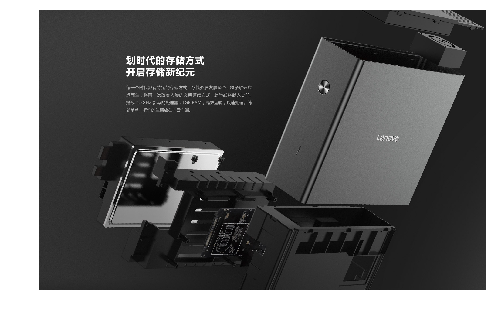

In [27]:
plot_image(testimagepath)

默认会在darknet目录下产生测试结果图片

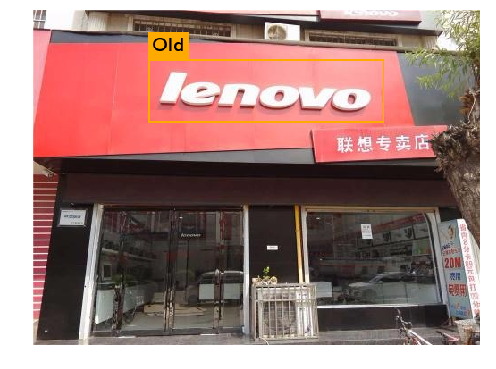

In [39]:
plot_image('/home/msft/msfthack/darknet/predictions.png')

### 转移模型文件

在上面用到的模型将被复制到图片数据集目录下的weights文件夹中，请在Jupyter Notebook中浏览到相应目录下载

如果已经执行过一次下面的命令后需要继续转移新的模型，请注释下面的第一行并修改上面用到的modelname值

In [49]:
get_ipython().system('mkdir /home/msft/msfthack/Image/VOCdevkit/' + imagefolder + '/weights')
get_ipython().system('mv /home/msft/msfthack/darknet/backup/' + modelname + ' ' + '/home/msft/msfthack/Image/VOCdevkit/' + imagefolder +'/weights/')